In [2]:
# from transformers import LlamaForCausalLM as LLaMAForCausalLM
# from transformers import LlamaTokenizer as LLaMATokenizer

# from peft import prepare_model_for_int8_training, LoraConfig, get_peft_model
# from peft import PeftModel
# import torch
# from ParamsIterator import ParamsIterator

In [1]:
from utils import load_model_tokenizer_from_pretrained, draw_metrics_compare_with_glue
# from ParamsIterator import ParamsIterator
# from EvaluateTestSet import EvaluateTestSet
import pandas as pd
from transformers import GenerationConfig

from tqdm import tqdm_notebook

def get_metric_res(model, tokenizer, params_iteration, experiment_name):
    res = []
    for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):
        evaluator = EvaluateTestSet(generation_config = GenerationConfig(**generation_config_dict
                                                                        ),
                                    fn_test_data = "temp/t2c_answers.json",
                                    fn_etalon = "temp/answers.json"
                                   )

        metric_res = evaluator.evaluate(model=model, 
                                        tokenizer=tokenizer,
                                       )
        for key, val in generation_config_dict.items():
            assert key not in metric_res
            metric_res[key] = val

        metric_res['experiment_name'] = experiment_name
        print(generation_config_dict, metric_res)

        res.append(metric_res)
    
    return res


/root/git/experiments_ipynb/prompter/templates/

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [7]:
import torch
from transformers import GenerationConfig

from datetime import datetime
import json
import numpy as np
import math
import tqdm

from T2CEvaluator import T2CEvaluator

from prompter import Prompter
prompter = Prompter()

def generate_test_prompt(data_point):
    #assert 'output' not in data_point or data_point['output']==''
    if "input" in data_point and data_point["input"]:
        return prompter.generate_prompt(instruction = data_point["instruction"],
                                        input = data_point["input"],
                                        #label = ''#data_point["output"]
                                       )
    else:
        return prompter.generate_prompt(instruction = data_point["instruction"],
                                        #input = None,
                                        #label = ''#data_point["output"]
                                       )
   
# def generate_test_prompt(data_point, train = False):
#     # To decrease expectations of results :)
#     assert train == False
#     # sorry about the formatting disaster gotta move fast
#     if data_point["input"]:
#         return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
# ### Instruction:
# {data_point["instruction"]}

# ### Input:
# {data_point["input"]}

# ### Response:
# {data_point["output"] if train else ''}"""
#     else:
#         return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
# ### Instruction:
# {data_point["instruction"]}

# ### Response:
# {data_point["output"] if train else ''}"""


class EvaluateTestSet:
    def __init__(self, 
                 generation_config = GenerationConfig(max_new_tokens = 128), 
                 fn_test_data = "../data/t2c_answers.json",
                 fn_etalon = "/root/data/answers.json",
                 batch_size = 10,
                 verbose = False
                ):
        self.generation_config = generation_config
        
        self.fn_test_data = fn_test_data
        self.fn_etalon = fn_etalon
        
        self.batch_size = batch_size
        self.verbose = verbose
       
    def preprocess(self, s):
        #ToDo rewrite it using Promt Template
        s = prompter.get_response(s)
        #s = s.split('### Response:\n')[-1]
        s = s.replace('\n', '  ')
        s = s.replace('<unk>', " ")
        s = ' '.join(s.split(' ')[:100])
        while '  ' in s:
            s = s.replace('  ', ' ')

        if len(s) > 0 and s[0] == ' ':
            s = s[1:]
        
        if self.verbose:
            print(s)
        
        return s

    def clean_results(self, res_list):
        predict_list = []
        for s in tqdm.tqdm(res_list):
            predict_list.append(self.preprocess(s))
        return predict_list
    
    def get_raw_results(self, model, tokenizer, prompts):
        batch_size = self.batch_size
        generation_config = self.generation_config
        
        res_list = []
        n = math.ceil(len(prompts)/batch_size)
        
        for ind in tqdm.tqdm(range(n)):
            current_prompts = prompts[ind*batch_size: (ind+1)*batch_size]
            if self.verbose:
                print(ind * batch_size, (ind+1)*batch_size, len(current_prompts))

            tokenized_inputs = tokenizer(list(current_prompts), 
                                         padding=True, 
                                         truncation=True, 
                                         return_tensors="pt"
                                        ).to('cuda')



            with torch.no_grad():
                full_output = model.generate(
                    **tokenized_inputs,
                    generation_config=generation_config
                )

            res_list.extend(tokenizer.batch_decode(full_output, skip_special_tokens=False))
        
        return res_list
    
    def save_results(self, predict_list):
        output_filename = str(datetime.now()).split('.')[0].replace(' ', '-').replace(':', '_')+'.txt'
        fn_output = "/root/results/%s"%output_filename
        
        res = '\n'.join([i if i!='' else '-' for i in predict_list])
        open(fn_output, "w+", encoding='utf-8').write(res)
        return fn_output
    
    def evaluate(self, model, tokenizer):
        model.eval()
        assert model.training == False

        lst = json.load(open(self.fn_test_data, 'rb'))
        inputs = lst# [lst[0]]
        # instruction = 'Combine the question and answer into an image caption as succinctly as possible. Be sure to include the phrase "a photo of". Do not draw false conclusions.'
        # inputs = ['Is this a baseball game? yes', 'Is this a baseball game? no']
        prompts = [generate_test_prompt(inp) for inp in inputs]
        prompts = np.array(prompts)
        
        res_list = self.get_raw_results(model = model, 
                                        tokenizer = tokenizer,
                                        prompts = prompts)
        
        model.train()
        assert model.training == True
        
        predict_list = self.clean_results(res_list)
        
        self.fn_output = self.save_results(predict_list)
        
        t2c_evaluator = T2CEvaluator()
        metric_res = t2c_evaluator.calculate_metrics(fn_answers = self.fn_etalon, 
                                                     fn_predictions = self.fn_output
                                                     )
        return metric_res

/root/git/experiments_ipynb/prompter/templates/


In [4]:

default_model = "decapoda-research/llama-7b-hf"
experiment_name = "/root/experiments/t2c_concode_220428_v31/"

# params_iteration = {"temperature": [1.0],
#                     "max_new_tokens": [None, 20, 30, 35, 40, 50, 60, 70, 80, 90, 100] + [45, 47, 49, 51, 53, 55]
#                    }


In [5]:
tokenizer, model = load_model_tokenizer_from_pretrained(default_model = default_model, 
                                                        experiment_name = experiment_name
                                                       )

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [23]:
evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = 39, 
#                                                                  early_stopping = True,
#                                                                  top_p = 0.95,
                                                                 do_sample = True
#                                                                  num_beams=2
                                                                ),
                            fn_test_data = "/root/ipynb/temp/t2c_answers.json",
                            fn_etalon = "/root/ipynb/temp/answers.json",
#                             batch_size = 1
                           )

metric_res = evaluator.evaluate(model = model, 
                                tokenizer = tokenizer
                               )
metric_res['BLEU']

# 0.2567052680523715 EARLY STOPING TRUE
# 0.2567052680523715 EARLY STOPING FALSE

# 0.276635011765535      -   batch_size = 
# 0.2582467093040898      -   prompter responce and ...
# 0.2176..
# 0.22860836211162178

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 163414.44it/s]


0.25269346007367055

In [ ]:
NEW:
batch_size = 1
BLEU ?

NEW:
batch_size = defauld(10)
BLEU 0.2990267057157313

OLD:
batch_size = defauld(10)
BLEU 3.043689e-01

In [1]:
0

0

In [2]:
for experiment_name in ["/root/experiments/t2c_concode_220428_v9/",
                        "/root/experiments/t2c_concode_220428_v10/",
                        "/root/experiments/t2c_concode_220428_v11/",
                        "/root/experiments/t2c_concode_220428_v12/"]:
    tokenizer, model = load_model_tokenizer_from_pretrained(default_model = default_model, 
                                                            experiment_name = experiment_name
                                                           )
    print(experiment_name)
    model.print_trainable_parameters()
# res = get_metric_res(model=model,
#                      tokenizer=tokenizer,
#                      params_iteration=params_iteration,
#                      experiment_name=experiment_name
#                     )
# data = pd.DataFrame(res).sort_values("BLEU")
# data.to_csv(experiment_name + "/metrics.csv")


Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


/root/experiments/t2c_concode_220428_v9/
trainable params: 2097152 || all params: 6740512768 || trainable%: 0.03111264783824826


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


/root/experiments/t2c_concode_220428_v10/
trainable params: 2097152 || all params: 6740512768 || trainable%: 0.03111264783824826


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


/root/experiments/t2c_concode_220428_v11/
trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


/root/experiments/t2c_concode_220428_v12/
trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199


In [5]:
!ls /root/experiments/

t2c_concode_220428_v10	t2c_concode_220428_v13	t2c_concode_220428_v16
t2c_concode_220428_v11	t2c_concode_220428_v14	t2c_concode_220428_v18
t2c_concode_220428_v12	t2c_concode_220428_v15	t2c_concode_220428_v9


In [3]:

default_model = "decapoda-research/llama-7b-hf"
experiment_name = "/root/experiments/t2c_concode_220428_v31/"

params_iteration = {"temperature": [1.0],
                    "max_new_tokens": [None, 20, 30, 35, 40, 50, 60, 70, 80, 90, 100] + [45, 47, 49, 51, 53, 55]
                   }


In [4]:
experiment_name,\
params_iteration

('/root/experiments/t2c_concode_220428_v31/',
 {'temperature': [1.0],
  'max_new_tokens': [None,
   20,
   30,
   35,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   45,
   47,
   49,
   51,
   53,
   55]})

In [5]:
# !ls /root/experiments/t2c_concode_220428_v13/
!ls {experiment_name}

1684072293.7154148   checkpoint-20000
1684072293.727496    events.out.tfevents.1684072293.8d048d63ed1a.18071.0
adapter_config.json  events.out.tfevents.1684072293.8d048d63ed1a.18071.2
adapter_model.bin    experiment_config.json


In [4]:
tokenizer, model = load_model_tokenizer_from_pretrained(default_model = default_model, 
                                                        experiment_name = experiment_name
                                                       )

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [7]:
model.print_trainable_parameters()

trainable params: 536870912 || all params: 7275286528 || trainable%: 7.379378254502749


In [7]:
model.print_trainable_parameters()
#v16  trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199
#v18  trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199

trainable params: 8388608 || all params: 6746804224 || trainable%: 0.12433454005023165


In [8]:
model.print_trainable_parameters()
# trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199

trainable params: 8388608 || all params: 6746804224 || trainable%: 0.12433454005023165


In [8]:
from tqdm import tqdm_notebook

def get_metric_res(model, tokenizer, params_iteration, experiment_name):
    res = []
    for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):
        evaluator = EvaluateTestSet(generation_config = GenerationConfig(**generation_config_dict
                                                                        ),
                                    #fn_test_data = "temp/t2c_answers.json",
                                    #fn_etalon = "temp/answers.json"
                                   )

        metric_res = evaluator.evaluate(model=model, 
                                        tokenizer=tokenizer,
                                       )
        for key, val in generation_config_dict.items():
            assert key not in metric_res
            metric_res[key] = val

        metric_res['experiment_name'] = experiment_name
        print(generation_config_dict, metric_res)

        res.append(metric_res)
    
    return res

In [9]:
model.eval();

In [10]:
# params_iteration = {"temperature": [1.0],
#                     "max_new_tokens": [45, 47, 49, 51, 53, 55]
#                    }

res = get_metric_res(model=model,
                     tokenizer=tokenizer,
                     params_iteration=params_iteration,
                     experiment_name=experiment_name
                    )


/tmp/ipykernel_17903/3839643825.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):


  0%|          | 0/17 [00:00<?, ?it/s]


  0%|                                                                                                                               | 0/10 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 410, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.

 10%|███████████▉                                                                                                           | 1/10 [00:01<00:15,  1.68s/it]Input length of input_ids is 348, but `max_

{'max_new_tokens': None, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 7.937335998986427e-14, 'brevity_penalty': 8.638174725859421e-14, 'ratio': 0.032175032175032175, 'translation_length': 100, 'reference_length': 3108, 'precisions_0': 0.7128712871287128, 'precisions_1': 1.0, 'precisions_2': 1.0, 'precisions_3': 1.0, 'max_new_tokens': None, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 266813.23it/s]


{'max_new_tokens': 20, 'temperature': 1.0} {'EM': 2.0, 'BLEU': 0.16274619397266693, 'brevity_penalty': 0.3154212746389477, 'ratio': 0.4642857142857143, 'translation_length': 1443, 'reference_length': 3108, 'precisions_0': 0.7520775623268698, 'precisions_1': 0.5833333333333334, 'precisions_2': 0.449438202247191, 'precisions_3': 0.35944299390774587, 'max_new_tokens': 20, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.48s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 48652.17it/s]


{'max_new_tokens': 30, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.22778595458654433, 'brevity_penalty': 0.5286053415575819, 'ratio': 0.6106821106821106, 'translation_length': 1898, 'reference_length': 3108, 'precisions_0': 0.6624539231174302, 'precisions_1': 0.49583101723179546, 'precisions_2': 0.36764705882352944, 'precisions_3': 0.2855361596009975, 'max_new_tokens': 30, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 239674.51it/s]


{'max_new_tokens': 35, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.2540599967211016, 'brevity_penalty': 0.6567345865799272, 'ratio': 0.703989703989704, 'translation_length': 2188, 'reference_length': 3108, 'precisions_0': 0.6199177706715395, 'precisions_1': 0.45093346098611775, 'precisions_2': 0.32546459065796085, 'precisions_3': 0.2461701003697834, 'max_new_tokens': 35, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 183317.48it/s]


{'max_new_tokens': 40, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.2837843113764933, 'brevity_penalty': 0.7852839176439429, 'ratio': 0.8053410553410554, 'translation_length': 2503, 'reference_length': 3108, 'precisions_0': 0.5806709265175719, 'precisions_1': 0.42054908485856907, 'precisions_2': 0.30281995661605204, 'precisions_3': 0.2306298142274581, 'max_new_tokens': 40, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 40646.42it/s]


{'max_new_tokens': 50, 'temperature': 1.0} {'EM': 1.0, 'BLEU': 0.3021691948055384, 'brevity_penalty': 0.9814910350712247, 'ratio': 0.9816602316602316, 'translation_length': 3051, 'reference_length': 3108, 'precisions_0': 0.5088466579292268, 'precisions_1': 0.358739837398374, 'precisions_2': 0.25543097407147863, 'precisions_3': 0.19267053701015965, 'max_new_tokens': 50, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.71s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 53635.60it/s]


{'max_new_tokens': 60, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.26227274763282676, 'brevity_penalty': 1.0, 'ratio': 1.1924066924066925, 'translation_length': 3706, 'reference_length': 3108, 'precisions_0': 0.44375505799838144, 'precisions_1': 0.3074577210978653, 'precisions_2': 0.21528371827773024, 'precisions_3': 0.16109154929577466, 'max_new_tokens': 60, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163648.22it/s]


{'max_new_tokens': 70, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.21954327767922843, 'brevity_penalty': 1.0, 'ratio': 1.3928571428571428, 'translation_length': 4329, 'reference_length': 3108, 'precisions_0': 0.3875288683602771, 'precisions_1': 0.2614657210401891, 'precisions_2': 0.17816509319777293, 'precisions_3': 0.12868832134887181, 'max_new_tokens': 70, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.89s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 48177.17it/s]


{'max_new_tokens': 80, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.19639840846909837, 'brevity_penalty': 1.0, 'ratio': 1.6287001287001286, 'translation_length': 5062, 'reference_length': 3108, 'precisions_0': 0.3484100335769307, 'precisions_1': 0.23272214386459802, 'precisions_2': 0.1597779148673658, 'precisions_3': 0.1148435859752257, 'max_new_tokens': 80, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 150819.99it/s]


{'max_new_tokens': 90, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.17027130650904543, 'brevity_penalty': 1.0, 'ratio': 1.8256113256113256, 'translation_length': 5674, 'reference_length': 3108, 'precisions_0': 0.30731277533039647, 'precisions_1': 0.20286995515695067, 'precisions_2': 0.13732651570489407, 'precisions_3': 0.09817776124953514, 'max_new_tokens': 90, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:37<00:00, 15.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129613.84it/s]


{'max_new_tokens': 100, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.15230890033305006, 'brevity_penalty': 1.0, 'ratio': 2.0476190476190474, 'translation_length': 6364, 'reference_length': 3108, 'precisions_0': 0.27714061272584445, 'precisions_1': 0.1819632881085395, 'precisions_2': 0.12291227501216151, 'precisions_3': 0.08682042833607907, 'max_new_tokens': 100, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163712.10it/s]


{'max_new_tokens': 45, 'temperature': 1.0} {'EM': 1.0, 'BLEU': 0.29285714905894916, 'brevity_penalty': 0.8797384148896618, 'ratio': 0.8864221364221364, 'translation_length': 2755, 'reference_length': 3108, 'precisions_0': 0.5428156748911466, 'precisions_1': 0.38629518072289154, 'precisions_2': 0.27716966379984365, 'precisions_3': 0.21129622104835433, 'max_new_tokens': 45, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.87s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 63578.96it/s]


{'max_new_tokens': 47, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.29693165015291634, 'brevity_penalty': 0.9238859306241876, 'ratio': 0.9266409266409267, 'translation_length': 2880, 'reference_length': 3108, 'precisions_0': 0.5275945852134676, 'precisions_1': 0.3736066163250629, 'precisions_2': 0.26733780760626397, 'precisions_3': 0.20247773906310493, 'max_new_tokens': 47, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 63386.79it/s]


{'max_new_tokens': 49, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.30436888834304315, 'brevity_penalty': 0.9735956867826578, 'ratio': 0.9739382239382239, 'translation_length': 3027, 'reference_length': 3108, 'precisions_0': 0.5161822985468957, 'precisions_1': 0.3637295081967213, 'precisions_2': 0.2599009900990099, 'precisions_3': 0.19574780058651026, 'max_new_tokens': 49, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 202917.46it/s]


{'max_new_tokens': 51, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.3032555692814405, 'brevity_penalty': 1.0, 'ratio': 1.0041827541827542, 'translation_length': 3121, 'reference_length': 3108, 'precisions_0': 0.5028827674567585, 'precisions_1': 0.35340833884844475, 'precisions_2': 0.25136798905608754, 'precisions_3': 0.18931351733899504, 'max_new_tokens': 51, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.77s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 40540.34it/s]


{'max_new_tokens': 53, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.29429136126844146, 'brevity_penalty': 1.0, 'ratio': 1.0521235521235521, 'translation_length': 3270, 'reference_length': 3108, 'precisions_0': 0.49067563436258027, 'precisions_1': 0.3424787133396405, 'precisions_2': 0.24348958333333334, 'precisions_3': 0.18331651530440632, 'max_new_tokens': 53, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 195903.97it/s]

{'max_new_tokens': 55, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.2858994980739995, 'brevity_penalty': 1.0, 'ratio': 1.10006435006435, 'translation_length': 3419, 'reference_length': 3108, 'precisions_0': 0.47748538011695907, 'precisions_1': 0.33343373493975903, 'precisions_2': 0.23633540372670808, 'precisions_3': 0.17756410256410257, 'max_new_tokens': 55, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v31/'}


In [ ]:
max_new_tokens = 49

In [12]:
# res2 = [{'max_new_tokens': 60, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.27660727734128454, 'brevity_penalty': 1.0, 'ratio': 1.1962676962676964, 'translation_length': 3718, 'reference_length': 3108, 'precisions_0': 0.46060769023931164, 'precisions_1': 0.32412268582481346, 'precisions_2': 0.23074737141233304, 'precisions_3': 0.16993272886809008, 'max_new_tokens': 60, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'}]

In [13]:
# # res = resres2
# res1 = [i for i in res]

# res.extend(res2)

In [14]:
# res[-1]

In [11]:
# res = [{'max_new_tokens': None, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 5.612544109439402e-14, 'brevity_penalty': 8.638174725859421e-14, 'ratio': 0.032175032175032175, 'translation_length': 100, 'reference_length': 3108, 'precisions_0': 0.1782178217821782, 'precisions_1': 1.0, 'precisions_2': 1.0, 'precisions_3': 1.0, 'max_new_tokens': None, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'},
#         {'max_new_tokens': 20, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.00015739152854811044, 'brevity_penalty': 0.015697891802788876, 'ratio': 0.19401544401544402, 'translation_length': 603, 'reference_length': 3108, 'precisions_0': 0.12417218543046357, 'precisions_1': 0.011904761904761904, 'precisions_2': 0.0023584905660377358, 'precisions_3': 0.002898550724637681, 'max_new_tokens': 20, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'},
#         {'max_new_tokens': 30, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.0005671776290978791, 'brevity_penalty': 0.08143902671466742, 'ratio': 0.2850707850707851, 'translation_length': 886, 'reference_length': 3108, 'precisions_0': 0.11724915445321307, 'precisions_1': 0.008894536213468869, 'precisions_2': 0.0014144271570014145, 'precisions_3': 0.001594896331738437, 'max_new_tokens': 30, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'},
#         {'max_new_tokens': 35, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.0007636351109178241, 'brevity_penalty': 0.12680703500621668, 'ratio': 0.32625482625482627, 'translation_length': 1014, 'reference_length': 3108, 'precisions_0': 0.10837438423645321, 'precisions_1': 0.007650273224043716, 'precisions_2': 0.0011976047904191617, 'precisions_3': 0.0013245033112582781, 'max_new_tokens': 35, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'},
#         {'max_new_tokens': 40, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.0009618965863040525, 'brevity_penalty': 0.1783644445823123, 'ratio': 0.36711711711711714, 'translation_length': 1141, 'reference_length': 3108, 'precisions_0': 0.10683012259194395, 'precisions_1': 0.0067178502879078695, 'precisions_2': 0.0010395010395010396, 'precisions_3': 0.0011337868480725624, 'max_new_tokens': 40, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'},
#         {'max_new_tokens': 50, 'temperature': 1.0, 'EM': 0.0, 'BLEU': 0.0013229101423892047, 'brevity_penalty': 0.3017912270031732, 'ratio': 0.45495495495495497, 'translation_length': 1414, 'reference_length': 3108, 'precisions_0': 0.0989399293286219, 'precisions_1': 0.00532319391634981, 'precisions_2': 0.0008097165991902834, 'precisions_3': 0.0008658008658008658, 'max_new_tokens': 50, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v14/'}
#         ]

experiment_name

'/root/experiments/t2c_concode_220428_v31/'

In [16]:
experiment_name

'/root/experiments/t2c_concode_220428_v19/'

In [23]:
# !cat /root/ipynb/temp/answers.json

In [5]:
evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = 39, 
#                                                                  num_beams=2
                                                                ),
                            fn_test_data = "/root/ipynb/temp/t2c_answers.json",
                            fn_etalon = "/root/ipynb/temp/answers.json"
                           )

metric_res = evaluator.evaluate(model=model, 
                                tokenizer=tokenizer,
                               )
metric_res['BLEU']
# 0.22860836211162178

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 184230.04it/s]


0.22860836211162178

In [25]:
metric_res['BLEU']

0.22860836211162178

In [16]:
data['/root/experiments/t2c_concode_220428_v31'].sort_values("BLEU")

Unnamed: 0   EM          BLEU  brevity_penalty     ratio   
0            0  0.0  7.937336e-14     8.638175e-14  0.032175  \
1           10  0.0  1.523089e-01     1.000000e+00  2.047619   
2            1  2.0  1.627462e-01     3.154213e-01  0.464286   
3            9  0.0  1.702713e-01     1.000000e+00  1.825611   
4            8  0.0  1.963984e-01     1.000000e+00  1.628700   
5            7  0.0  2.195433e-01     1.000000e+00  1.392857   
6            2  0.0  2.277860e-01     5.286053e-01  0.610682   
7            3  0.0  2.540600e-01     6.567346e-01  0.703990   
8            6  0.0  2.622727e-01     1.000000e+00  1.192407   
9            4  0.0  2.837843e-01     7.852839e-01  0.805341   
10          16  0.0  2.858995e-01     1.000000e+00  1.100064   
11          11  1.0  2.928571e-01     8.797384e-01  0.886422   
12          15  0.0  2.942914e-01     1.000000e+00  1.052124   
13          12  0.0  2.969317e-01     9.238859e-01  0.926641   
14           5  1.0  3.021692e-01     9.814910e-01  0.981660   
15          14  0.0  3.032556e-01     1.000000e+00  1.004183   
16          13  0.0  3.043689e-01     9.735957e-01  0.973938   

    translation_length  reference_length  precisions_0  precisions_1   
0                  100              3108      0.712871      1.000000  \
1                 6364              3108      0.277141      0.181963   
2                 1443              3108      0.752078      0.583333   
3                 5674              3108      0.307313      0.202870   
4                 5062              3108      0.348410      0.232722   
5                 4329              3108      0.387529      0.261466   
6                 1898              3108      0.662454      0.495831   
7                 2188              3108      0.619918      0.450933   
8                 3706              3108      0.443755      0.307458   
9                 2503              3108      0.580671      0.420549   
10                3419              3108      0.477485      0.333434   
11                2755              3108      0.542816      0.386295   
12                3270              3108      0.490676      0.342479   
13                2880              3108      0.527595      0.373607   
14                3051              3108      0.508847      0.358740   
15                3121              3108      0.502883      0.353408   
16                3027              3108      0.516182      0.363730   

    precisions_2  precisions_3  max_new_tokens  temperature   
0       1.000000      1.000000             NaN          1.0  \
1       0.122912      0.086820           100.0          1.0   
2       0.449438      0.359443            20.0          1.0   
3       0.137327      0.098178            90.0          1.0   
4       0.159778      0.114844            80.0          1.0   
5       0.178165      0.128688            70.0          1.0   
6       0.367647      0.285536            30.0          1.0   
7       0.325465      0.246170            35.0          1.0   
8       0.215284      0.161092            60.0          1.0   
9       0.302820      0.230630            40.0          1.0   
10      0.236335      0.177564            55.0          1.0   
11      0.277170      0.211296            45.0          1.0   
12      0.243490      0.183317            53.0          1.0   
13      0.267338      0.202478            47.0          1.0   
14      0.255431      0.192671            50.0          1.0   
15      0.251368      0.189314            51.0          1.0   
16      0.259901      0.195748            49.0          1.0   

                              experiment_name  
0   /root/experiments/t2c_concode_220428_v31/  
1   /root/experiments/t2c_concode_220428_v31/  
2   /root/experiments/t2c_concode_220428_v31/  
3   /root/experiments/t2c_concode_220428_v31/  
4   /root/experiments/t2c_concode_220428_v31/  
5   /root/experiments/t2c_concode_220428_v31/  
6   /root/experiments/t2c_concode_220428_v31/  
7   /root/experiments/t2c_concode_2

In [12]:
data = pd.DataFrame(res).sort_values("BLEU")
data.to_csv(experiment_name + "/metrics.csv")

13 13 13
17 17 17
17 17 17
17 17 17
17 17 17
17 17 17


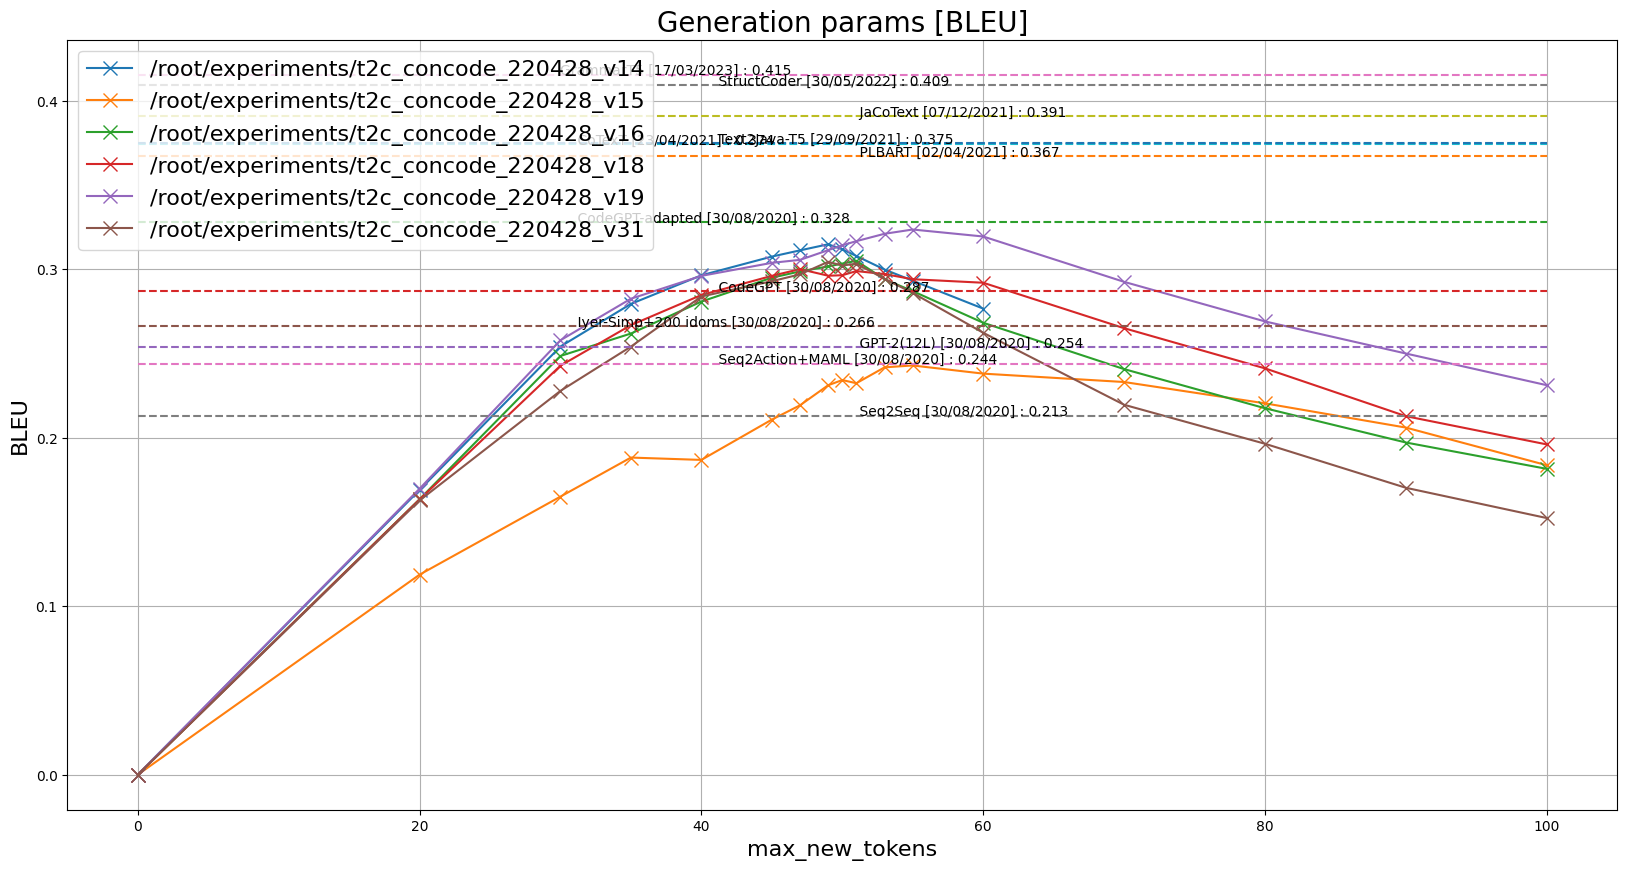

In [13]:
data = {}
for i in ["14", "15", "16", "18", "19", "31"]:
    experiment_name = f"/root/experiments/t2c_concode_220428_v{i}"
    try:
        data[experiment_name] = pd.read_csv(experiment_name + "/metrics.csv")
    except:
        pass

draw_metrics_compare_with_glue(data)

13 13 13
17 17 17
17 17 17
17 17 17
17 17 17


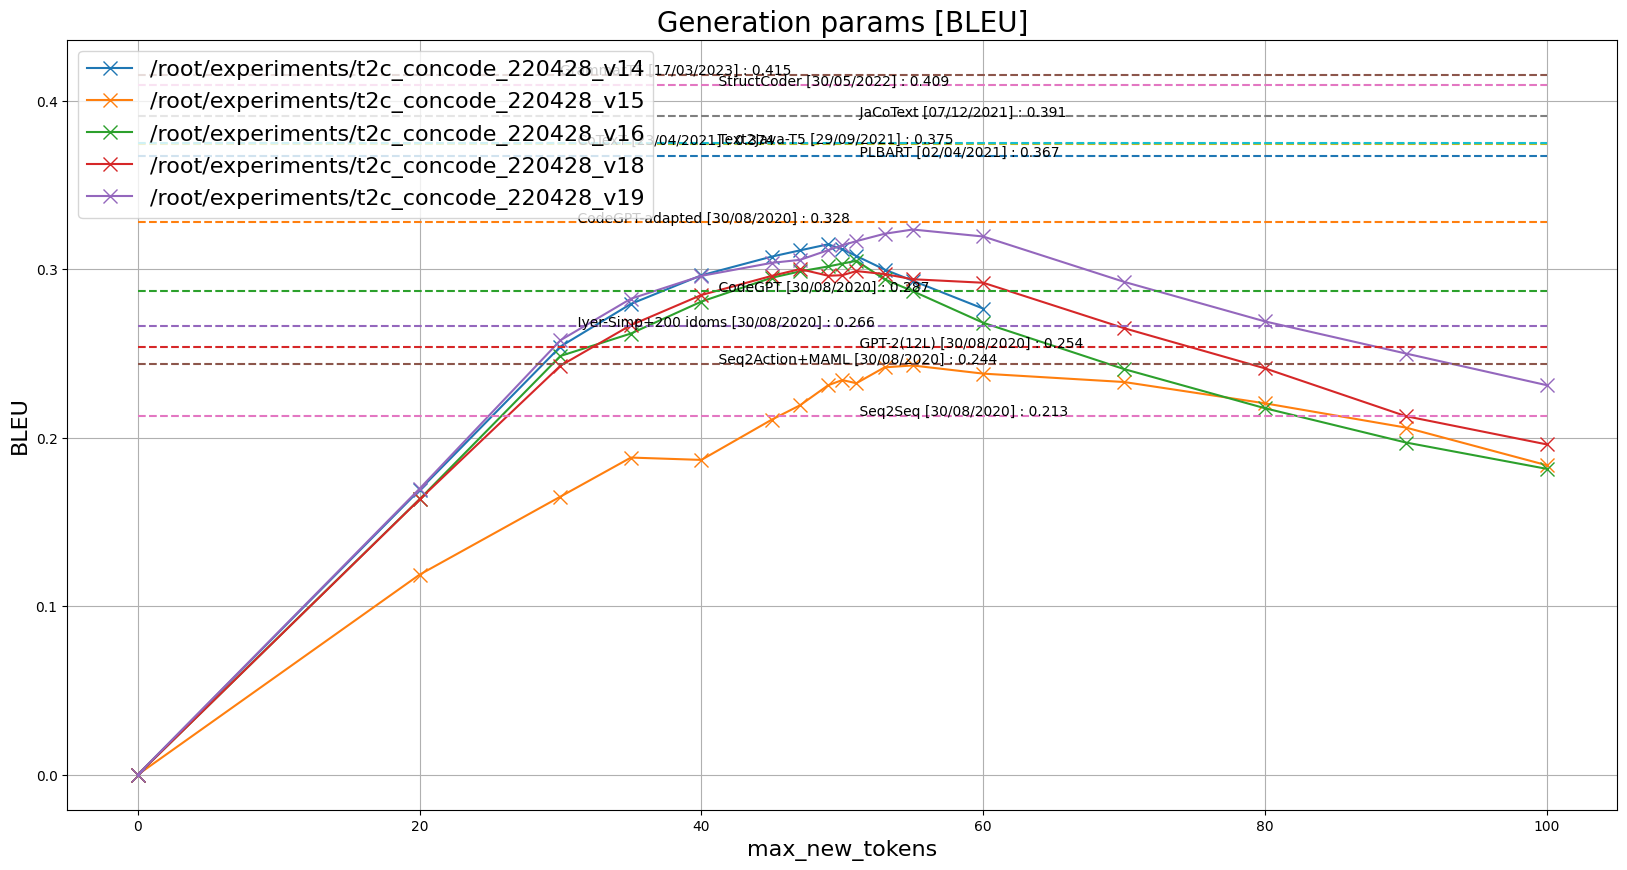

In [19]:
data = {}
for i in ["14", "15", "16", "18", "19"]:
    experiment_name = f"/root/experiments/t2c_concode_220428_v{i}"
    try:
        data[experiment_name] = pd.read_csv(experiment_name + "/metrics.csv")
    except:
        pass

draw_metrics_compare_with_glue(data)

13 13 13
17 17 17
17 17 17
17 17 17


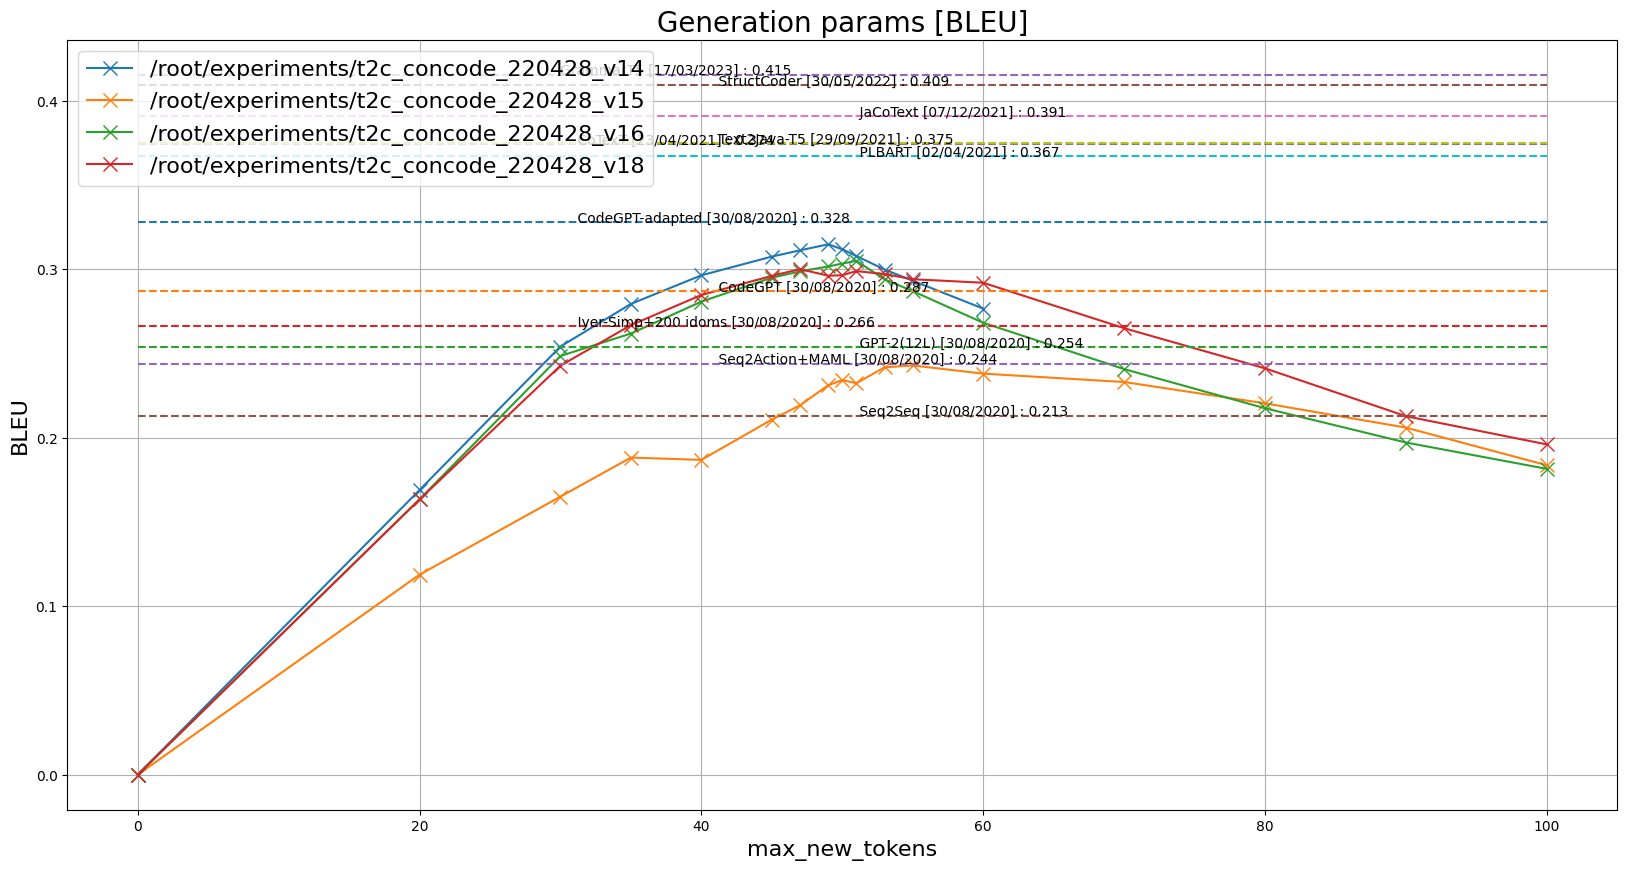

8 8 8
28 28 28
8 8 8
8 8 8
13 13 13
17 17 17
17 17 17
17 17 17
17 17 17


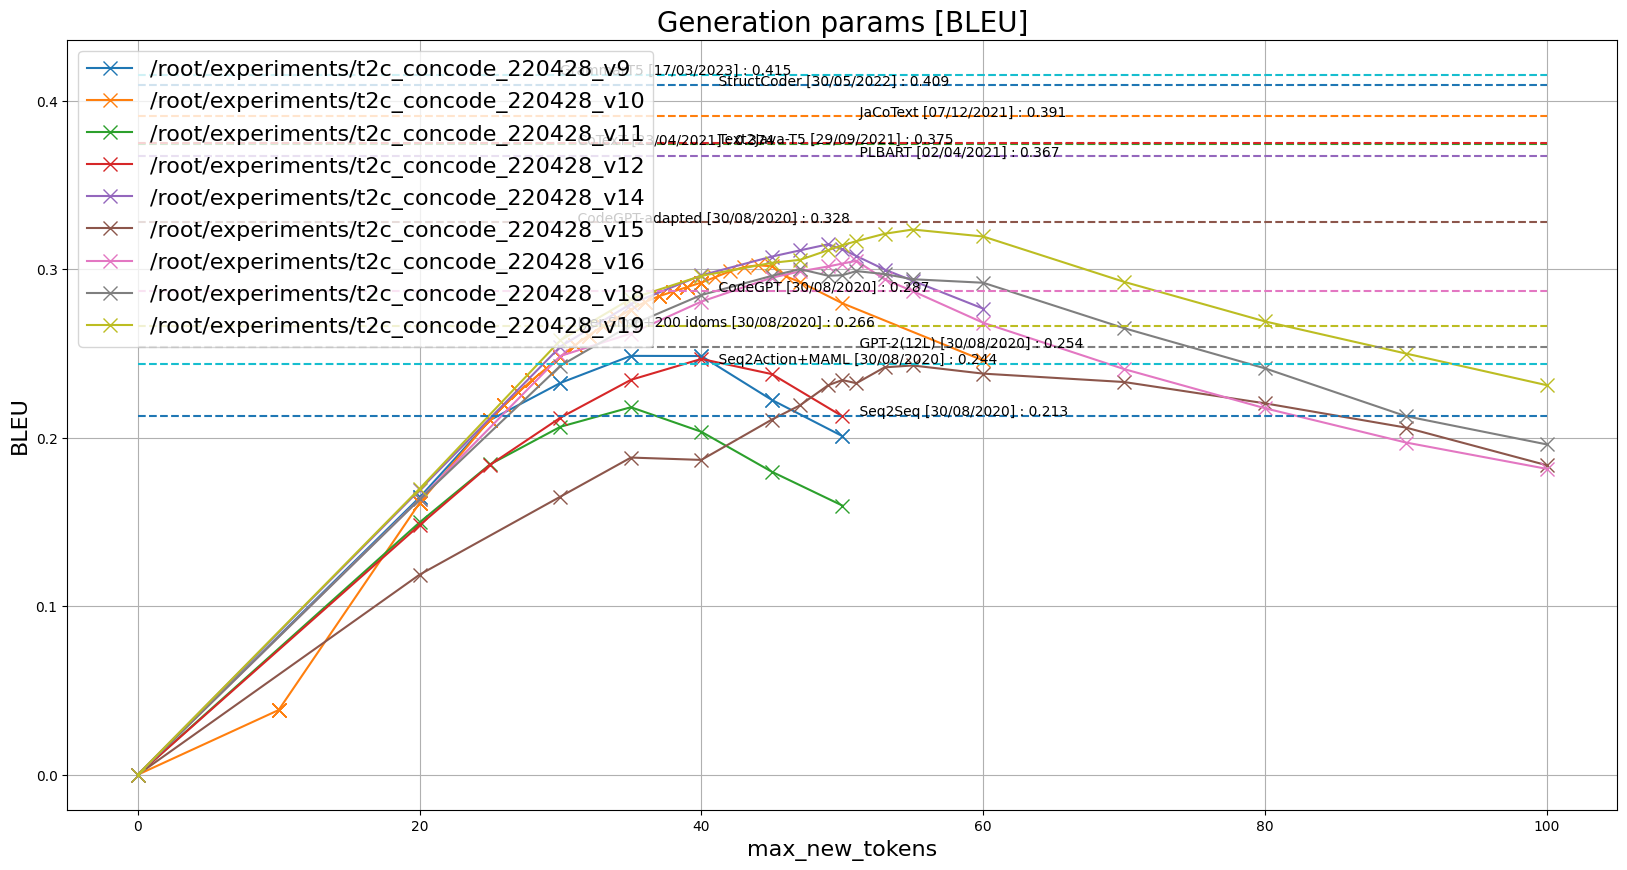

In [18]:
data = {}
for i in ["9", "10", "11", "12", "14", "15", "16", "18", "19"]:
    experiment_name = f"/root/experiments/t2c_concode_220428_v{i}"
    try:
        data[experiment_name] = pd.read_csv(experiment_name + "/metrics.csv")
    except:
        pass

draw_metrics_compare_with_glue(data)

8 8 8
28 28 28
8 8 8
8 8 8
13 13 13
17 17 17
17 17 17
17 17 17


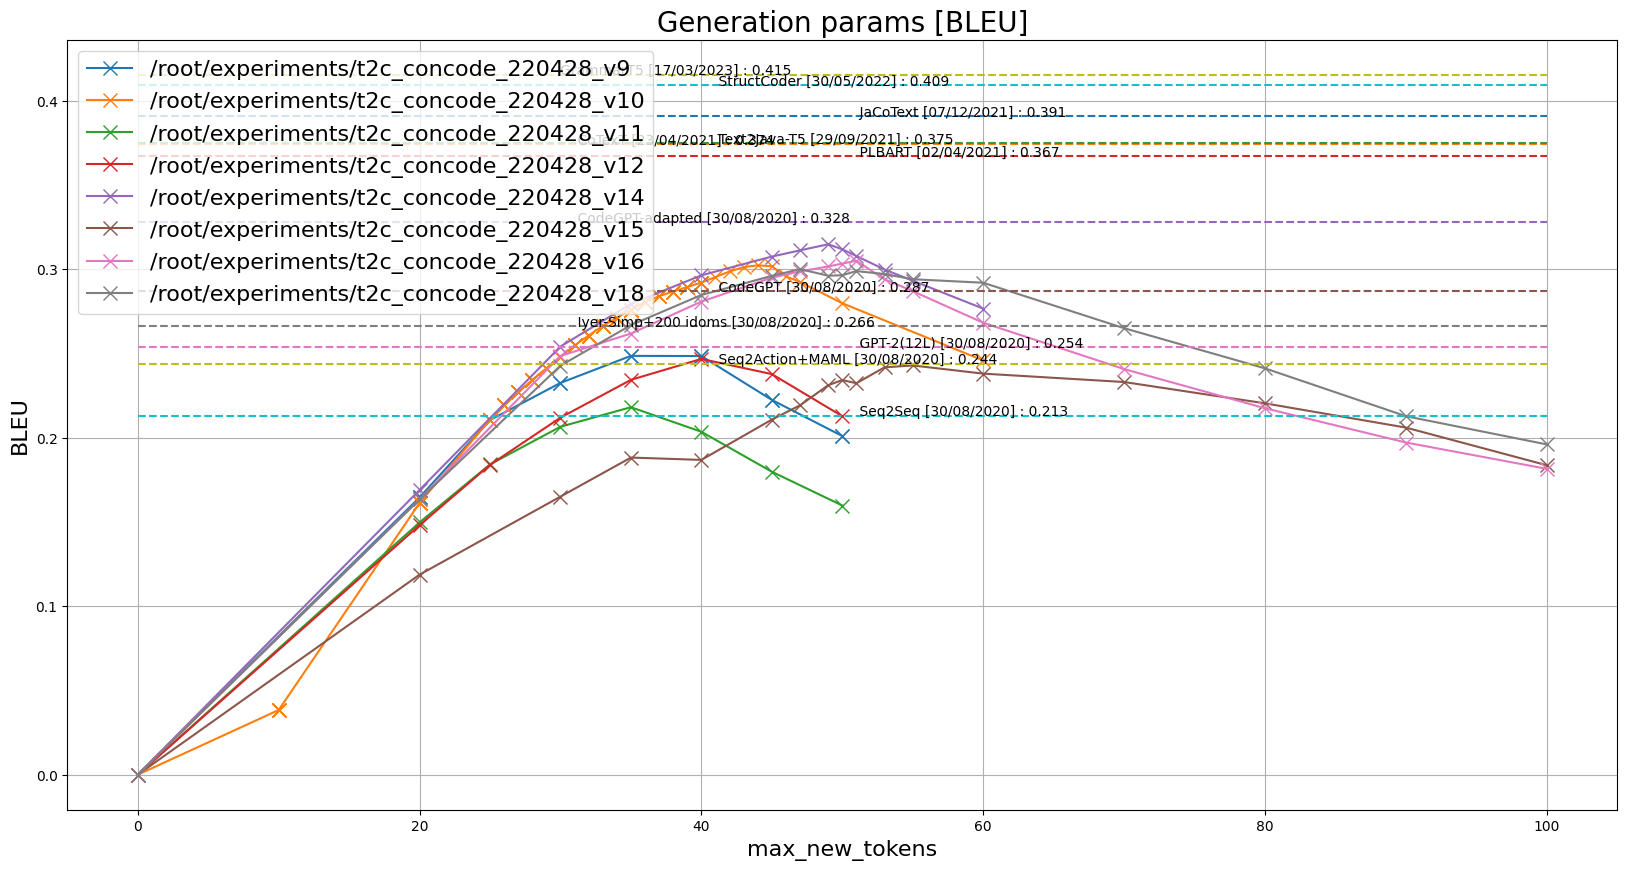

In [26]:
# data = {experiment_name: pd.read_csv(experiment_name+"/metrics.csv"),
#         "/root/experiments/t2c_concode_220428_v10/": pd.read_csv("/root/experiments/t2c_concode_220428_v10/metrics.csv"
#                                                                 )
#        }
sys.exit(main())

8 8 8
28 28 28
8 8 8
8 8 8
13 13 13
17 17 17
17 17 17


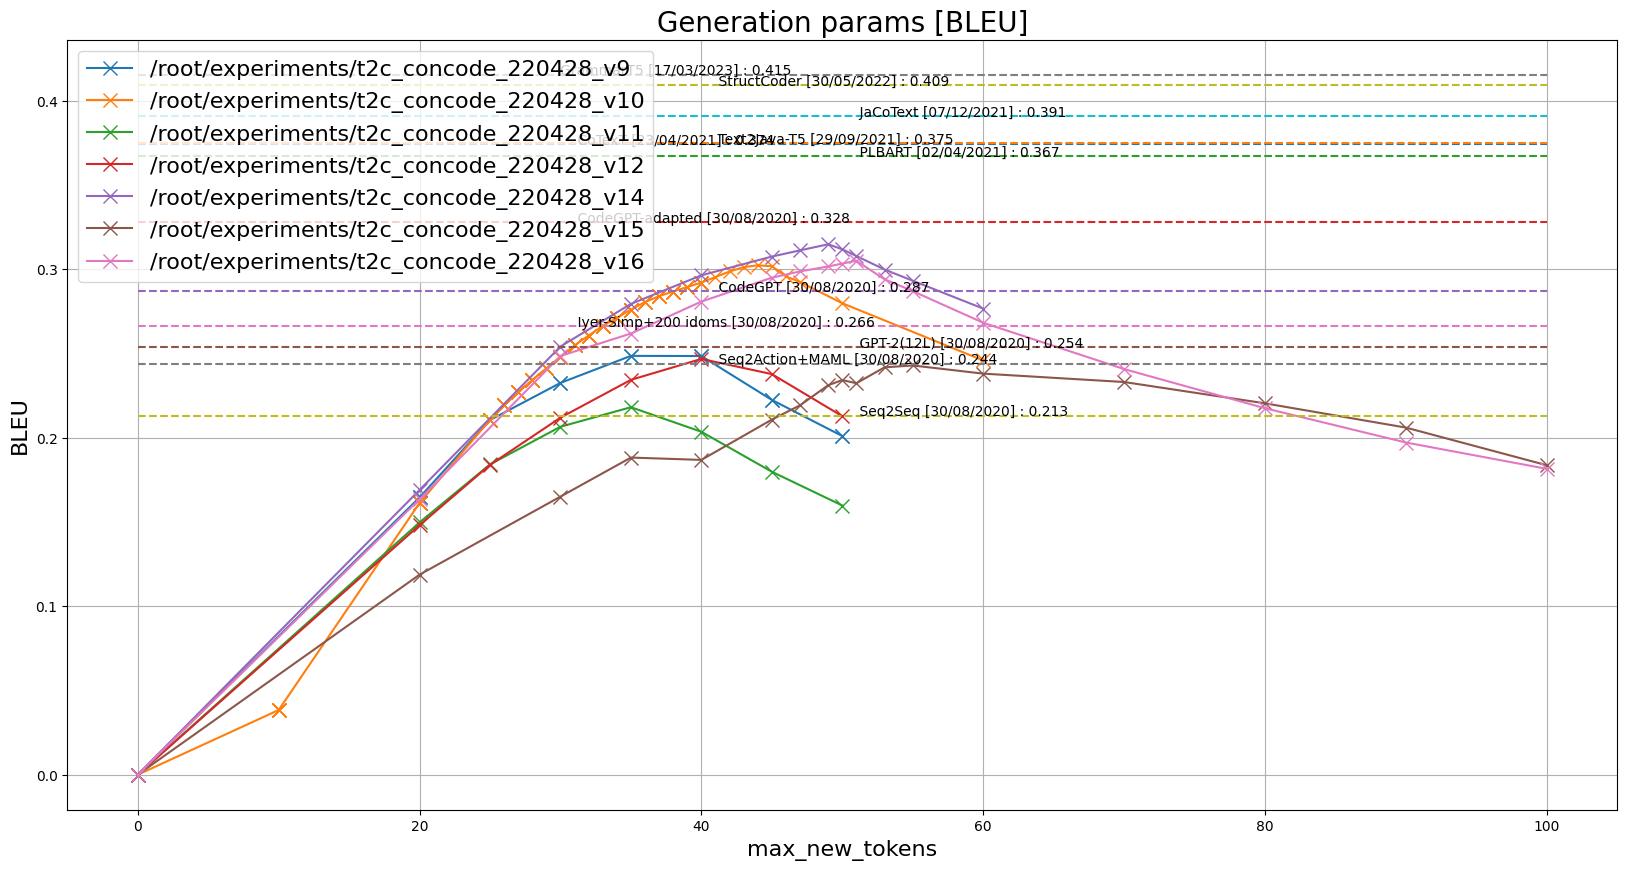

8 8 8
28 28 28
8 8 8
8 8 8
13 13 13
17 17 17


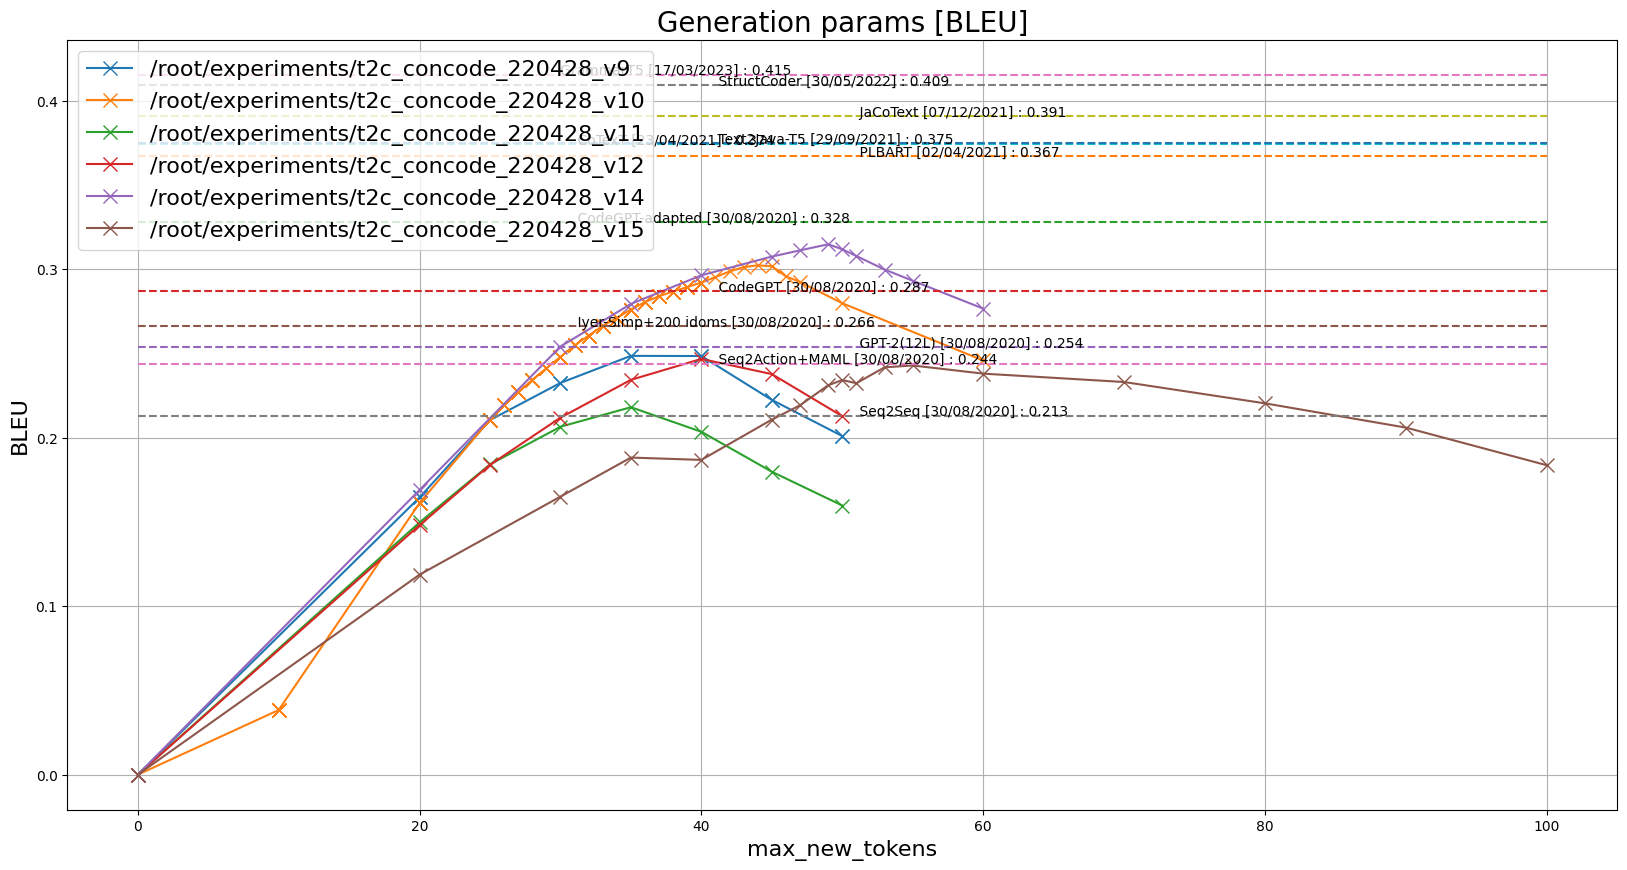

8 8 8
28 28 28
8 8 8
8 8 8
7 7 7


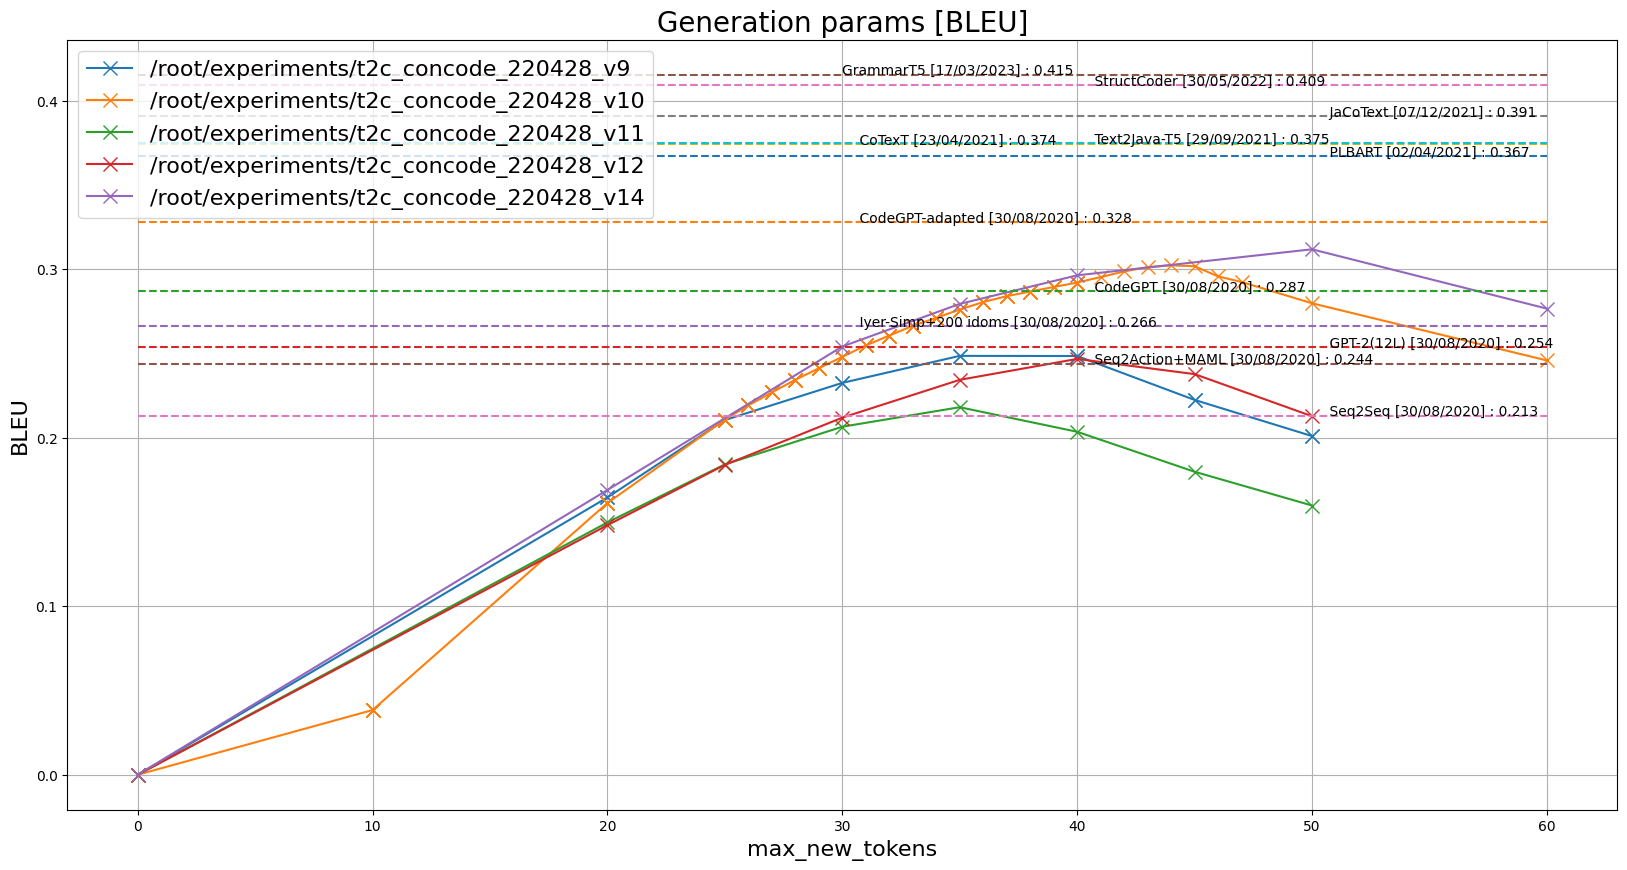

8 8 8
28 28 28
8 8 8
8 8 8
6 6 6


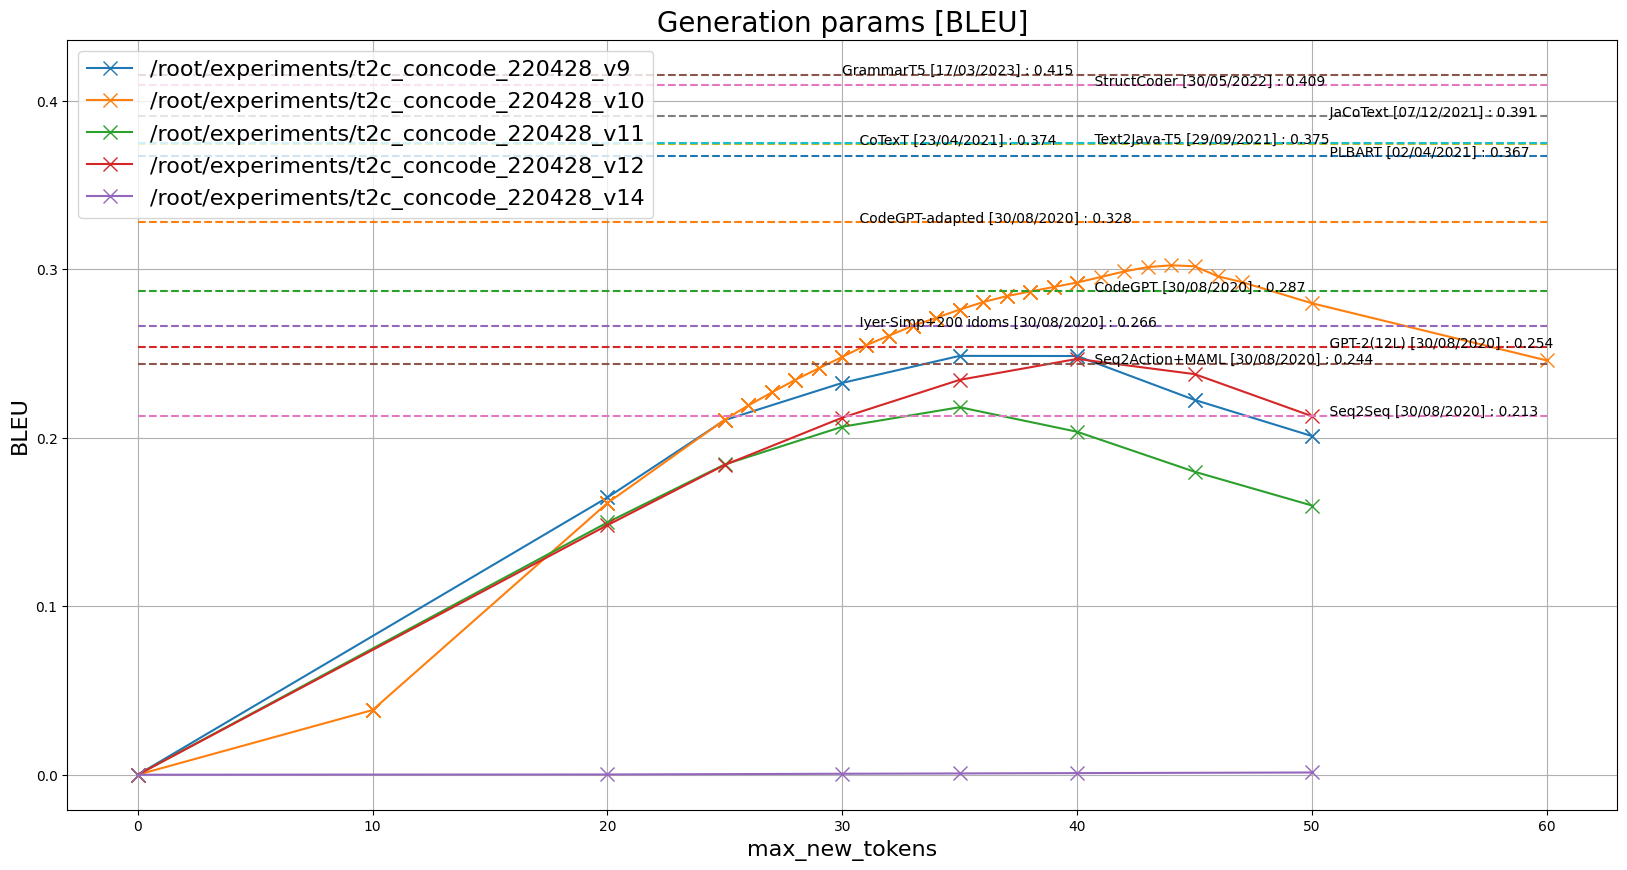

8 8 8
28 28 28
8 8 8
8 8 8


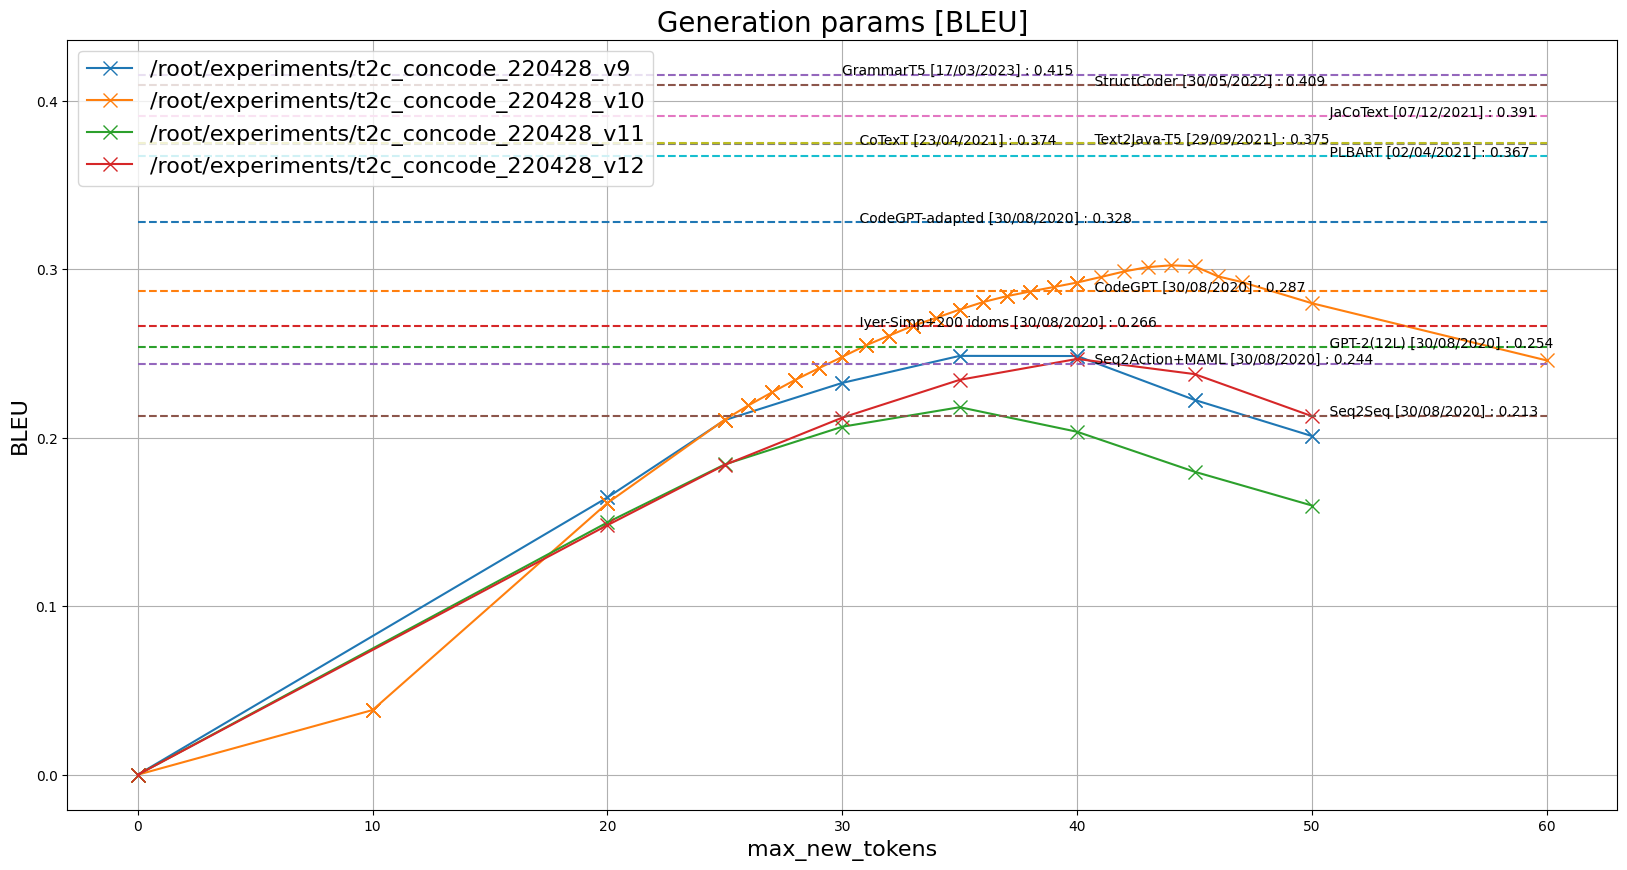

In [7]:
# data = {experiment_name: pd.read_csv(experiment_name+"/metrics.csv"),
#         "/root/experiments/t2c_concode_220428_v10/": pd.read_csv("/root/experiments/t2c_concode_220428_v10/metrics.csv"
#                                                                 )
#        }

data = {}
for i in ["9", "10", "11", "12"]:
    experiment_name = f"/root/experiments/t2c_concode_220428_v{i}"
    try:
        data[experiment_name] = pd.read_csv(experiment_name + "/metrics.csv")
    except:
        pass

draw_metrics_compare_with_glue(data)

In [ ]:
from EvaluateTestSet2 import EvaluateTestSet
from transformers import LlamaForCausalLM as LLaMAForCausalLM
from transformers import LlamaTokenizer as LLaMATokenizer

from peft import prepare_model_for_int8_training, LoraConfig, get_peft_model
from peft import PeftModel
import torch

from transformers import GenerationConfig
from tqdm import tqdm_notebook

In [ ]:
# !ls {experiment_name}
default_model = "decapoda-research/llama-7b-hf"
experiment_name = "/root/experiments/t2c_concode_220428_v9/"

params_iteration = {"temperature": [1.0, 0.001],
                    "max_new_tokens": [None, 20, 25, 30, 35, 40, 45, 50]
                   }

In [4]:
class ParamsIterator:
    """
        Recursive get all params all and all
    """
    def __init__(self, params_iteration):
        self.params_iteration = params_iteration
        self.params_list = list(self.params_iteration.keys())
    
    def __len__(self):
        res = 1
        for key in self.params_list:
            res *= len(self.params_iteration[key]) 
        return res
    
    def __iter__(self, 
                 previous_dict = {}
                ):
        if len(self.params_list)==0:
            yield previous_dict
        else:
            param_name = self.params_list.pop()
            for param_val in self.params_iteration[param_name]:
                previous_dict[param_name] = param_val
                yield from self.__iter__(previous_dict=previous_dict)
            self.params_list.append(param_name)
        
# obj = ParamsIterator(params_iteration=params_iteration)
# from tqdm import tqdm
# import time
# for i in tqdm(obj):
#     print(i)
#     time.sleep(1)

In [9]:
res = get_metric_res(model = model, 
                     tokenizer = tokenizer, 
                     params_iteration = params_iteration,
                     experiment_name = experiment_name
                    )

/tmp/ipykernel_5261/3839643825.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):


  0%|          | 0/8 [00:00<?, ?it/s]


  0%|                                                    | 0/10 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 410, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.

 10%|████▍                                       | 1/10 [00:01<00:14,  1.60s/it]Input length of input_ids is 348, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.

 20%|████████▊                          

NameError: name 'verbose' is not defined

In [5]:
def load_model_tokenizer_from_pretrained(default_model, 
                                         experiment_name
                                        ):
    # ToDo: BASE model is getting from config
    BASE_MODEL = default_model
    LORA_WEIGHTS = experiment_name

    model = LLaMAForCausalLM.from_pretrained(
        BASE_MODEL,
        load_in_8bit=True,
        device_map="auto"
    )

    model = PeftModel.from_pretrained(
        model,
        LORA_WEIGHTS,
        torch_dtype=torch.float16,
    )

    tokenizer = LLaMATokenizer.from_pretrained(BASE_MODEL)
    model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
    tokenizer.padding_side = "left"
    # not sure how necessary this part is, not sure if tloen/alpaca-lora-7b was even trained with EOS and BOS tokens
    model.config.bos_token_id = 1
    model.config.eos_token_id = 2

    model.eval()
    
    return tokenizer, model

In [7]:
tokenizer, model = load_model_tokenizer_from_pretrained(default_model = default_model, 
                                                        experiment_name = experiment_name
                                                       )

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [11]:
def get_metric_res(model, tokenizer, params_iteration, experiment_name):
    res = []
    for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):
        evaluator = EvaluateTestSet(generation_config = GenerationConfig(**generation_config_dict
                                                                        ),
                                    #fn_test_data = "temp/t2c_answers.json",
                                    #fn_etalon = "temp/answers.json"
                                   )

        metric_res = evaluator.evaluate(model=model, 
                                        tokenizer=tokenizer,
                                       )
        for key, val in generation_config_dict.items():
            assert key not in metric_res
            metric_res[key] = val

        metric_res['experiment_name'] = experiment_name
        print(generation_config_dict, metric_res)

        res.append(metric_res)
    
    return res

In [12]:
res = get_metric_res(model = model, 
                     tokenizer = tokenizer, 
                     params_iteration = params_iteration,
                     experiment_name = experiment_name
                    )

  0%|                                                    | 0/10 [00:00<?, ?it/s]Input length of input_ids is 410, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


0 10 10


 10%|████▍                                       | 1/10 [00:00<00:08,  1.12it/s]Input length of input_ids is 348, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


10 20 10


 20%|████████▊                                   | 2/10 [00:01<00:06,  1.26it/s]Input length of input_ids is 517, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


20 30 10


 30%|█████████████▏                              | 3/10 [00:02<00:06,  1.06it/s]Input length of input_ids is 416, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


30 40 10


 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.10it/s]Input length of input_ids is 351, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


40 50 10


 50%|██████████████████████                      | 5/10 [00:04<00:04,  1.18it/s]Input length of input_ids is 414, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.17it/s]Input length of input_ids is 252, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.32it/s]Input length of input_ids is 325, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.36it/s]Input length of input_ids is 294, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.43it/s]Input length of input_ids is 280, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 151309.67it/s]


{'max_new_tokens': None, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 7.736953381720596e-14, 'brevity_penalty': 8.638174725859421e-14, 'ratio': 0.032175032175032175, 'translation_length': 100, 'reference_length': 3108, 'precisions_0': 0.6435643564356436, 'precisions_1': 1.0, 'precisions_2': 1.0, 'precisions_3': 1.0, 'max_new_tokens': None, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]Input length of input_ids is 410, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


0 10 10


 10%|████▍                                       | 1/10 [00:00<00:07,  1.15it/s]Input length of input_ids is 348, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


10 20 10


 20%|████████▊                                   | 2/10 [00:01<00:06,  1.25it/s]Input length of input_ids is 517, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


20 30 10


 30%|█████████████▏                              | 3/10 [00:02<00:06,  1.07it/s]Input length of input_ids is 416, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


30 40 10


 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.10it/s]Input length of input_ids is 351, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


40 50 10


 50%|██████████████████████                      | 5/10 [00:04<00:04,  1.17it/s]Input length of input_ids is 414, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.15it/s]Input length of input_ids is 252, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.31it/s]Input length of input_ids is 325, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.34it/s]Input length of input_ids is 294, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.42it/s]Input length of input_ids is 280, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 374157.36it/s]


{'max_new_tokens': None, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 7.736953381720596e-14, 'brevity_penalty': 8.638174725859421e-14, 'ratio': 0.032175032175032175, 'translation_length': 100, 'reference_length': 3108, 'precisions_0': 0.6435643564356436, 'precisions_1': 1.0, 'precisions_2': 1.0, 'precisions_3': 1.0, 'max_new_tokens': None, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:03<00:34,  3.86s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.77s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:11<00:27,  3.95s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:15<00:23,  3.90s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.83s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.85s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:26<00:11,  3.74s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.71s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:33<00:03,  3.66s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 283590.53it/s]


{'max_new_tokens': 20, 'temperature': 1.0} {'EM': 1.0, 'BLEU': 0.16454369830917434, 'brevity_penalty': 0.3721405456327797, 'ratio': 0.502895752895753, 'translation_length': 1563, 'reference_length': 3108, 'precisions_0': 0.690537084398977, 'precisions_1': 0.5157103825136612, 'precisions_2': 0.37683284457478006, 'precisions_3': 0.2848101265822785, 'max_new_tokens': 20, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:03<00:34,  3.86s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.79s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:11<00:27,  3.95s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:15<00:23,  3.90s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.85s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.85s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:26<00:11,  3.76s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.73s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:34<00:03,  3.69s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 293718.77it/s]


{'max_new_tokens': 20, 'temperature': 0.001} {'EM': 1.0, 'BLEU': 0.16454369830917434, 'brevity_penalty': 0.3721405456327797, 'ratio': 0.502895752895753, 'translation_length': 1563, 'reference_length': 3108, 'precisions_0': 0.690537084398977, 'precisions_1': 0.5157103825136612, 'precisions_2': 0.37683284457478006, 'precisions_3': 0.2848101265822785, 'max_new_tokens': 20, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:04<00:41,  4.65s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:09<00:36,  4.54s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:14<00:33,  4.72s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:18<00:28,  4.67s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:23<00:22,  4.59s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:27<00:18,  4.62s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:32<00:13,  4.54s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:36<00:09,  4.51s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:40<00:04,  4.45s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 280367.91it/s]


{'max_new_tokens': 25, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.21046174513496407, 'brevity_penalty': 0.561207271029807, 'ratio': 0.6338481338481339, 'translation_length': 1970, 'reference_length': 3108, 'precisions_0': 0.6164383561643836, 'precisions_1': 0.4409406734366649, 'precisions_2': 0.313382269904009, 'precisions_3': 0.23219628964691802, 'max_new_tokens': 25, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:04<00:41,  4.60s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:09<00:36,  4.52s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:14<00:33,  4.71s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:18<00:28,  4.68s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:23<00:23,  4.62s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:27<00:18,  4.63s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:32<00:13,  4.55s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:36<00:09,  4.51s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:40<00:04,  4.46s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 272357.40it/s]


{'max_new_tokens': 25, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.21046174513496407, 'brevity_penalty': 0.561207271029807, 'ratio': 0.6338481338481339, 'translation_length': 1970, 'reference_length': 3108, 'precisions_0': 0.6164383561643836, 'precisions_1': 0.4409406734366649, 'precisions_2': 0.313382269904009, 'precisions_3': 0.23219628964691802, 'max_new_tokens': 25, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:05<00:48,  5.36s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:10<00:42,  5.29s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:16<00:38,  5.48s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:21<00:32,  5.44s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:26<00:26,  5.35s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:32<00:21,  5.37s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:37<00:15,  5.32s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:42<00:10,  5.27s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:47<00:05,  5.22s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 247305.66it/s]


{'max_new_tokens': 30, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.2325183877306522, 'brevity_penalty': 0.7247049718844686, 'ratio': 0.7564350064350064, 'translation_length': 2351, 'reference_length': 3108, 'precisions_0': 0.5531462585034014, 'precisions_1': 0.3858792184724689, 'precisions_2': 0.2648698884758364, 'precisions_3': 0.18743914313534565, 'max_new_tokens': 30, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:05<00:48,  5.36s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:10<00:42,  5.29s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:16<00:38,  5.51s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:21<00:32,  5.45s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:26<00:26,  5.37s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:32<00:21,  5.38s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:37<00:16,  5.35s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:42<00:10,  5.31s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:48<00:05,  5.28s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 251607.92it/s]


{'max_new_tokens': 30, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.2325183877306522, 'brevity_penalty': 0.7247049718844686, 'ratio': 0.7564350064350064, 'translation_length': 2351, 'reference_length': 3108, 'precisions_0': 0.5531462585034014, 'precisions_1': 0.3858792184724689, 'precisions_2': 0.2648698884758364, 'precisions_3': 0.18743914313534565, 'max_new_tokens': 30, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:06<00:55,  6.16s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:12<00:48,  6.10s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:18<00:43,  6.26s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:24<00:37,  6.21s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:30<00:30,  6.13s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:36<00:24,  6.14s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:43<00:18,  6.13s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:48<00:12,  6.07s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:54<00:05,  5.99s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 77257.40it/s]


{'max_new_tokens': 35, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.24855775119542653, 'brevity_penalty': 0.8872783442473674, 'ratio': 0.8931788931788932, 'translation_length': 2776, 'reference_length': 3108, 'precisions_0': 0.49225783219301406, 'precisions_1': 0.3369443406798655, 'precisions_2': 0.23050058207217694, 'precisions_3': 0.1610819539765846, 'max_new_tokens': 35, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:06<00:54,  6.08s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:12<00:48,  6.06s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:18<00:43,  6.24s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:24<00:37,  6.21s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:30<00:30,  6.11s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:36<00:24,  6.13s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:42<00:18,  6.10s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:48<00:12,  6.04s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [00:54<00:05,  5.96s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 221101.95it/s]


{'max_new_tokens': 35, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.24855775119542653, 'brevity_penalty': 0.8872783442473674, 'ratio': 0.8931788931788932, 'translation_length': 2776, 'reference_length': 3108, 'precisions_0': 0.49225783219301406, 'precisions_1': 0.3369443406798655, 'precisions_2': 0.23050058207217694, 'precisions_3': 0.1610819539765846, 'max_new_tokens': 35, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:06<01:01,  6.88s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:13<00:54,  6.83s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:20<00:49,  7.03s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:27<00:41,  6.99s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:34<00:34,  6.89s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:41<00:27,  6.91s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:48<00:20,  6.94s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:55<00:13,  6.85s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:01<00:06,  6.77s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 72767.24it/s]


{'max_new_tokens': 40, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.24846387193517028, 'brevity_penalty': 1.0, 'ratio': 1.0273487773487773, 'translation_length': 3193, 'reference_length': 3108, 'precisions_0': 0.44740137758296805, 'precisions_1': 0.30122818358112474, 'precisions_2': 0.20207080828323312, 'precisions_3': 0.13994471319972357, 'max_new_tokens': 40, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:06<01:01,  6.87s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:13<00:54,  6.86s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:21<00:49,  7.06s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:27<00:42,  7.03s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:34<00:34,  6.88s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:41<00:27,  6.92s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:48<00:20,  6.95s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [00:55<00:13,  6.85s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:01<00:06,  6.77s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 71465.39it/s]


{'max_new_tokens': 40, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.24846387193517028, 'brevity_penalty': 1.0, 'ratio': 1.0273487773487773, 'translation_length': 3193, 'reference_length': 3108, 'precisions_0': 0.44740137758296805, 'precisions_1': 0.30122818358112474, 'precisions_2': 0.20207080828323312, 'precisions_3': 0.13994471319972357, 'max_new_tokens': 40, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:07<01:07,  7.55s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:15<01:00,  7.56s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:23<00:54,  7.75s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:30<00:46,  7.72s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:38<00:37,  7.59s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:45<00:30,  7.64s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:53<00:23,  7.73s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [01:01<00:15,  7.62s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:08<00:07,  7.55s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 66692.70it/s]


{'max_new_tokens': 45, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.2224225756557432, 'brevity_penalty': 1.0, 'ratio': 1.1657014157014156, 'translation_length': 3623, 'reference_length': 3108, 'precisions_0': 0.40921633554083886, 'precisions_1': 0.27128263337116915, 'precisions_2': 0.1796144859813084, 'precisions_3': 0.12274368231046931, 'max_new_tokens': 45, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:07<01:08,  7.57s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:15<01:01,  7.63s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:23<00:54,  7.81s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:30<00:46,  7.78s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:38<00:38,  7.64s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:46<00:30,  7.66s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:53<00:23,  7.73s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [01:01<00:15,  7.61s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:08<00:07,  7.55s/it]

90 100 10


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 207947.65it/s]


{'max_new_tokens': 45, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.2224225756557432, 'brevity_penalty': 1.0, 'ratio': 1.1657014157014156, 'translation_length': 3623, 'reference_length': 3108, 'precisions_0': 0.40921633554083886, 'precisions_1': 0.27128263337116915, 'precisions_2': 0.1796144859813084, 'precisions_3': 0.12274368231046931, 'max_new_tokens': 45, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:08<01:14,  8.26s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:16<01:06,  8.32s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:25<00:59,  8.56s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:33<00:51,  8.52s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:42<00:41,  8.40s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:50<00:33,  8.45s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:59<00:25,  8.56s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [01:07<00:16,  8.43s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:15<00:08,  8.40s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 57980.43it/s]


{'max_new_tokens': 50, 'temperature': 1.0} {'EM': 0.0, 'BLEU': 0.20097540007079542, 'brevity_penalty': 1.0, 'ratio': 1.3021235521235521, 'translation_length': 4047, 'reference_length': 3108, 'precisions_0': 0.3757411067193676, 'precisions_1': 0.24594731509625126, 'precisions_2': 0.16138253638253638, 'precisions_3': 0.10939167556029883, 'max_new_tokens': 50, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


  0%|                                                    | 0/10 [00:00<?, ?it/s]

0 10 10


 10%|████▍                                       | 1/10 [00:08<01:15,  8.35s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:16<01:07,  8.44s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [00:25<01:00,  8.63s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [00:34<00:51,  8.60s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [00:42<00:42,  8.43s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [00:50<00:33,  8.48s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [00:59<00:25,  8.59s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [01:07<00:16,  8.43s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [01:16<00:08,  8.36s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 64557.55it/s]

{'max_new_tokens': 50, 'temperature': 0.001} {'EM': 0.0, 'BLEU': 0.20097540007079542, 'brevity_penalty': 1.0, 'ratio': 1.3021235521235521, 'translation_length': 4047, 'reference_length': 3108, 'precisions_0': 0.3757411067193676, 'precisions_1': 0.24594731509625126, 'precisions_2': 0.16138253638253638, 'precisions_3': 0.10939167556029883, 'max_new_tokens': 50, 'temperature': 0.001, 'experiment_name': '/root/experiments/t2c_concode_220428_v9/'}


In [17]:
import pandas as pd
data = pd.DataFrame(res).sort_values("BLEU")
data.to_csv(experiment_name + "/metrics.csv")

In [18]:

# # res = []
# for temperature in [1.0]:#, 0.95, 0.9, 0.8, 0.5, 0.1, 0.001]:
# #     for max_new_tokens in [30, None, 10, 20, 25, 
# #                            26, 27, 28, 29,
# #                            31, 32, 33, 34, 35,
# #                            36, 37, 38, 39, 40
# #                           ]:
#     for max_new_tokens in [44, 43, 42, 41]:
# #         if min_new_tokens is not None and max_new_tokens is not None and min_new_tokens > max_new_tokens:
# #             continue
#         evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = max_new_tokens,
#                                                                          temperature = temperature,
# #                                                                          min_new_tokens = min_new_tokens,
#                                                                         ),
# #                             fn_test_data = "temp/t2c_answers.json",
# #                             fn_etalon = "temp/answers.json"
#                            )
#         metric_res = evaluator.evaluate(model=model, 
#                                         tokenizer=tokenizer,
#                                        )
#         metric_res['max_new_tokens'] = max_new_tokens
#         metric_res['temperature'] = temperature
#         metric_res['experiment_name'] = experiment_name
#         print(max_new_tokens, temperature, metric_res)
    
#         res.append(metric_res)

In [8]:
# !ls 

In [9]:
# !ls /root/experiments/

In [10]:
# experiment_name

In [87]:
import pandas as pd
data = pd.DataFrame(res).sort_values("BLEU")
data.to_csv(experiment_name+"/metrics.csv")

In [33]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def draw_metrics_compare_with_glue(data):
    txt = """GrammarT5	Peking University	17/03/2023	24.4	41.54
    StructCoder	Virginia Tech	30/05/2022	22.35	40.91
    JaCoText	Novelis.io	07/12/2021	22.15	39.07
    CoTexT	Case Western Reserve University	23/04/2021	20.1	37.4
    Text2Java-T5	Novelis.io	29/09/2021	21.45	37.46
    PLBART	UCLA & Columbia University	02/04/2021	18.75	36.69
    CodeGPT-adapted	CodeXGLUE Team	30/08/2020	20.1	32.79
    CodeGPT	CodeXGLUE Team	30/08/2020	18.25	28.69
    GPT-2(12L)	CodeXGLUE Team	30/08/2020	17.35	25.37
    Iyer-Simp+200 idoms	CodeXGLUE Team	30/08/2020	12.2	26.6
    Seq2Action+MAML	CodeXGLUE Team	30/08/2020	10.05	24.4
    Seq2Seq	CodeXGLUE Team	30/08/2020	3.05	21.31"""
    
    if isinstance(data, pd.DataFrame):
        data = {'Our': data}
    
    xglue_name_list = [i.split('\t')[0]+f" [{i.split('	')[2]}]" for i in txt.split('\n')]
    xglue_bleu_list = [float(i.split('\t')[4]) for i in txt.split('\n')]



    metric_name = "BLEU"
    param_name = "max_new_tokens"


    plt.figure(figsize = (20, 10))
    plt.title(f"Generation params [{metric_name}]", fontsize = 20)
    
    x_min = 100
    x_max = 0
    for name, _df in data.items():
        df = _df[[param_name, metric_name]].fillna(0).sort_values(param_name)
        print(df.drop_duplicates().shape[0], df[metric_name].nunique(), df[param_name].nunique())
        x_min = min(x_min, df[param_name].min())
        x_max = max(x_max, df[param_name].max())
        plt.plot(df[param_name], df[metric_name], 
                 label = name, 
                 marker = 'x', 
                 markersize = 10
                )

    for i, (name, metric) in enumerate(zip(xglue_name_list, xglue_bleu_list)):
        plt.plot([x_min, x_max], 
                 [metric/100, metric/100], 
                 #label = name + "%2.3f"%(metric/100), 
                 linestyle = '--'
                )
        plt.text(30+(i%3)*10, metric/100, name + " : %2.3f"%(metric/100))

    plt.ylabel(metric_name, fontsize = 16)
    plt.xlabel(param_name, fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.grid()
    plt.show()
    
def draw_all_metrics(data, param_name = "max_new_tokens"):
    metric_name_list = ['EM', 'BLEU', 'brevity_penalty', 'ratio', 'translation_length',
                   'reference_length', 'precisions_0', 'precisions_1', 'precisions_2',
                   'precisions_3']
    
    for metric_name in metric_name_list:
        if metric_name == param_name:
            continue

        plt.figure(figsize = (20, 10))
        plt.title(f"Generation params [{metric_name}]", fontsize = 20)

        df = data[[param_name, metric_name]].fillna(0).sort_values(param_name)
        print(df.drop_duplicates().shape[0], df[metric_name].nunique(), df[param_name].nunique())
        plt.plot(df[param_name], df[metric_name], 
                 label = "Our", 
                 marker = 'x', 
                 markersize = 10
                )

        plt.ylabel(metric_name, fontsize = 16)
        plt.xlabel(param_name, fontsize = 16)
        plt.legend(loc = "upper left", fontsize = 16)
        plt.grid()
        plt.show()

In [37]:
experiment_name

'/root/experiments/t2c_concode_220428_v9/'

8 8 8
28 28 28


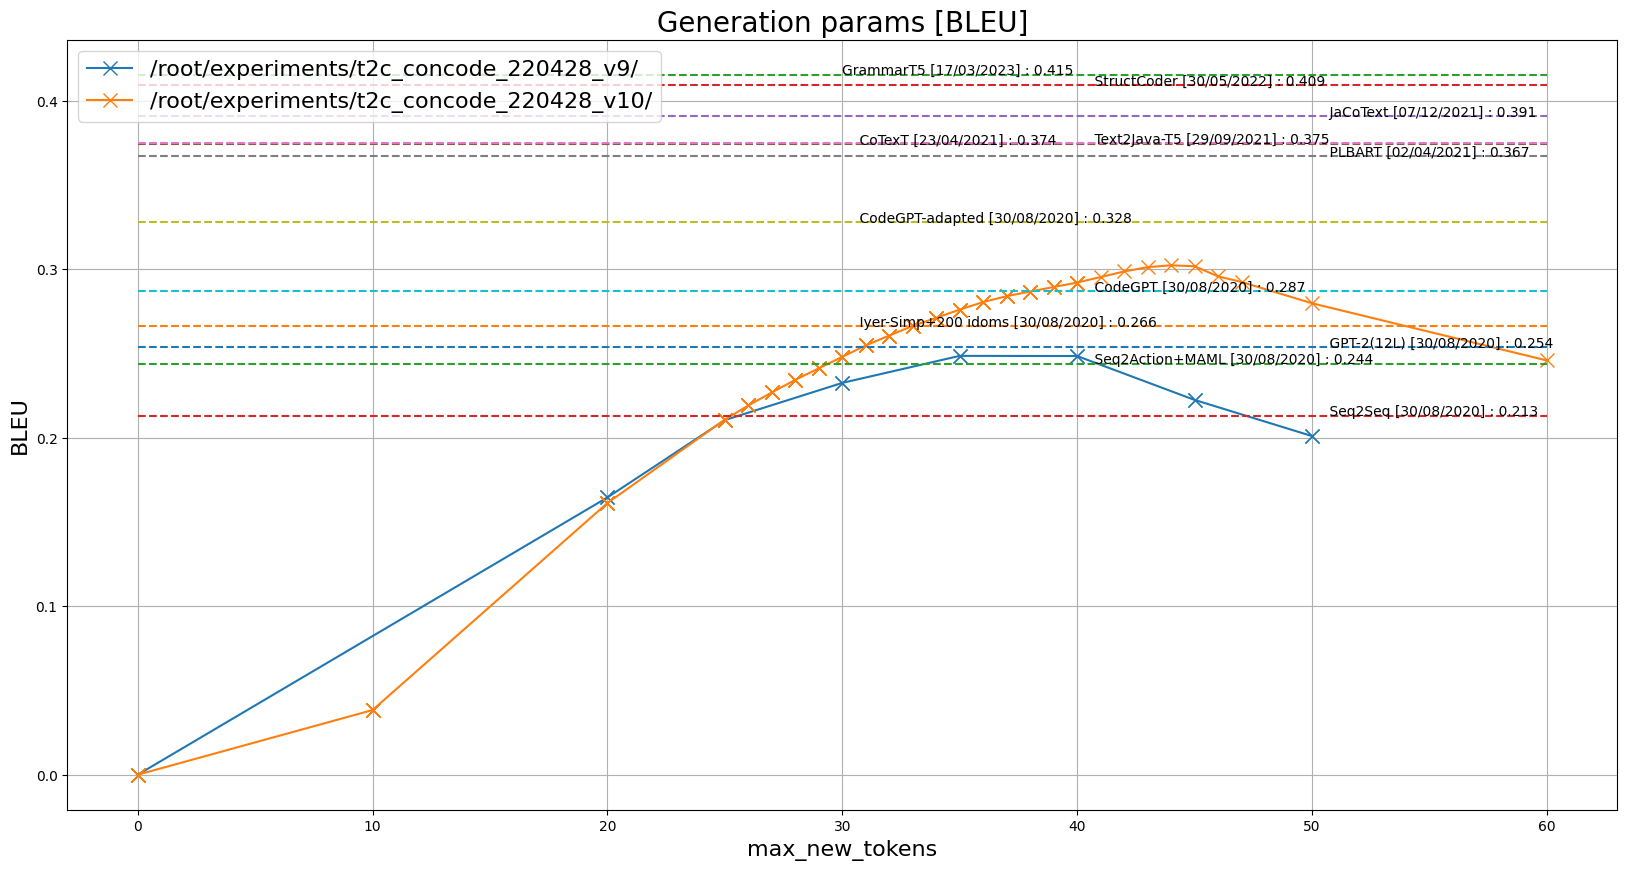

In [39]:
data = {experiment_name: pd.read_csv(experiment_name+"/metrics.csv"),
        "/root/experiments/t2c_concode_220428_v10/": pd.read_csv("/root/experiments/t2c_concode_220428_v10/metrics.csv"
                                                                )
       }
draw_metrics_compare_with_glue(data)

TypeError: unhashable type: 'list'

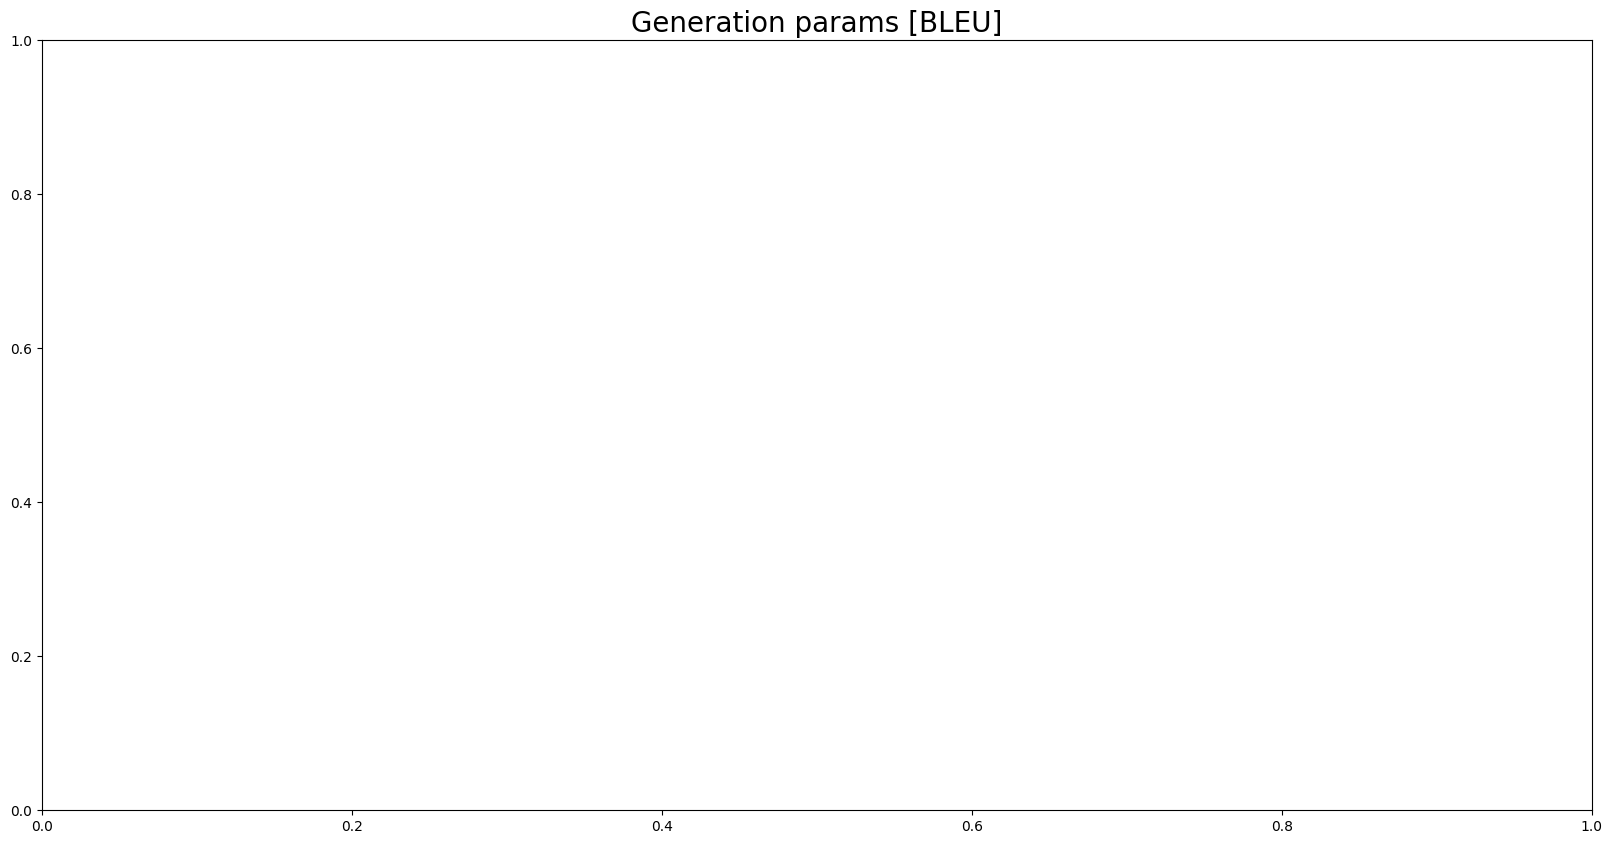

28 28 28


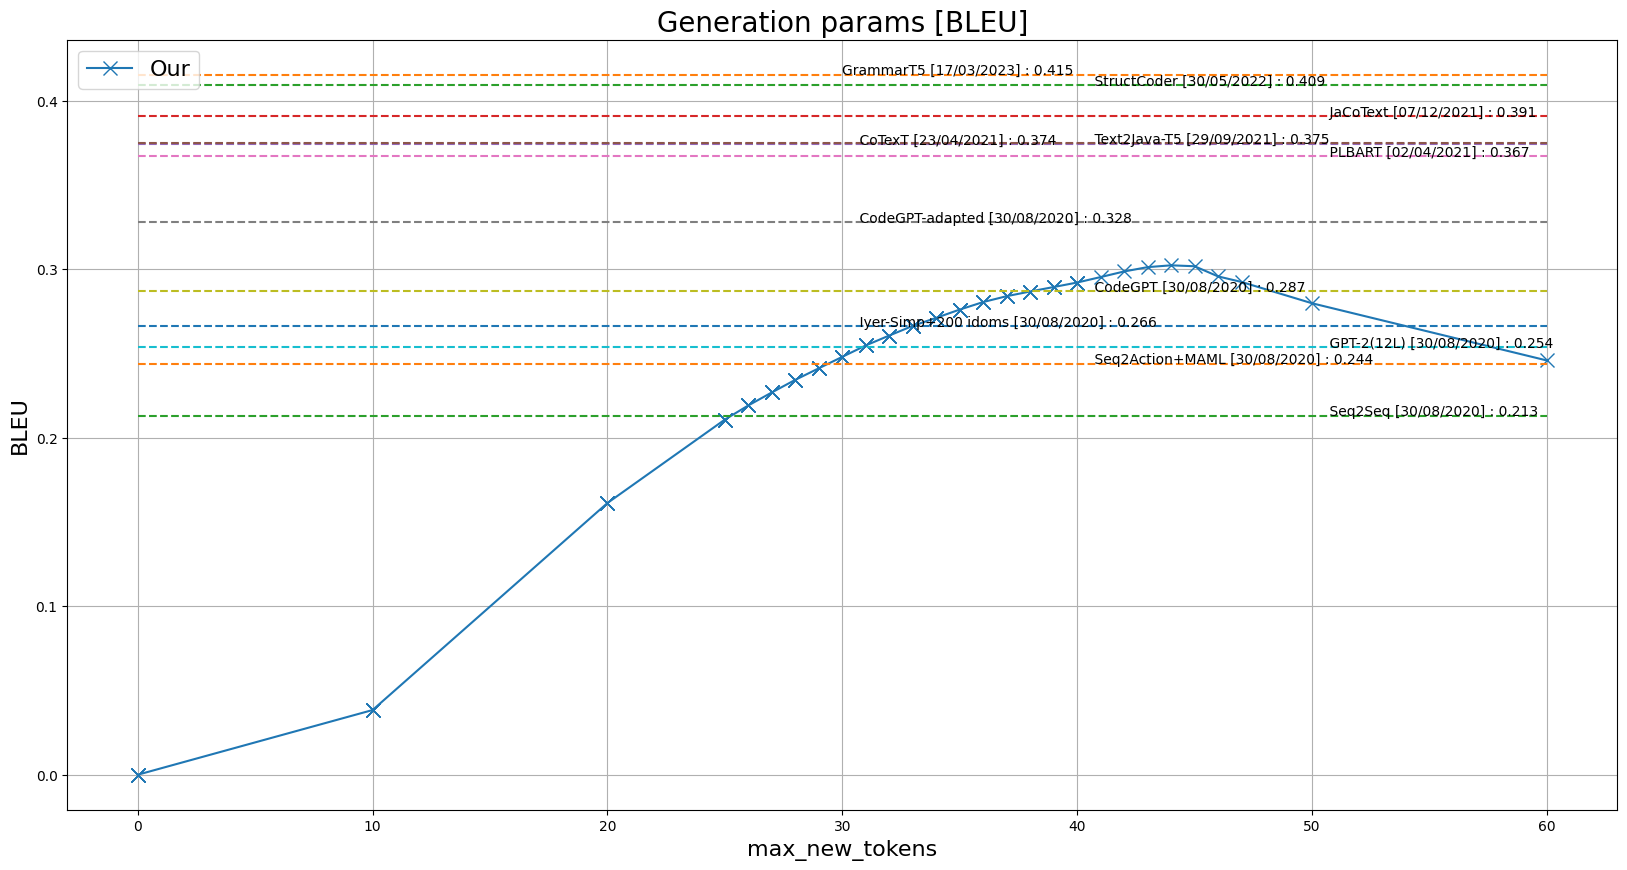

In [89]:
draw_metrics_compare_with_glue(data)

28 3 28


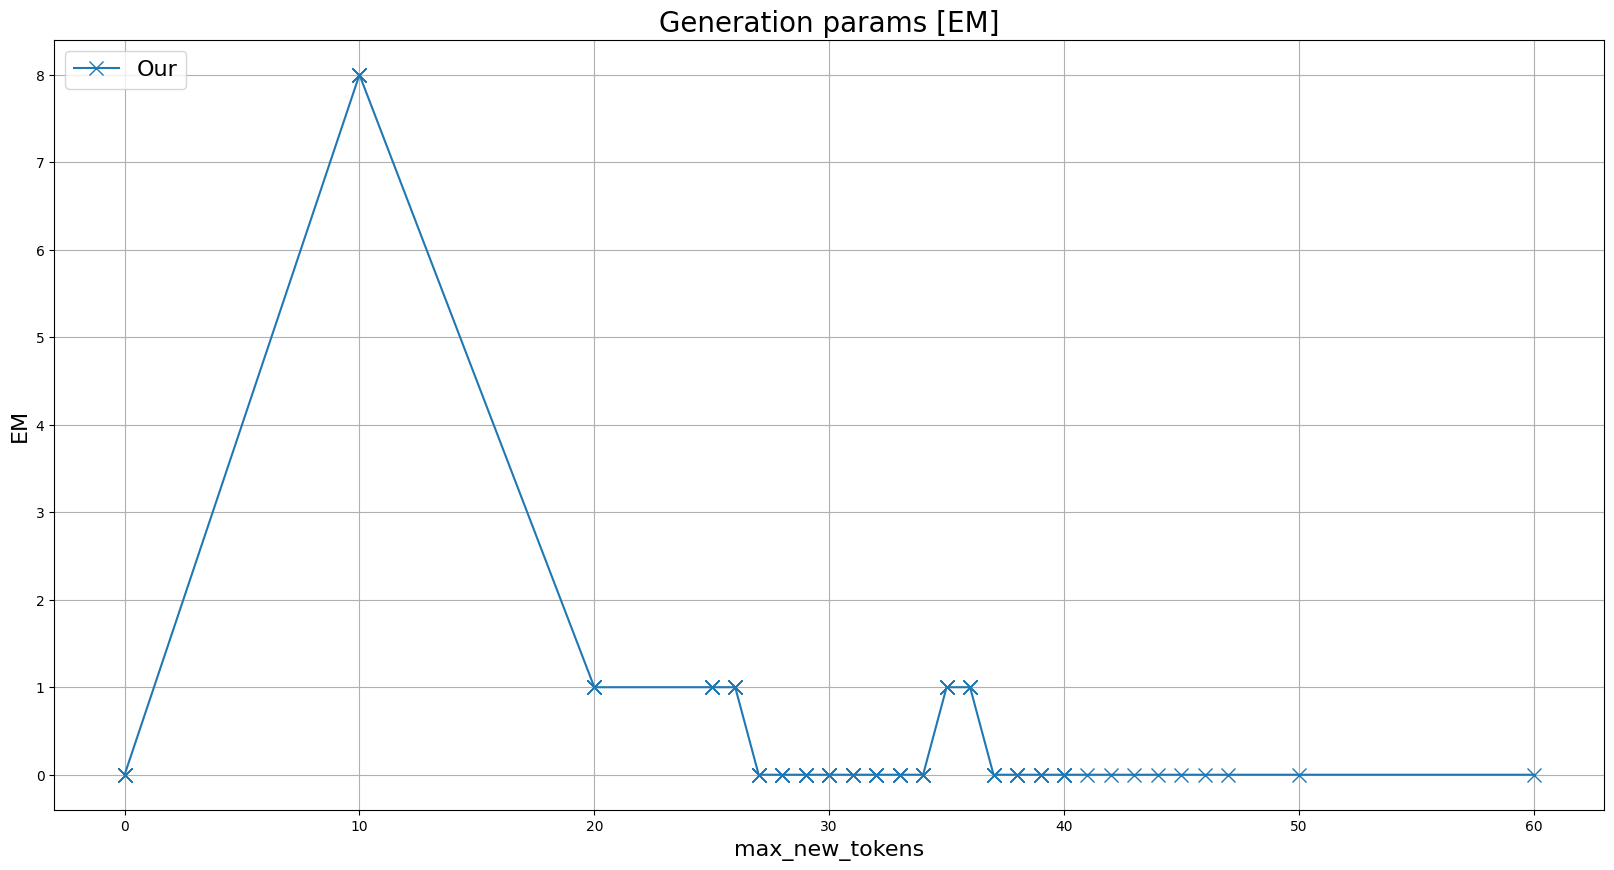

28 28 28


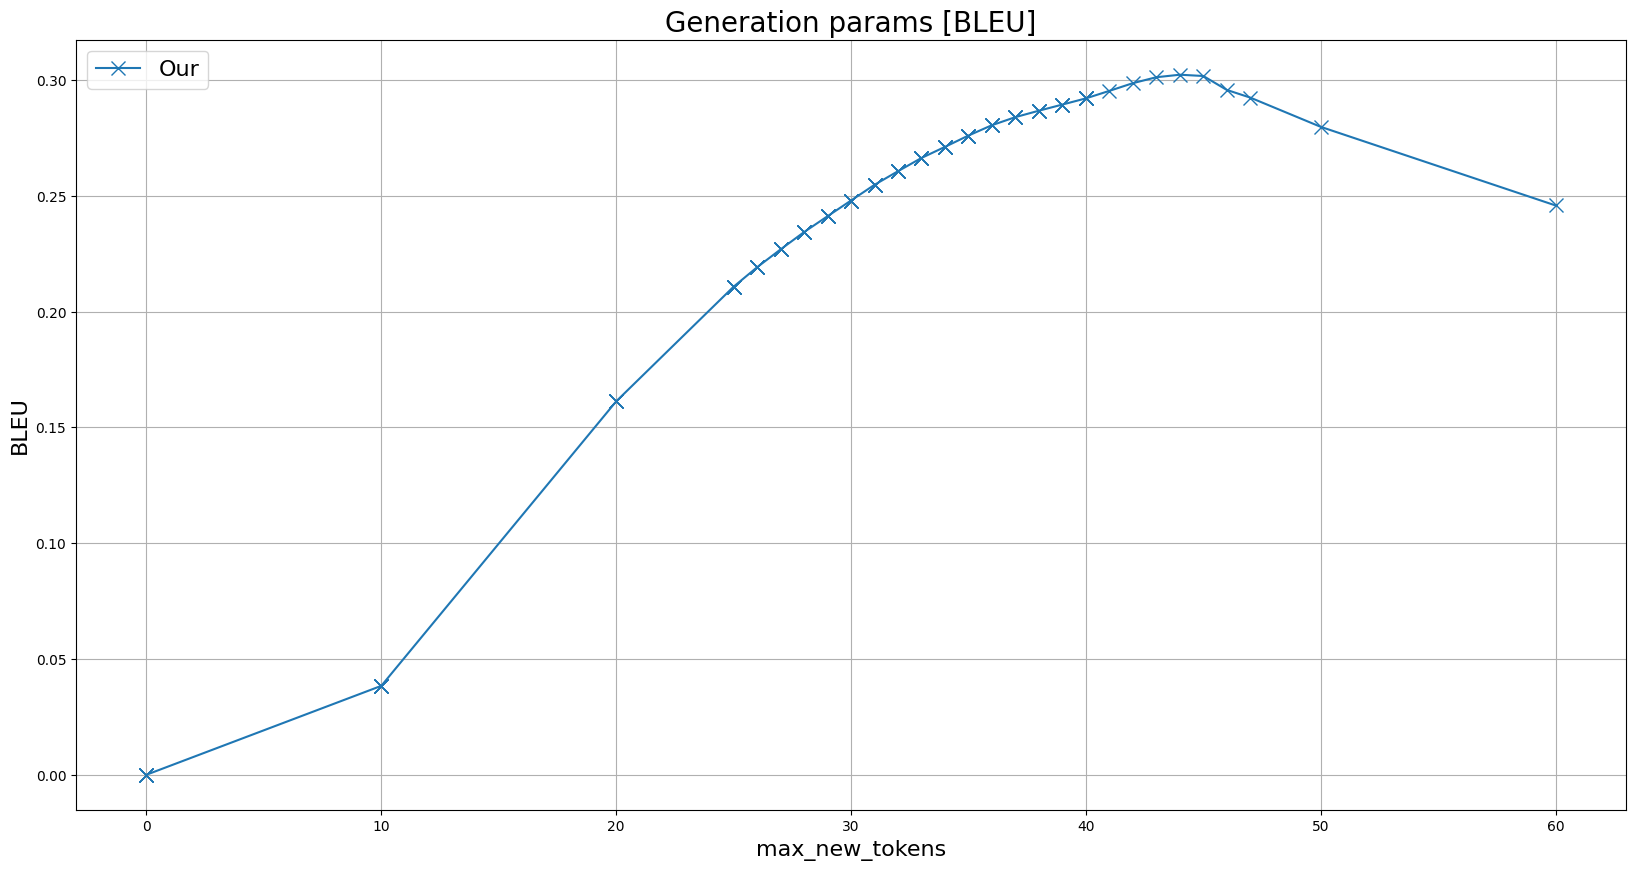

28 24 28


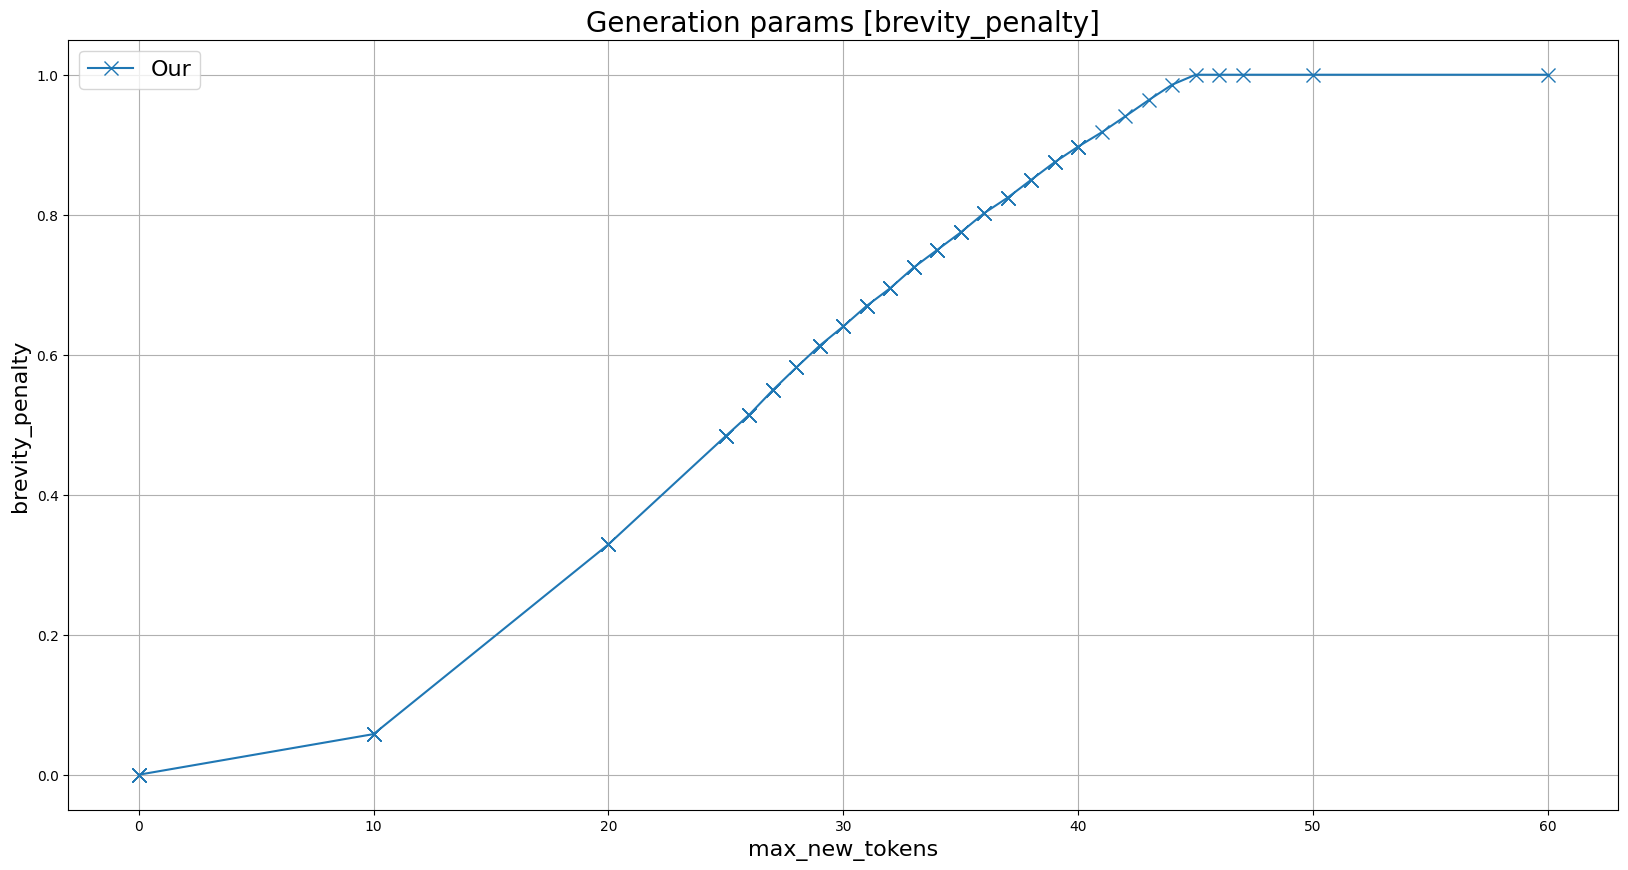

28 28 28


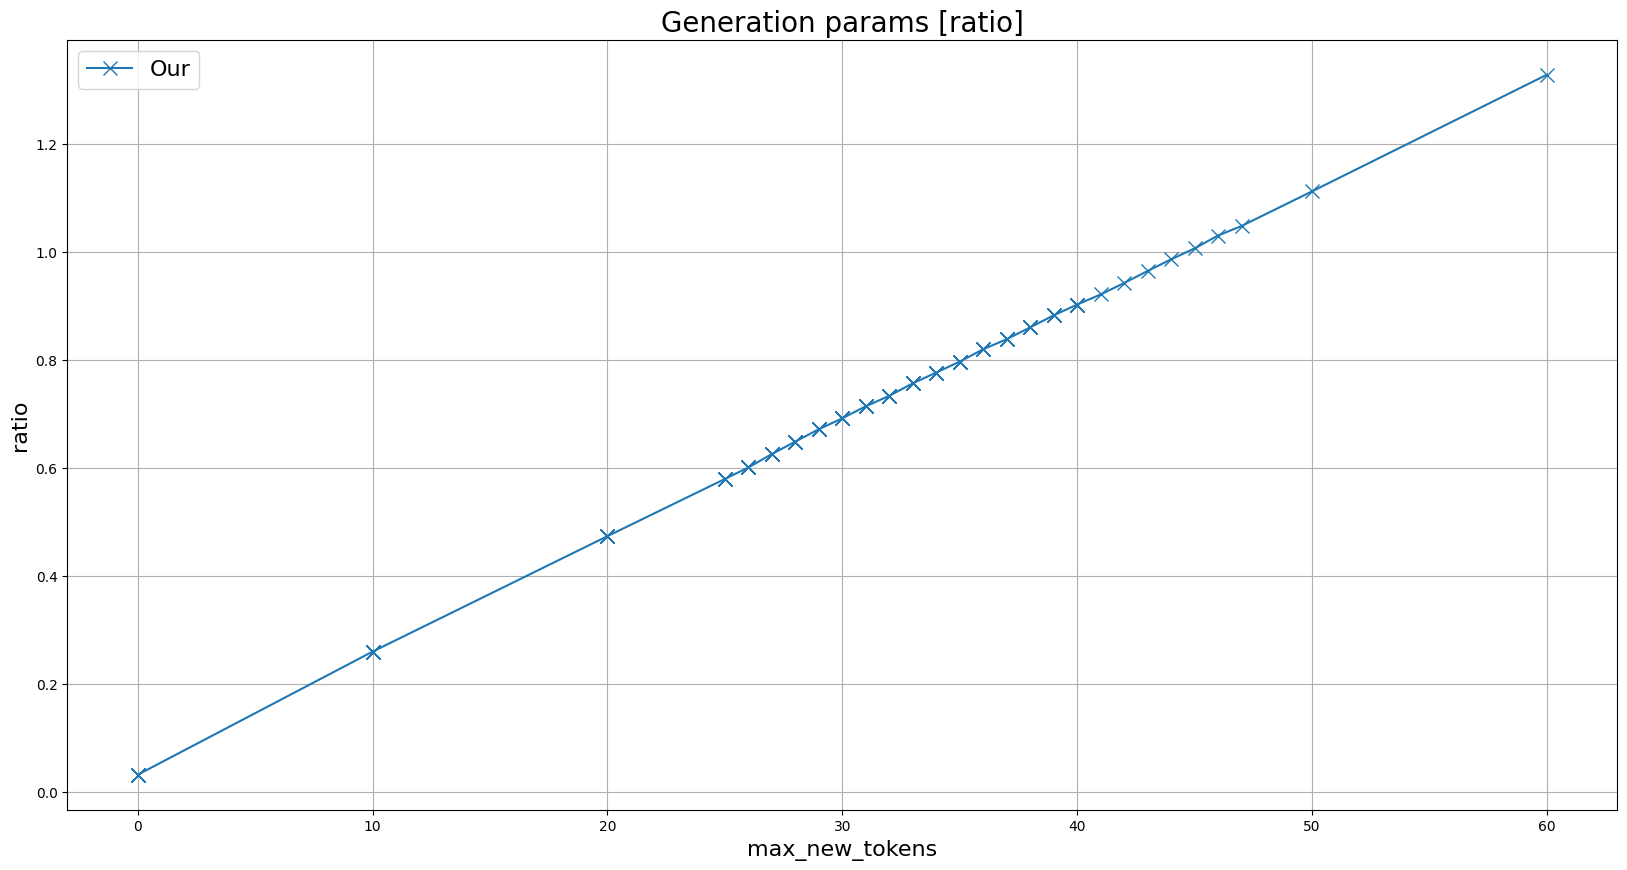

28 28 28


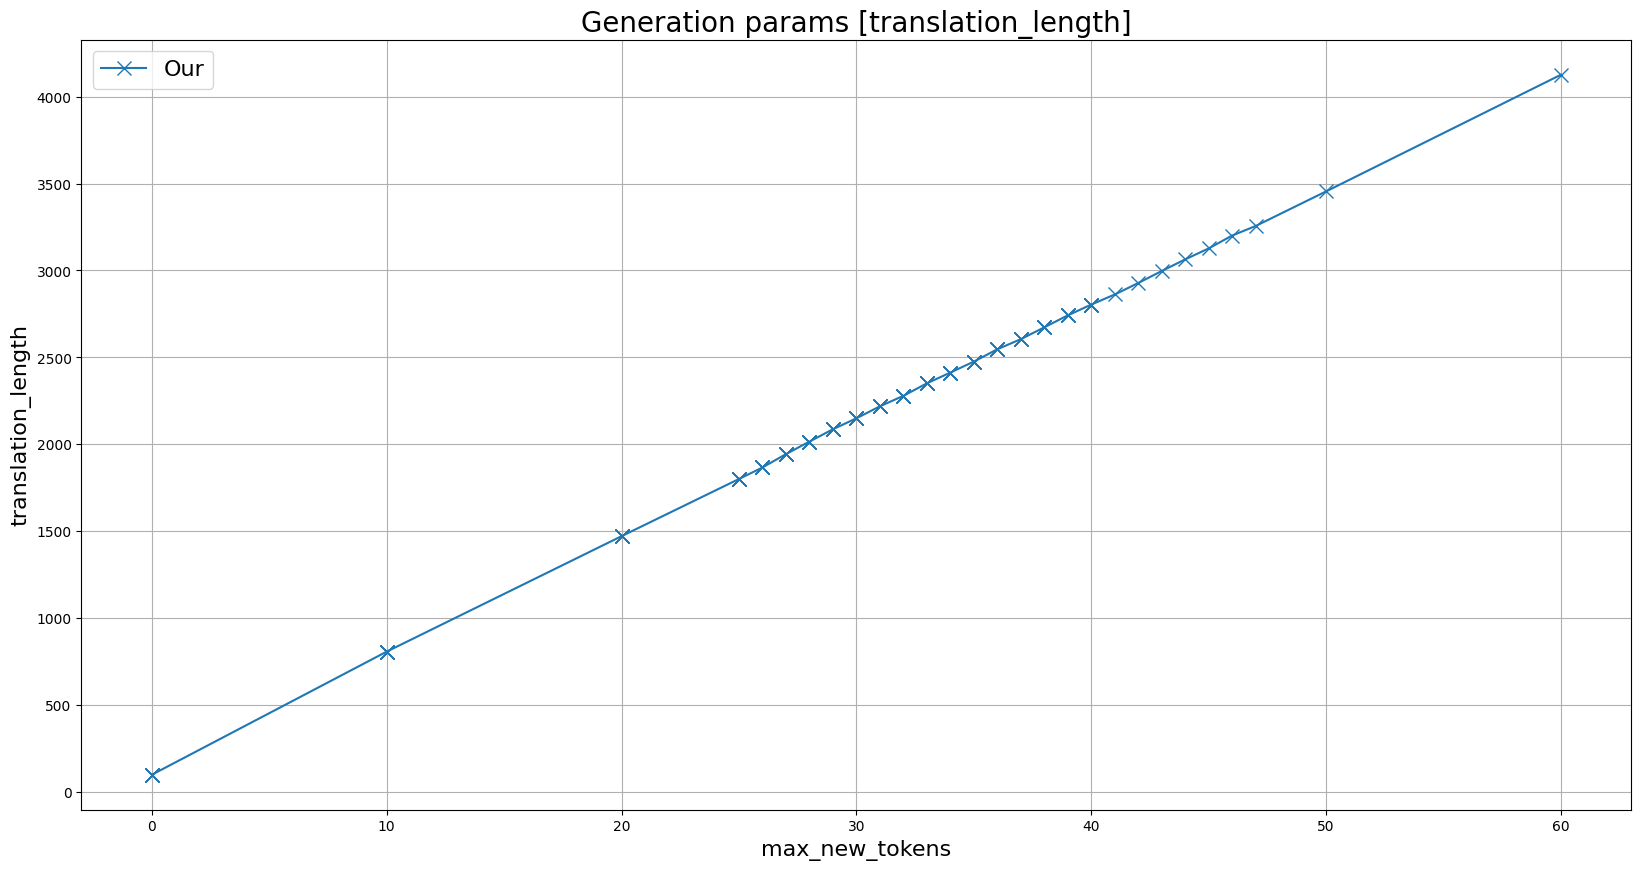

28 1 28


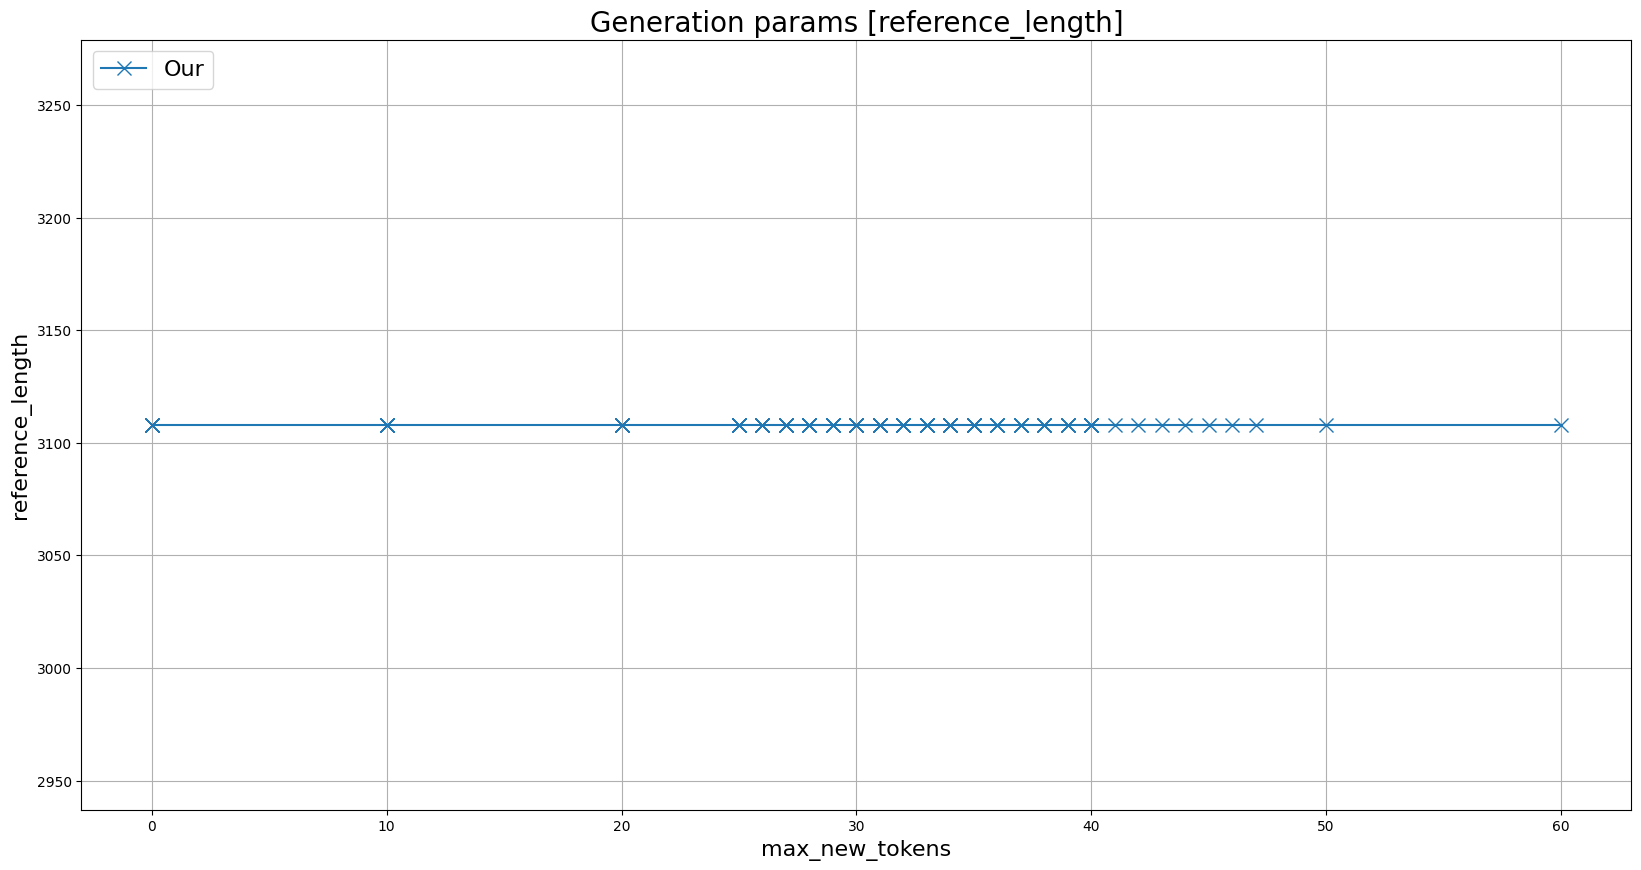

28 28 28


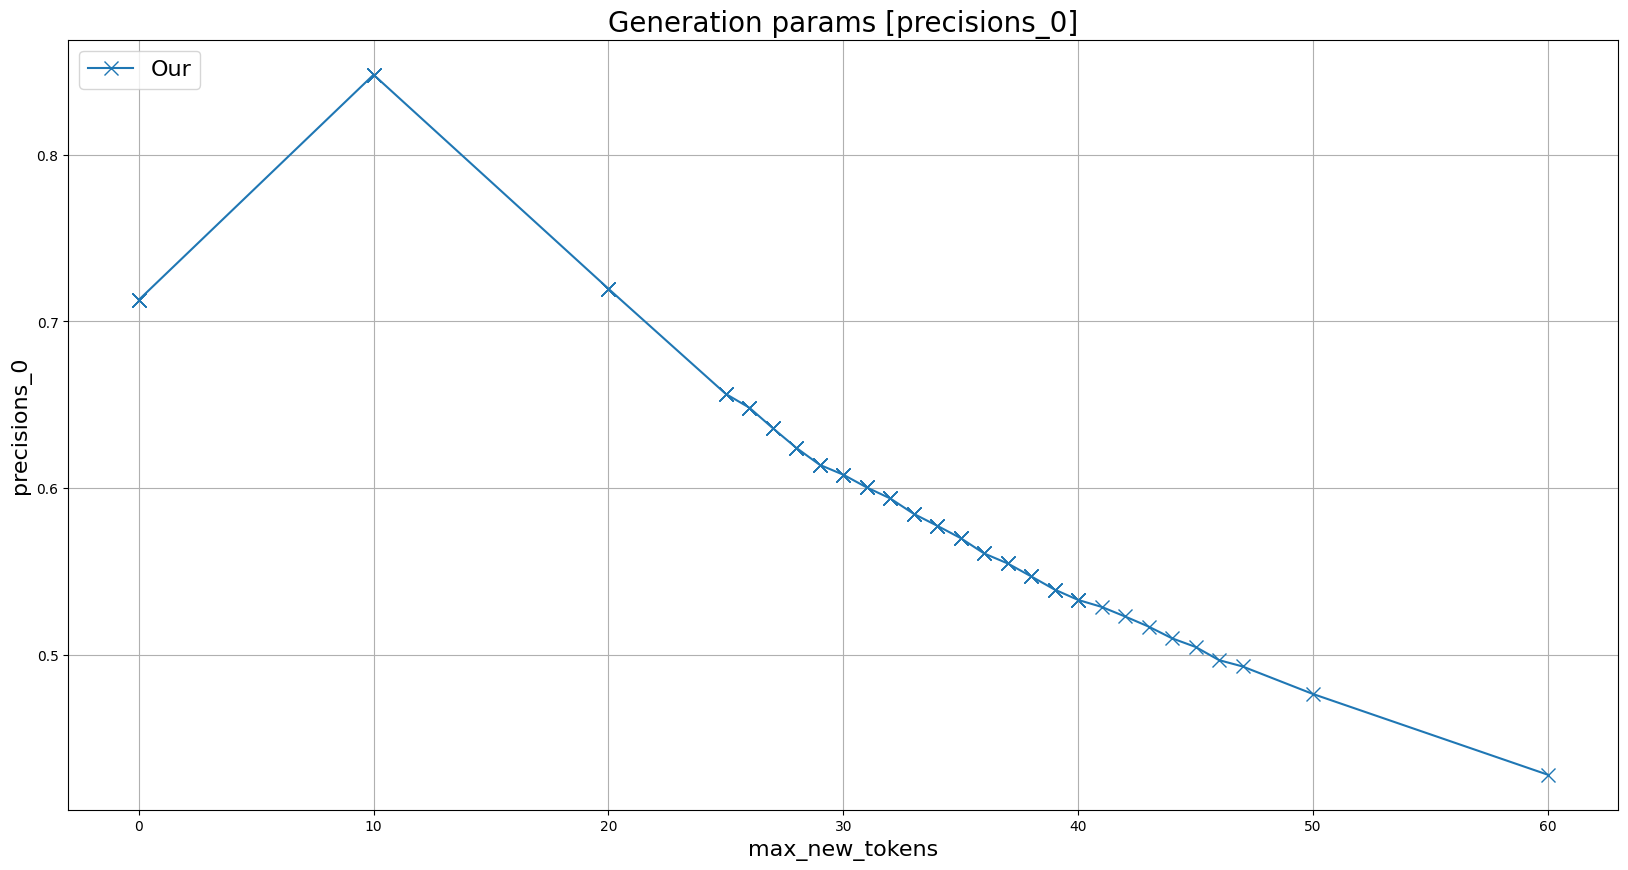

28 28 28


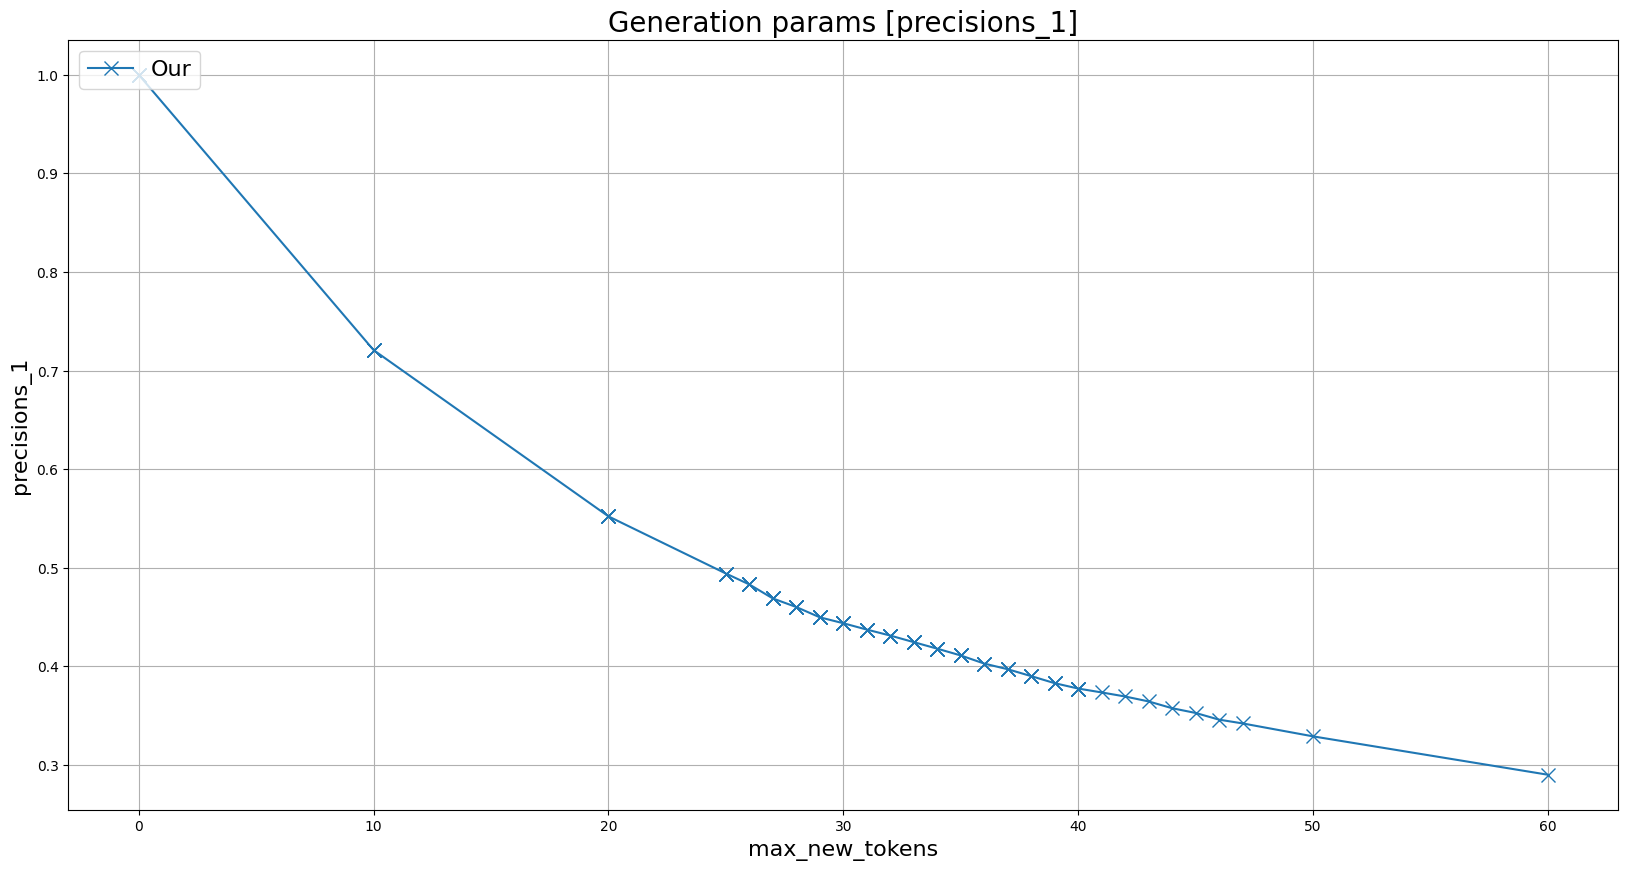

28 28 28


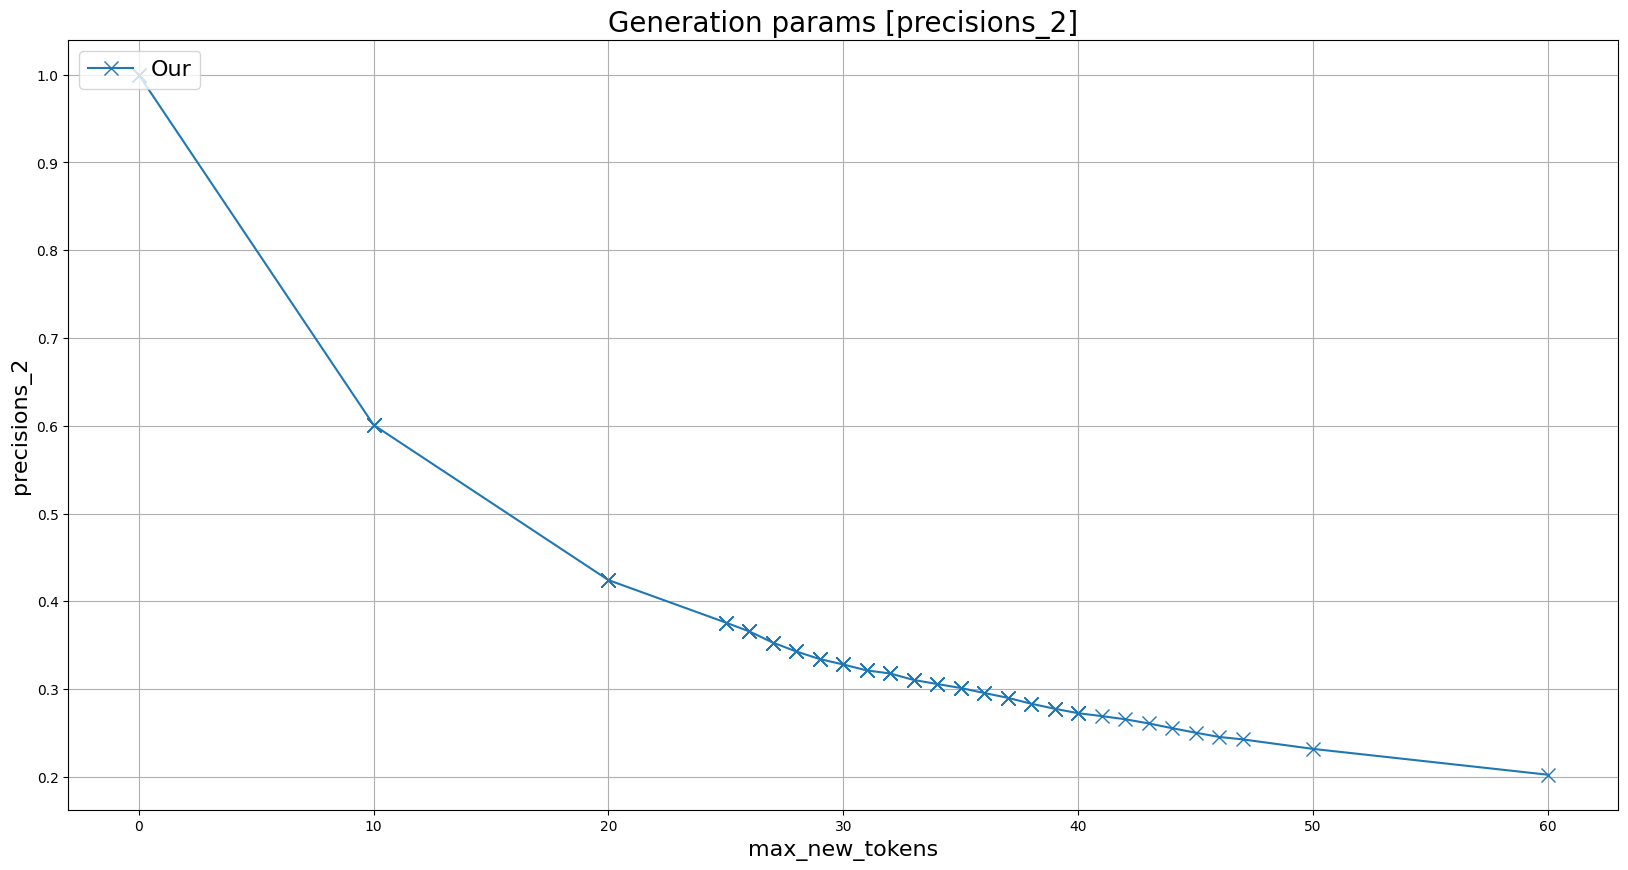

28 28 28


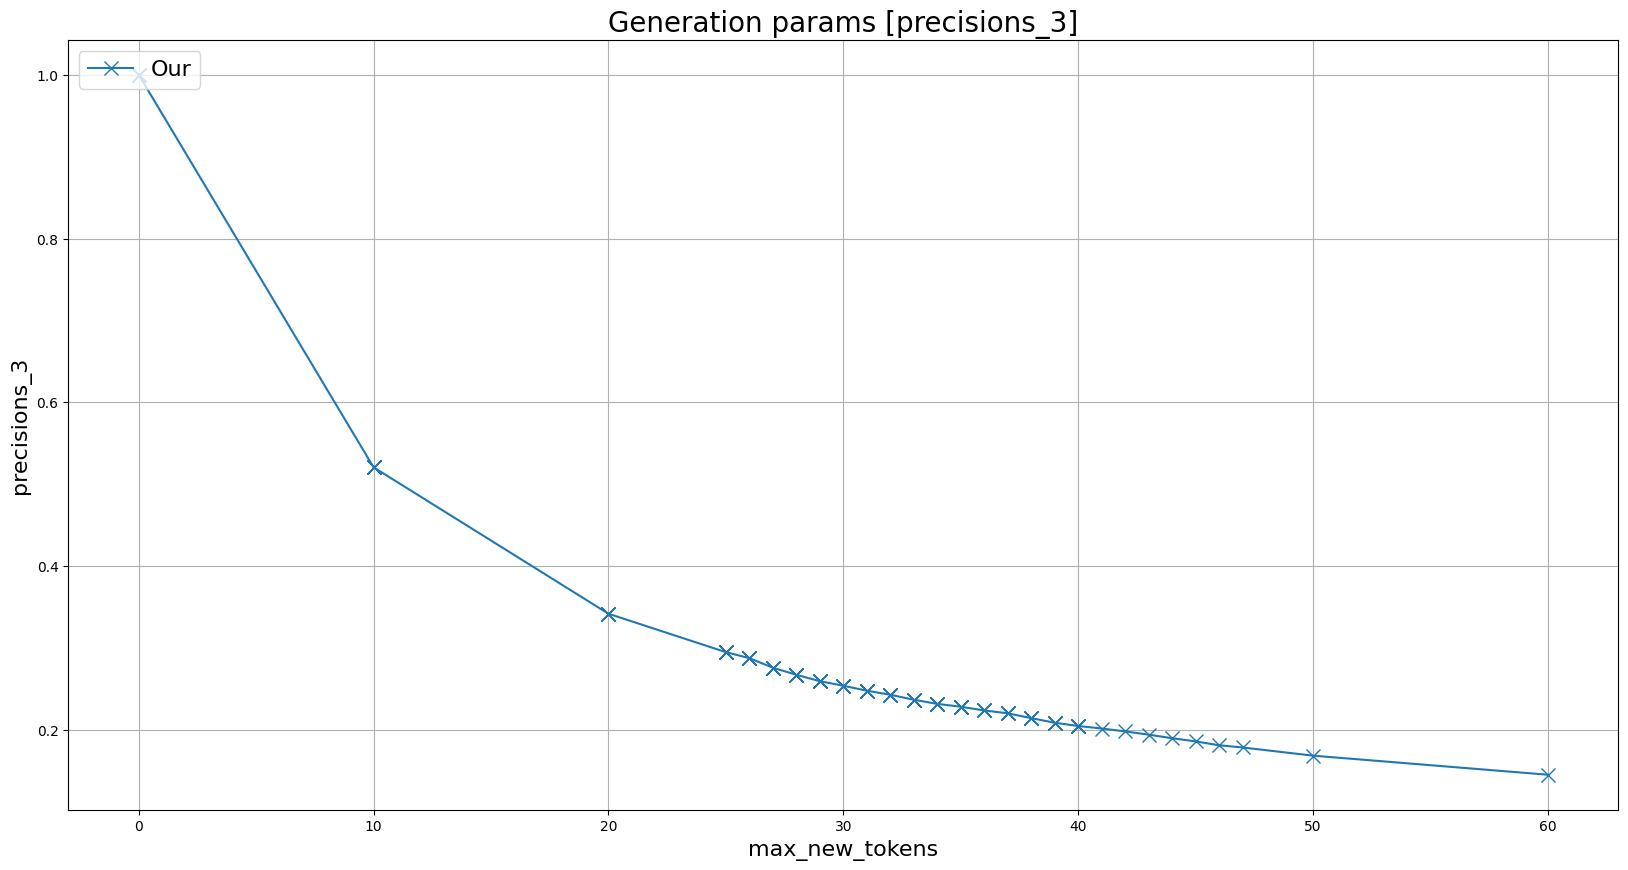

In [99]:
draw_all_metrics(data, param_name="max_new_tokens")

28 3 28


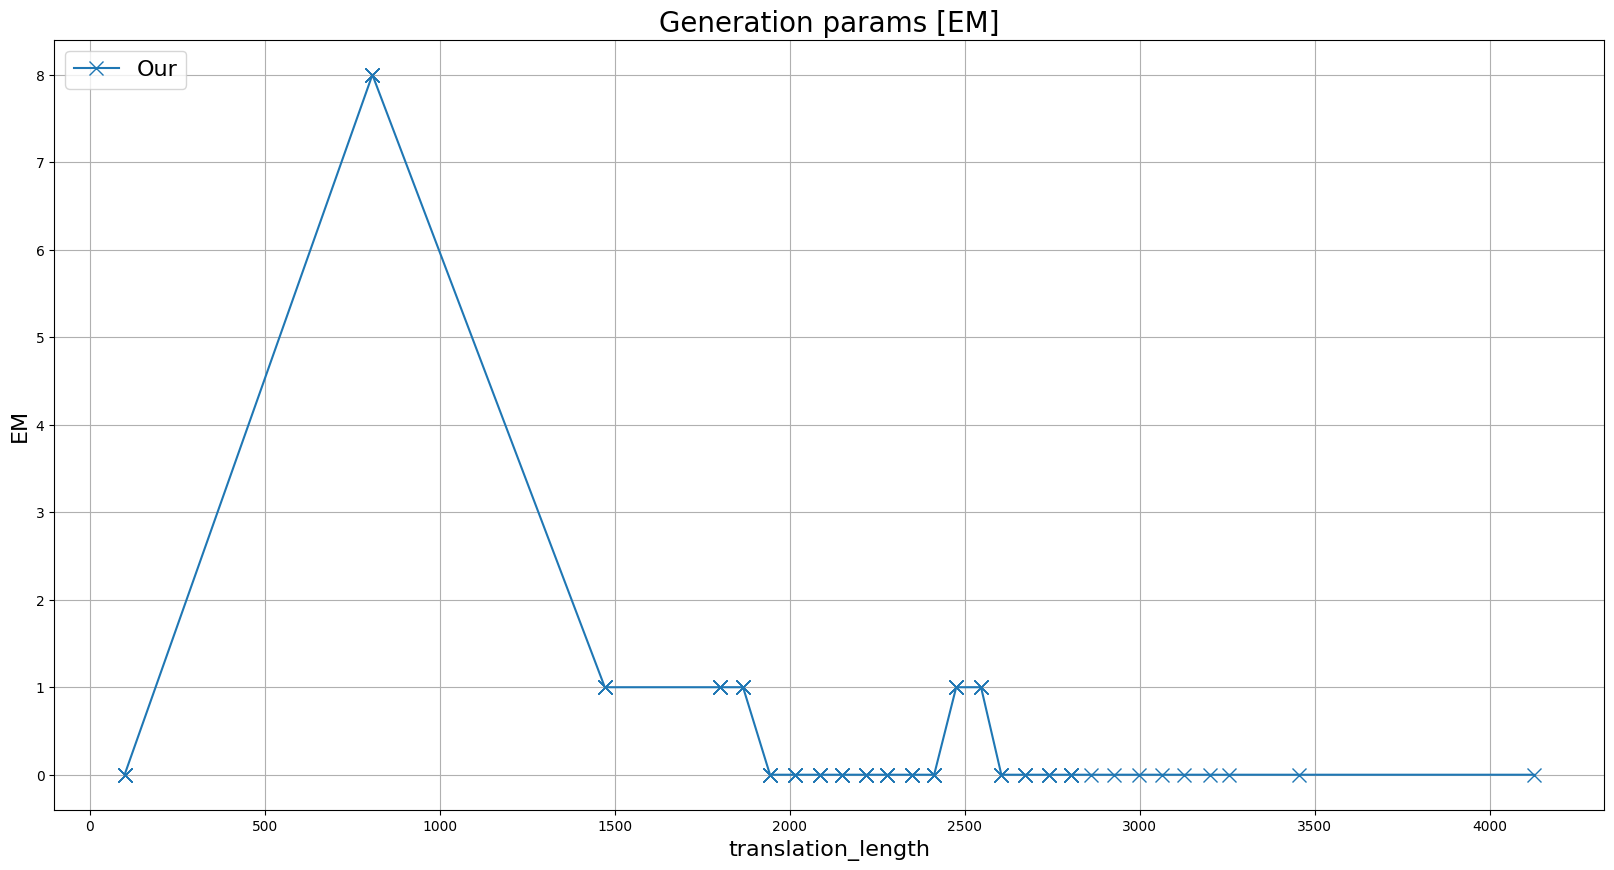

28 28 28


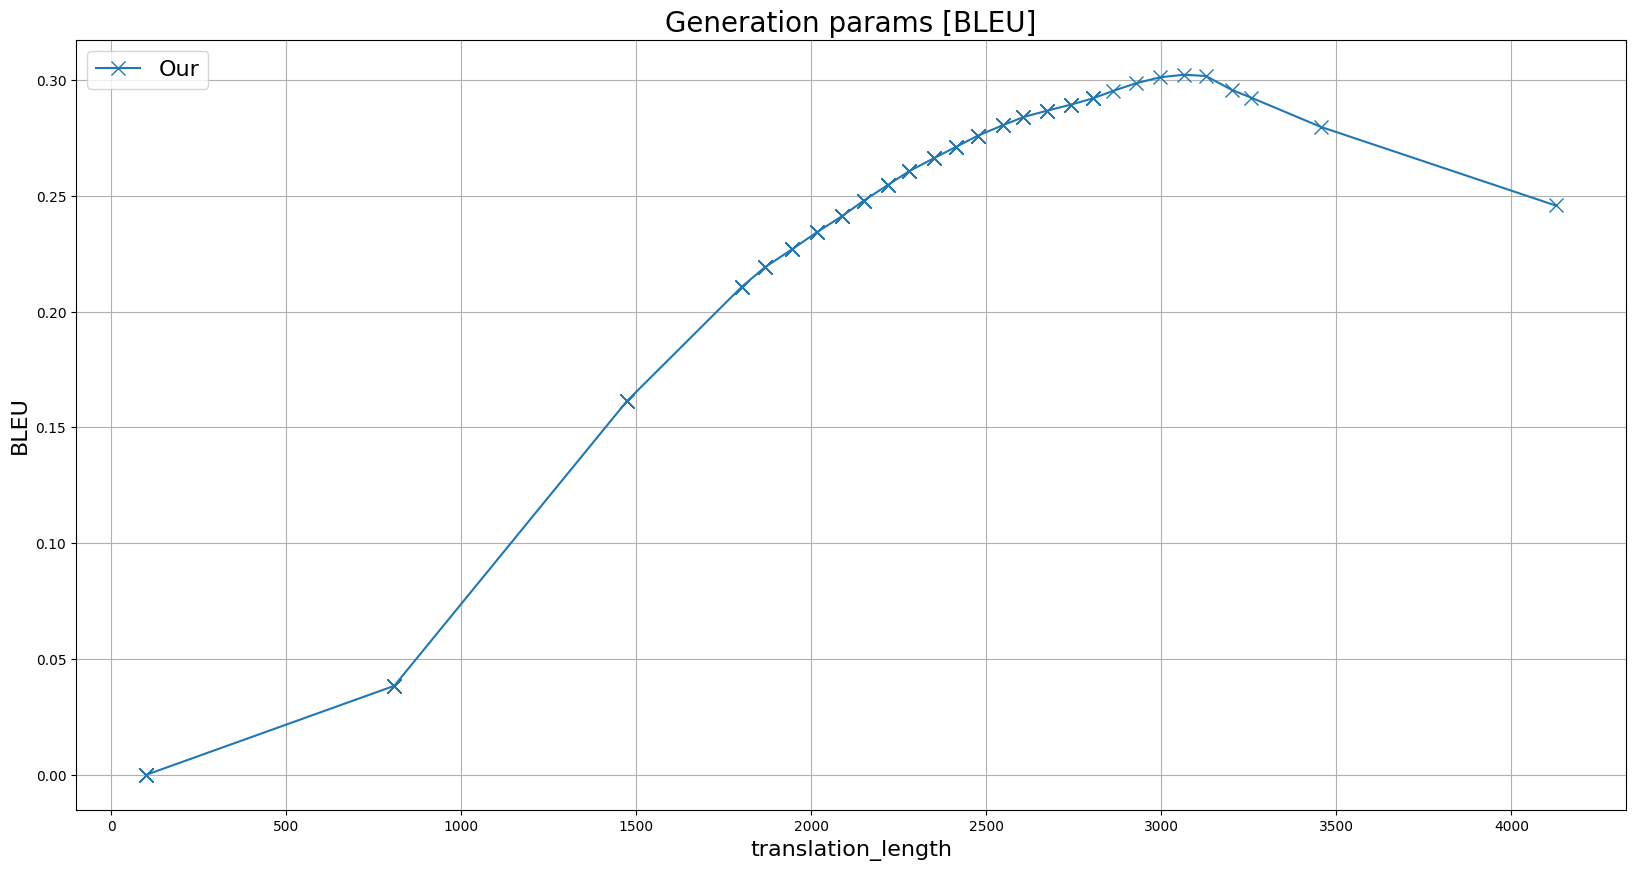

28 24 28


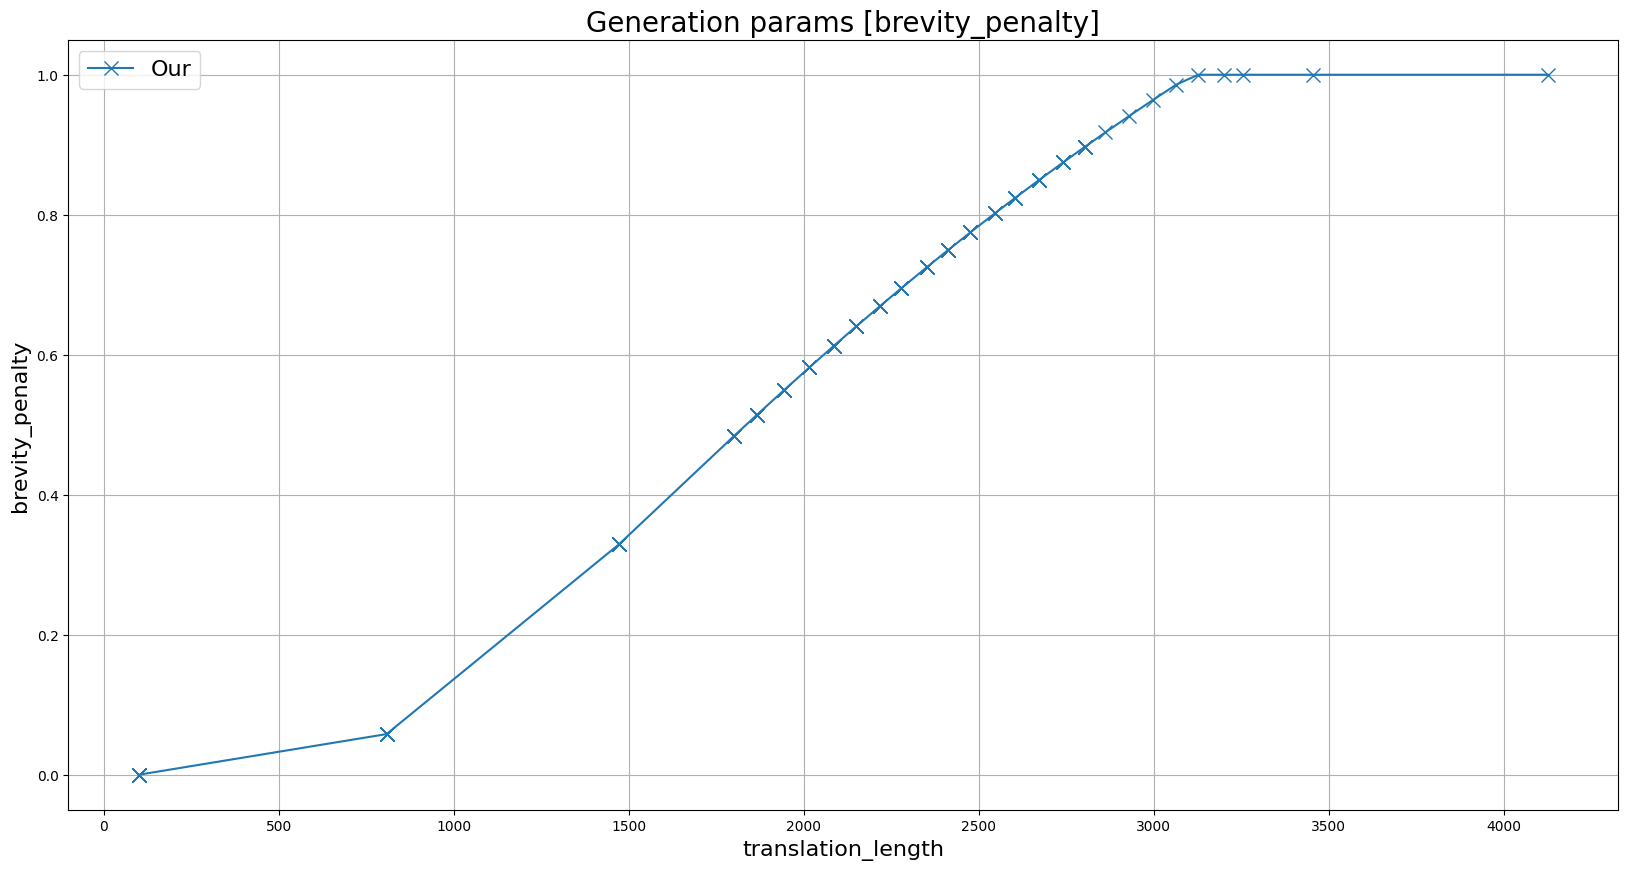

28 28 28


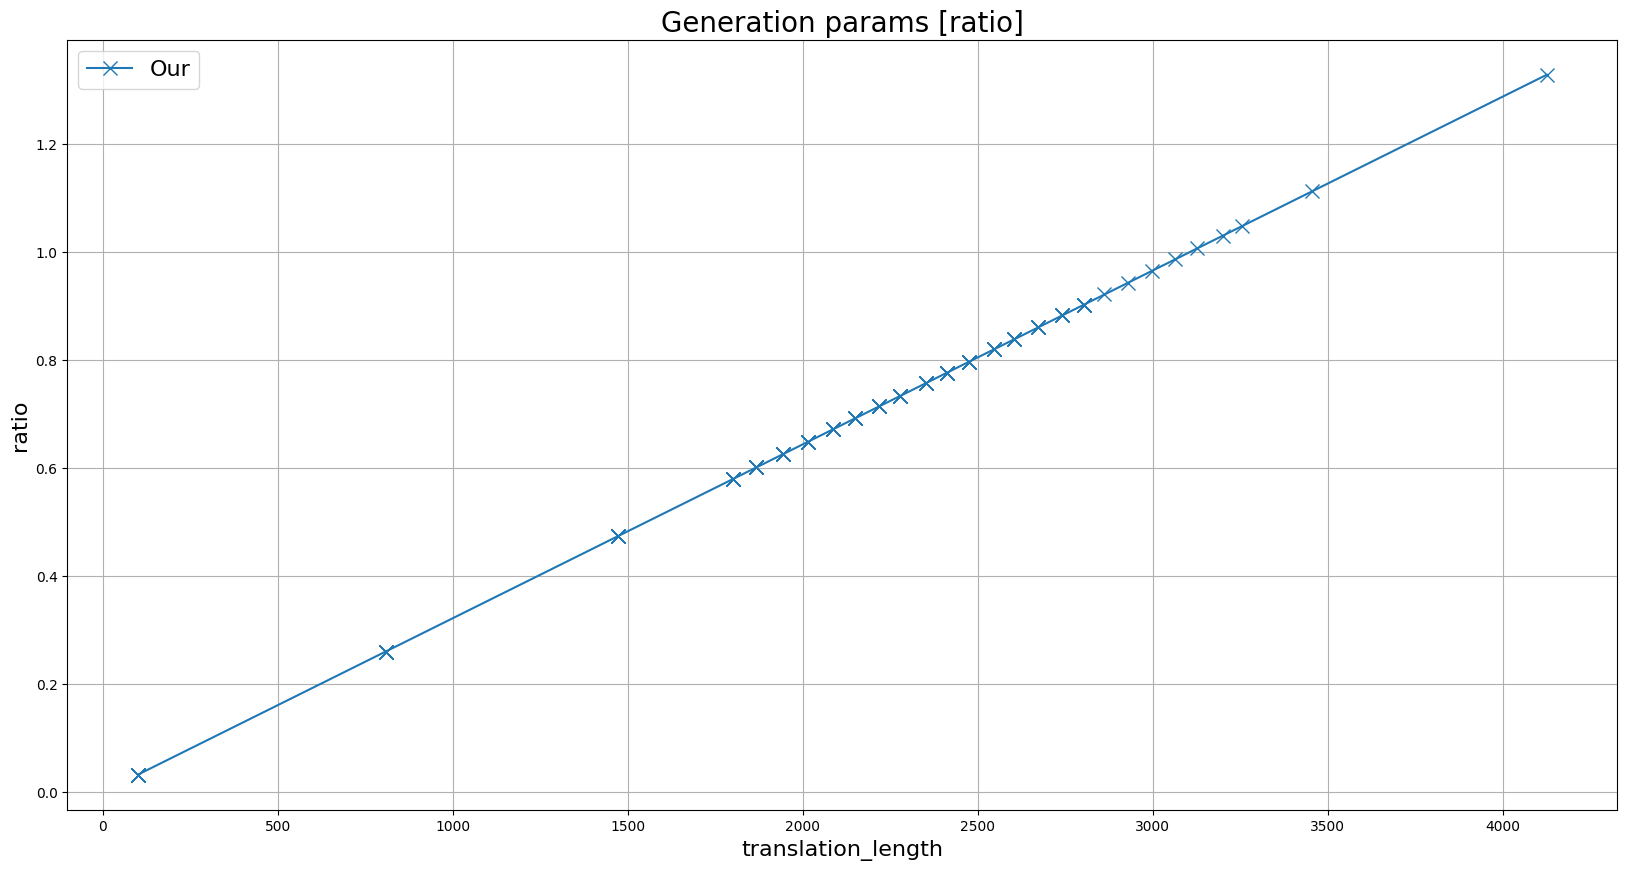

28 1 28


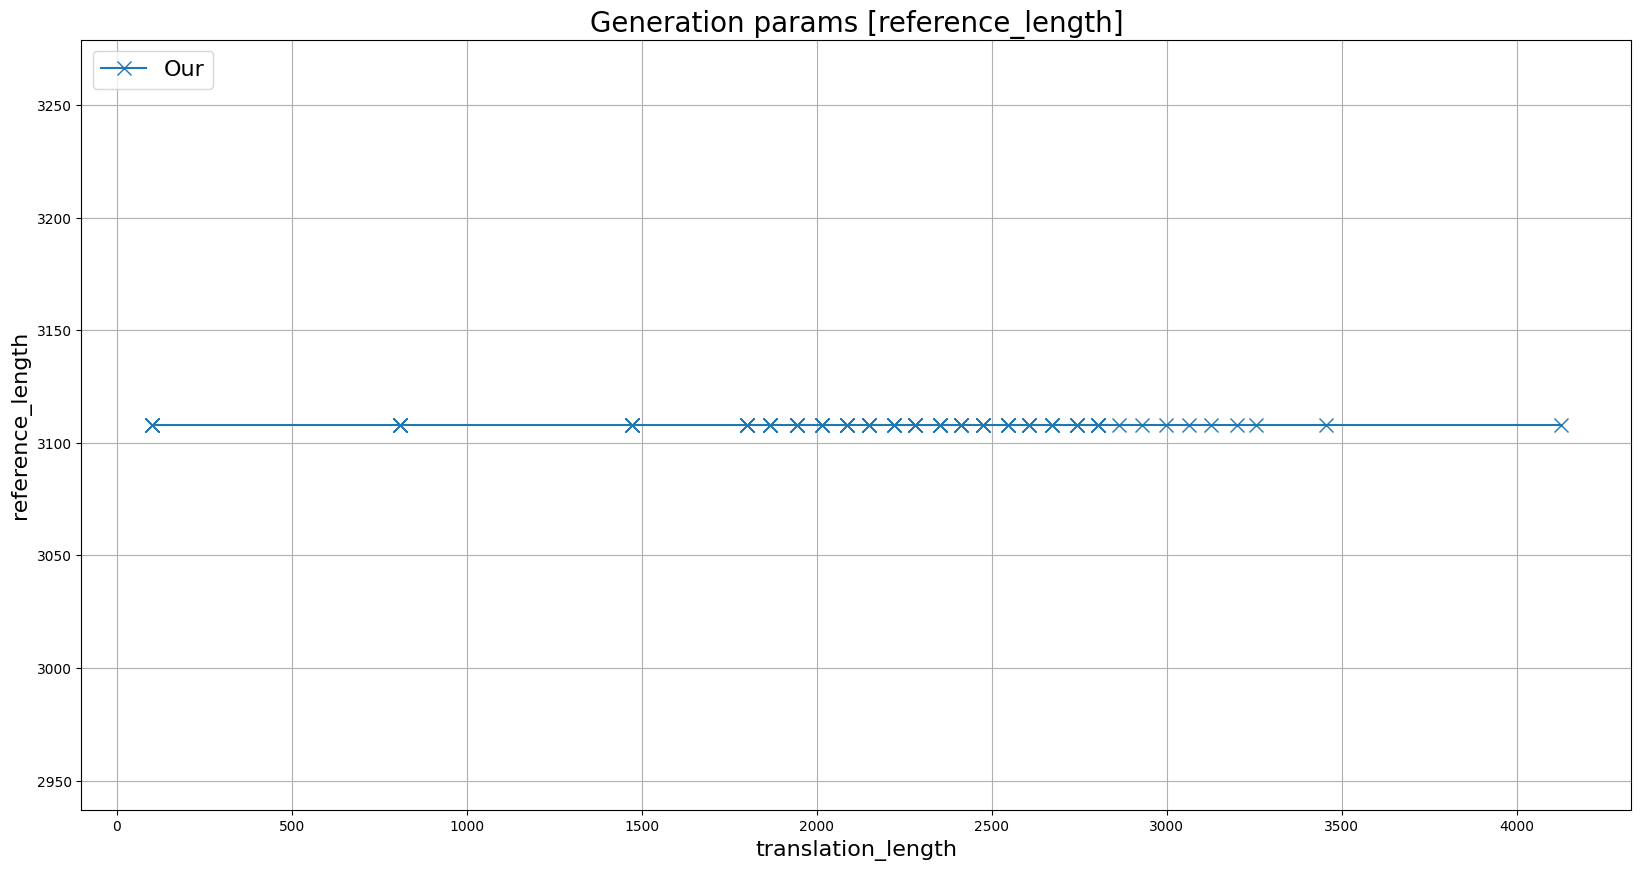

28 28 28


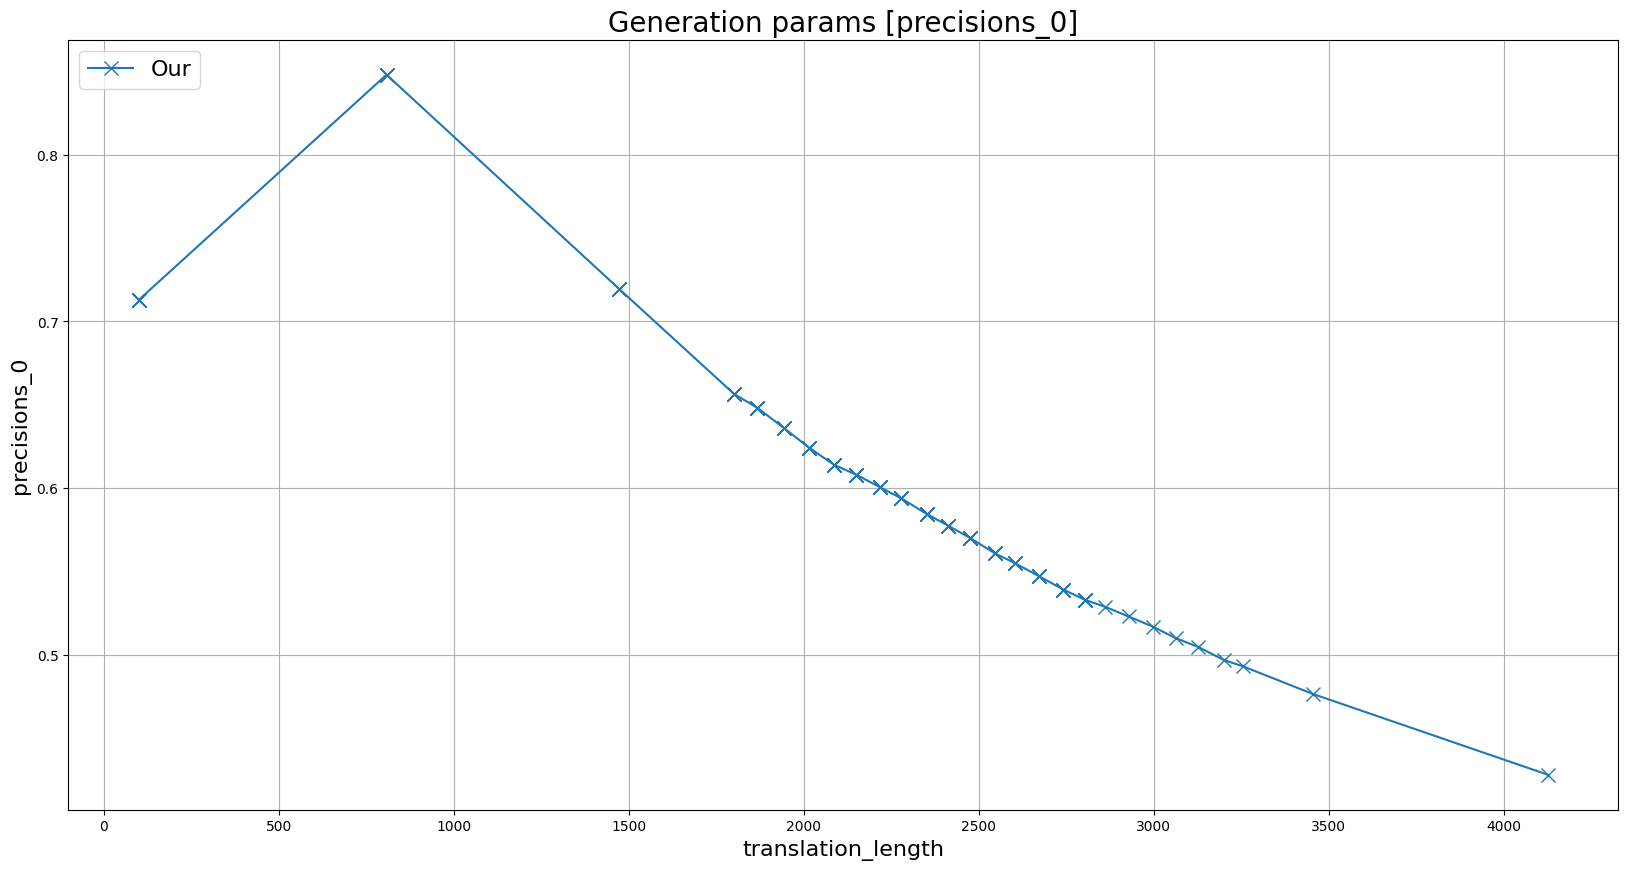

28 28 28


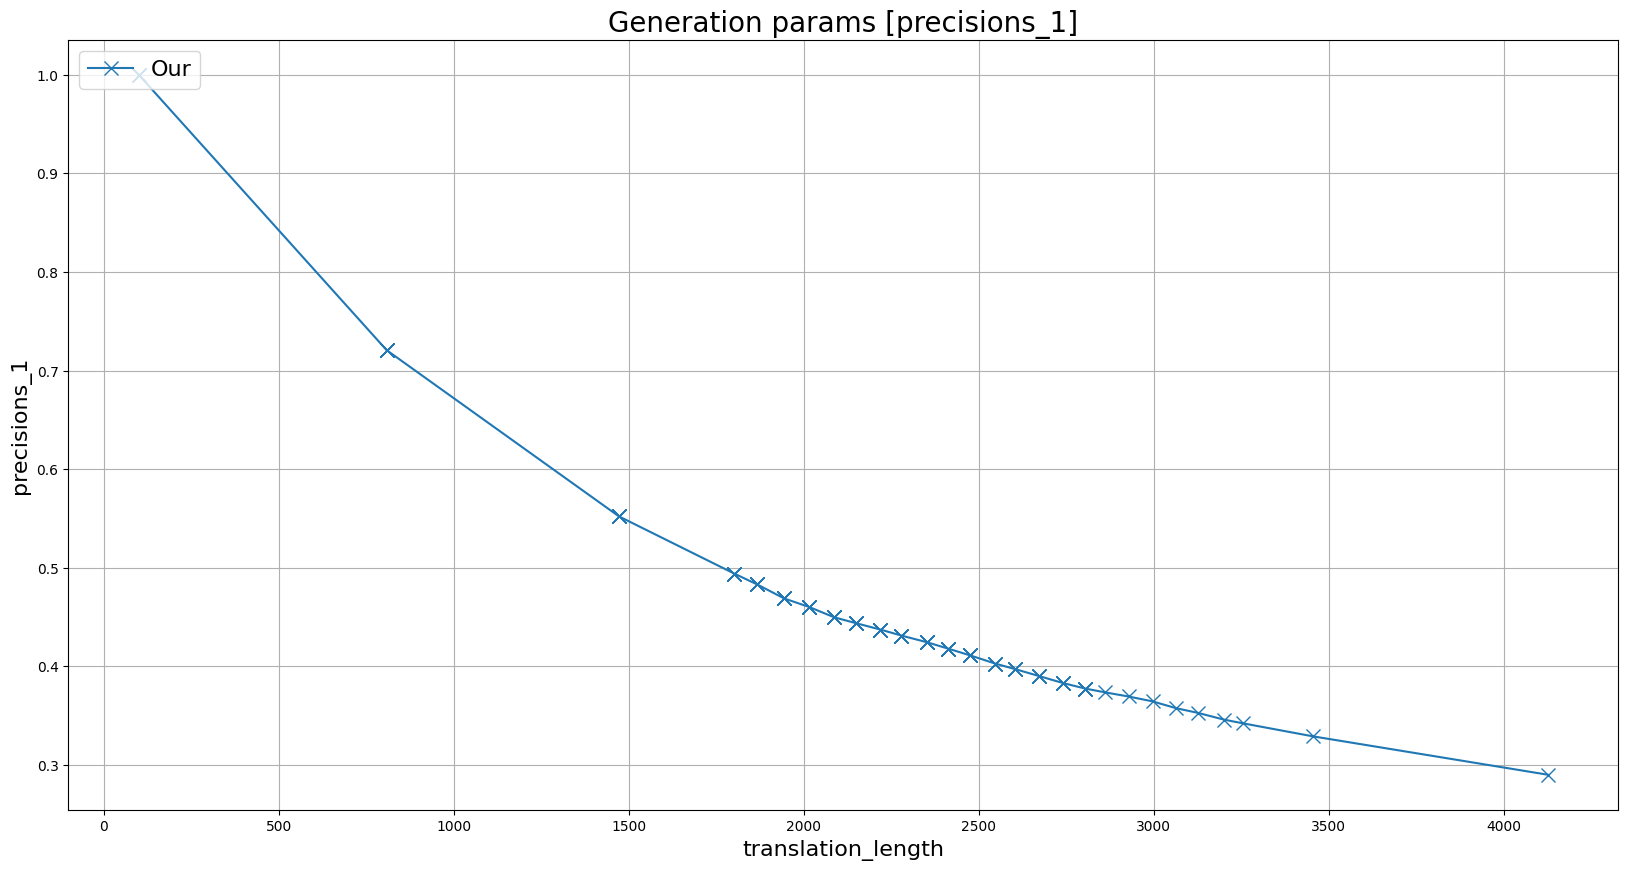

28 28 28


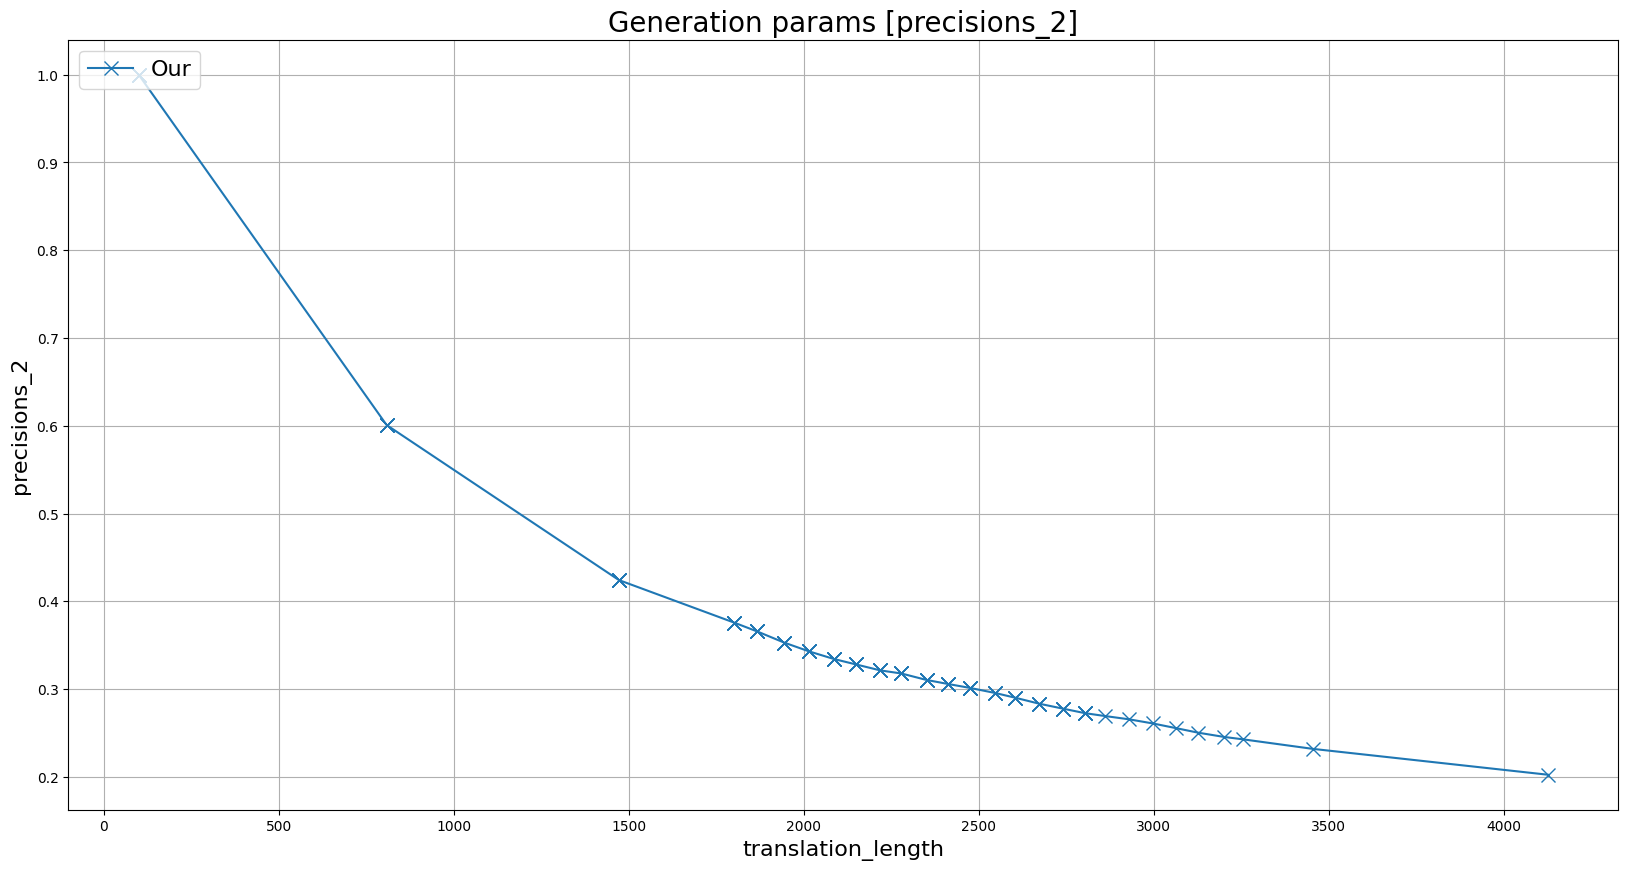

28 28 28


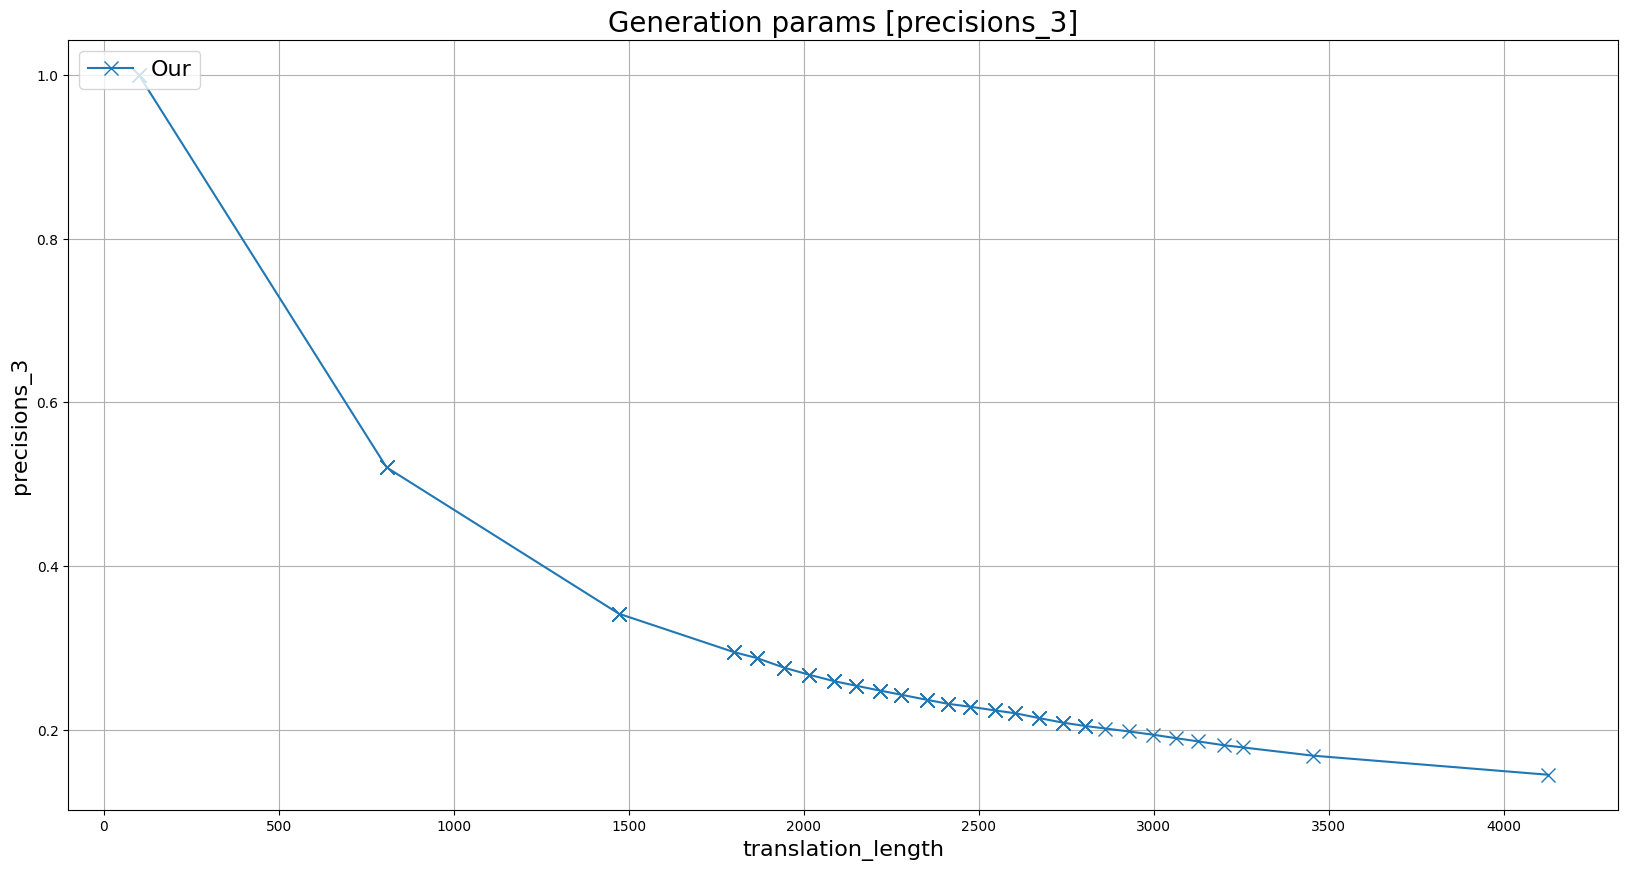

In [103]:
draw_all_metrics(data, param_name="translation_length")

28 3 28


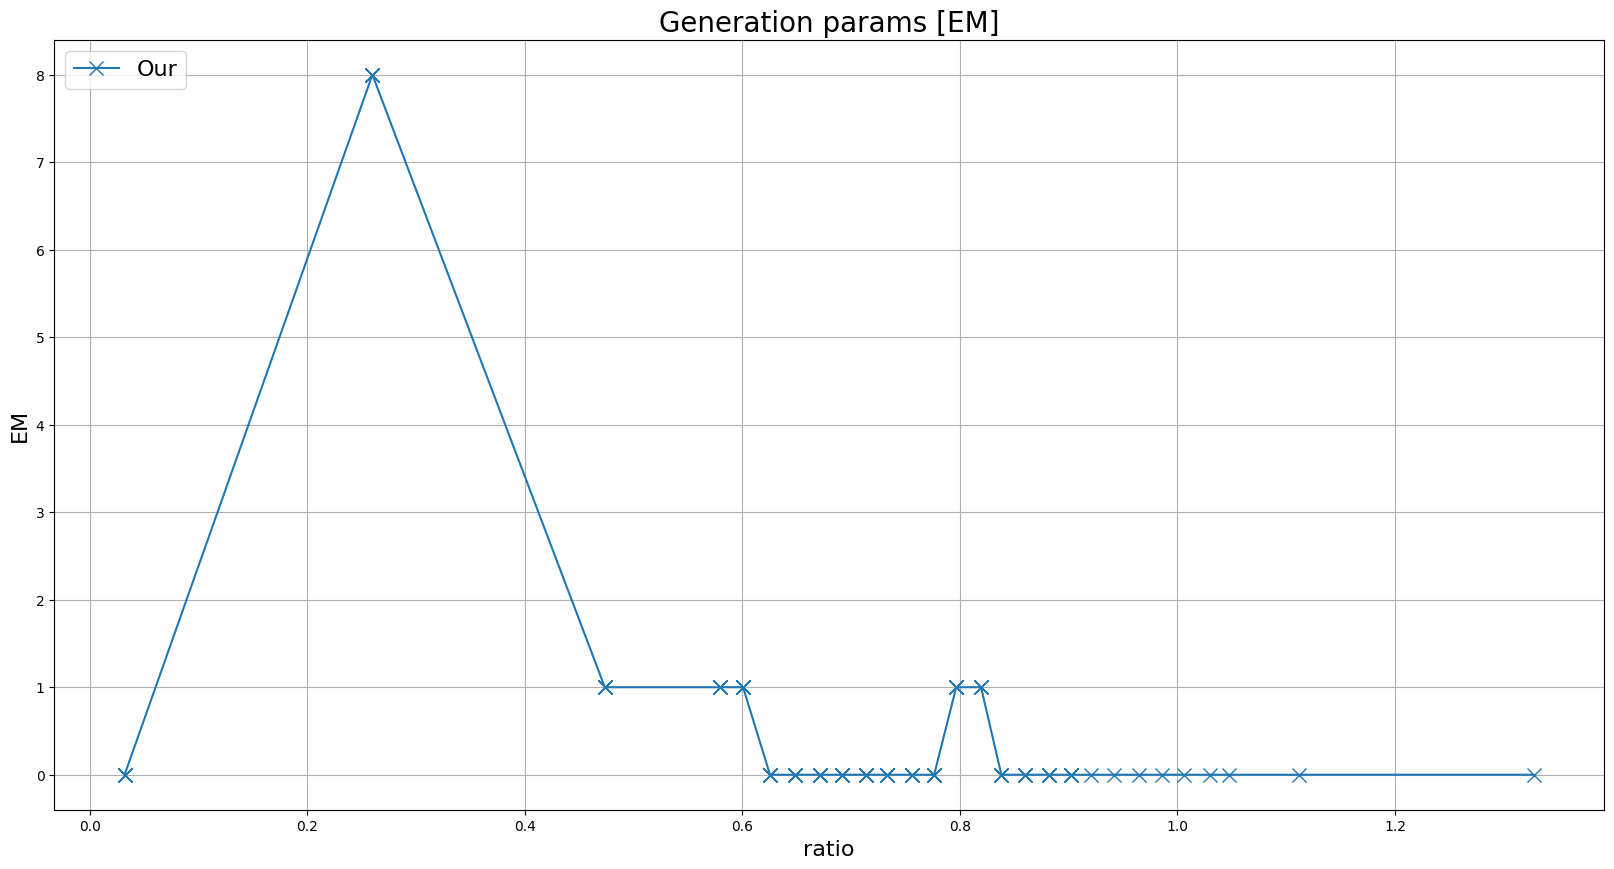

28 28 28


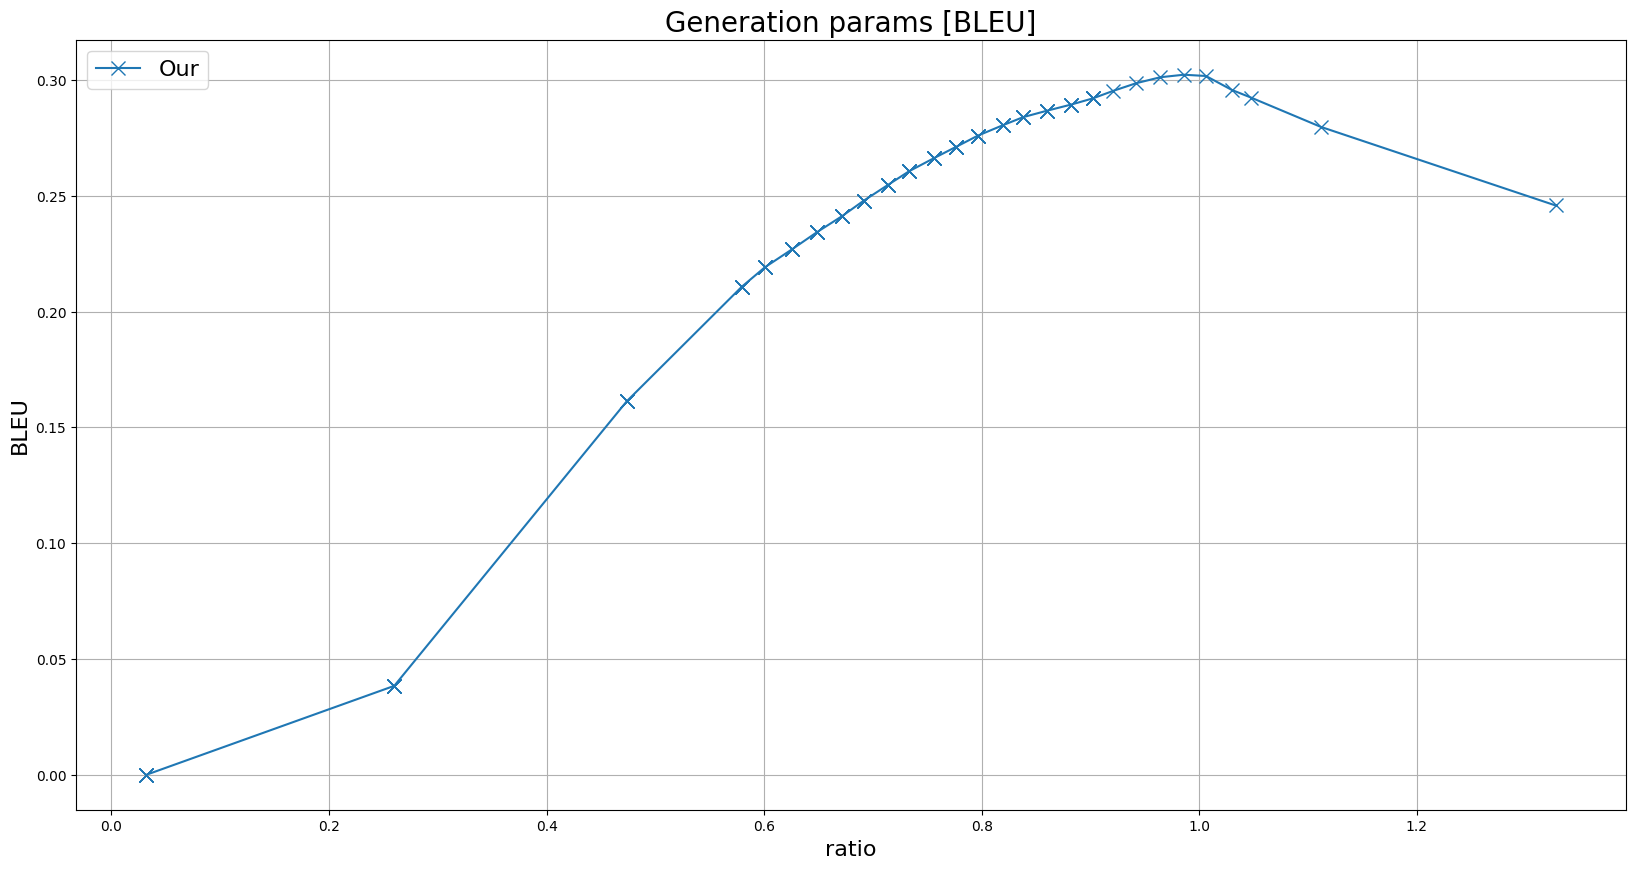

28 24 28


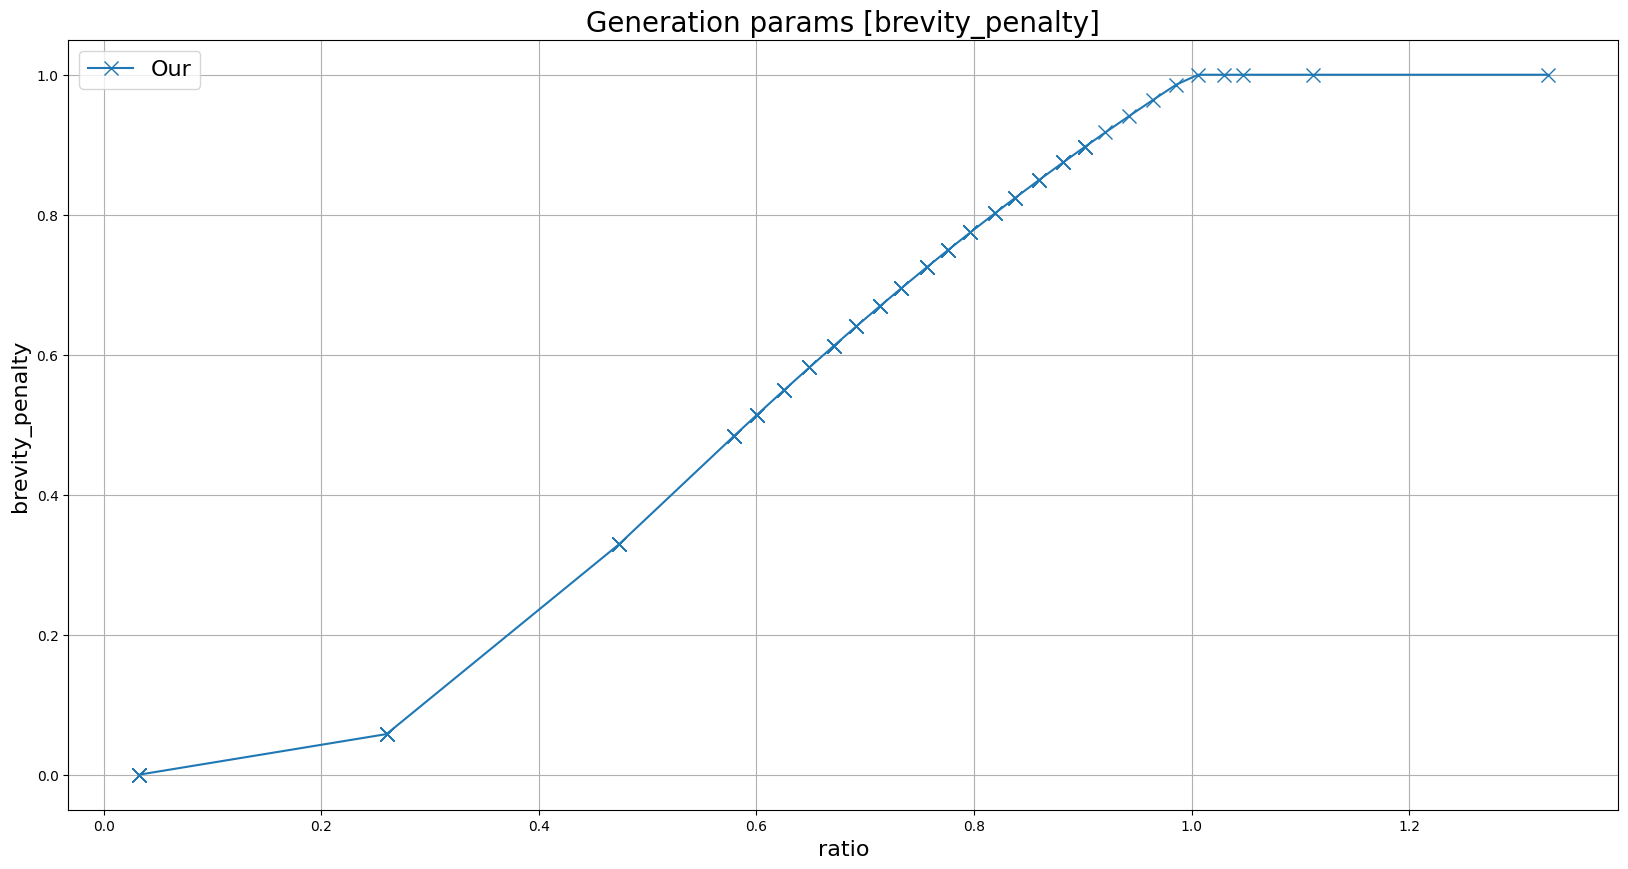

28 28 28


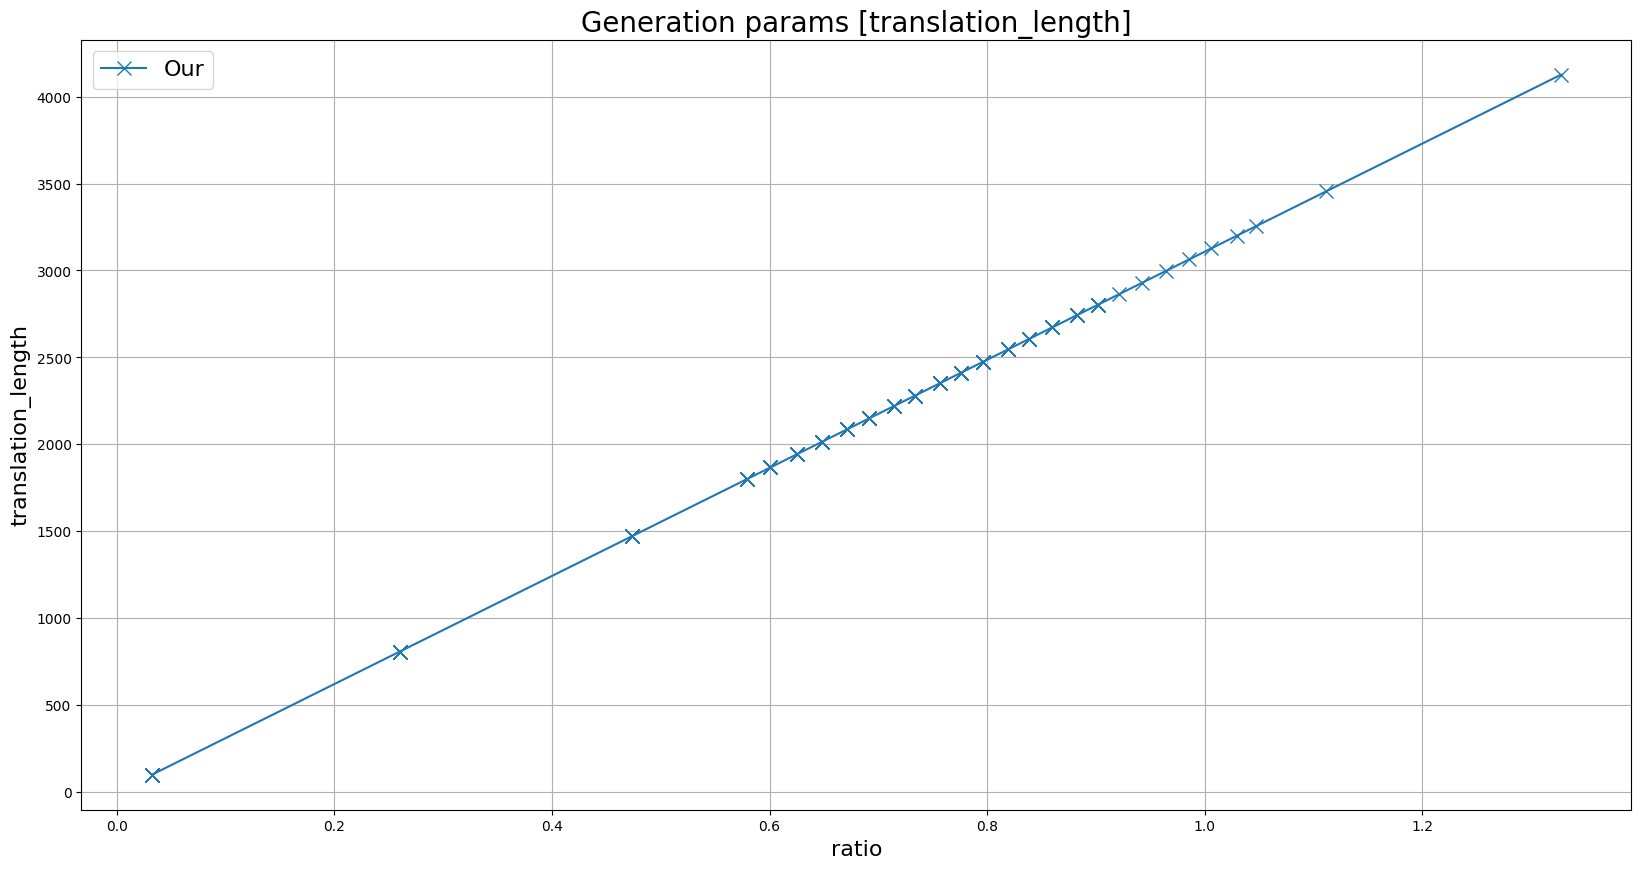

28 1 28


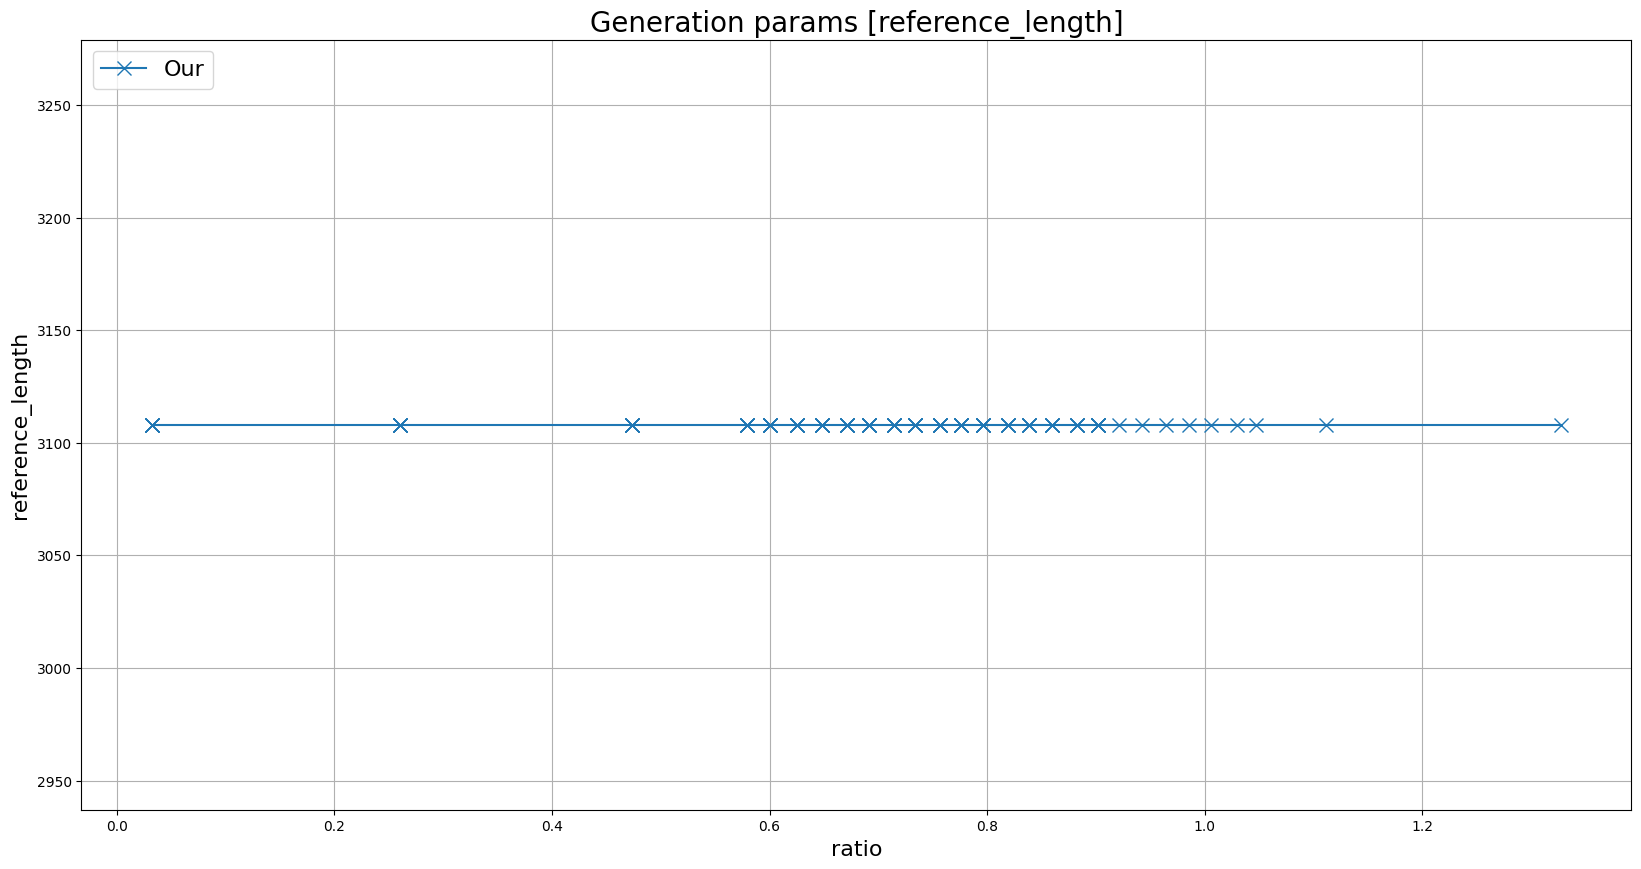

28 28 28


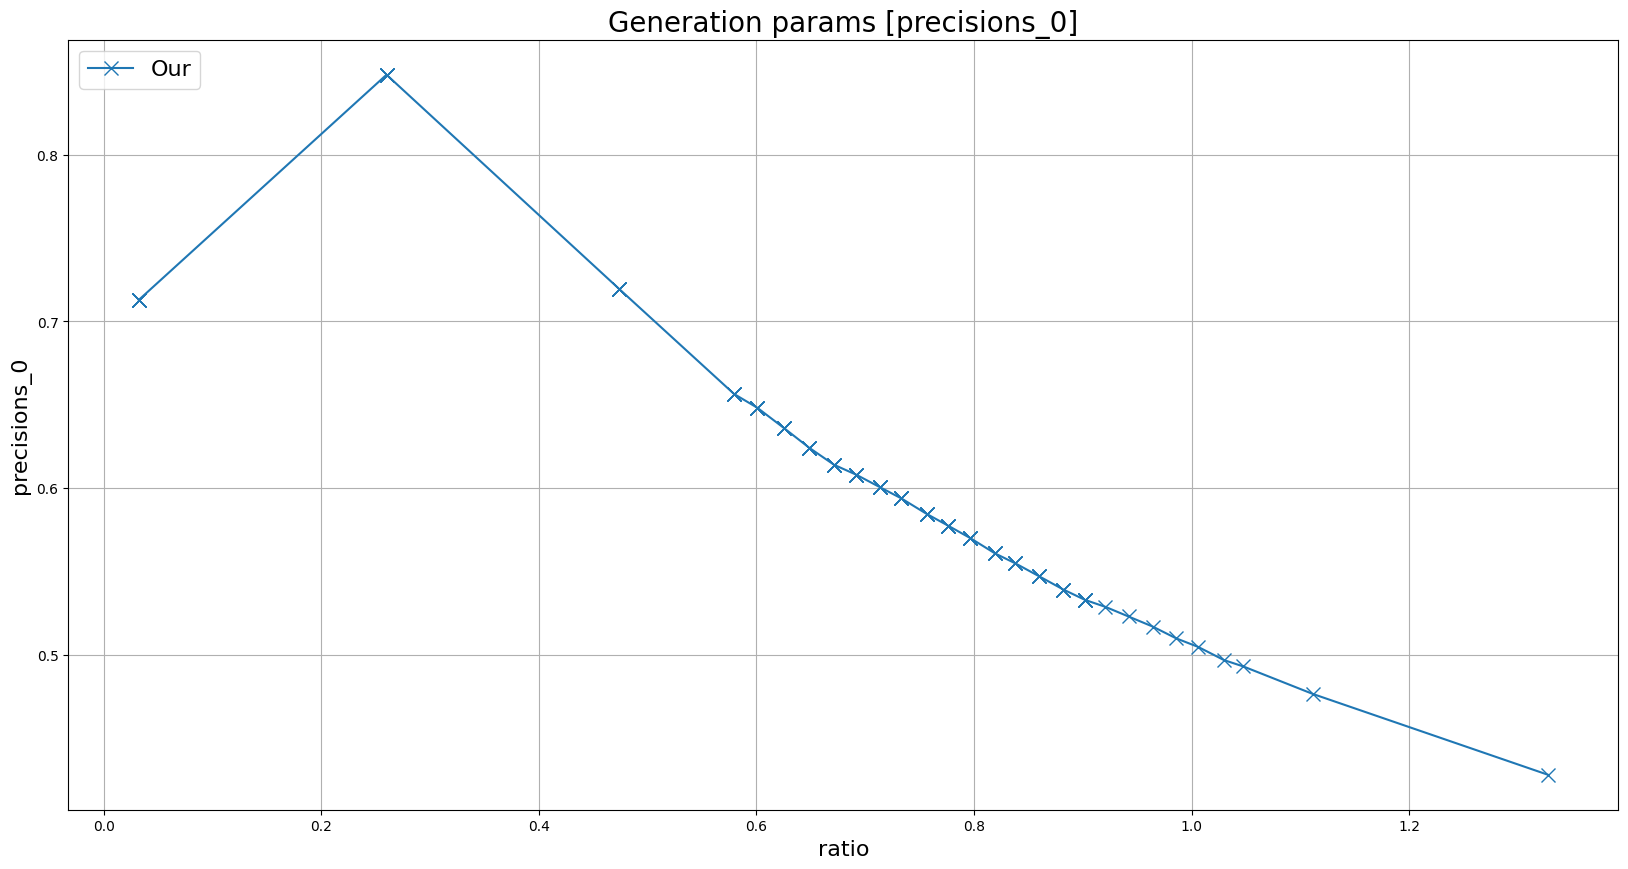

28 28 28


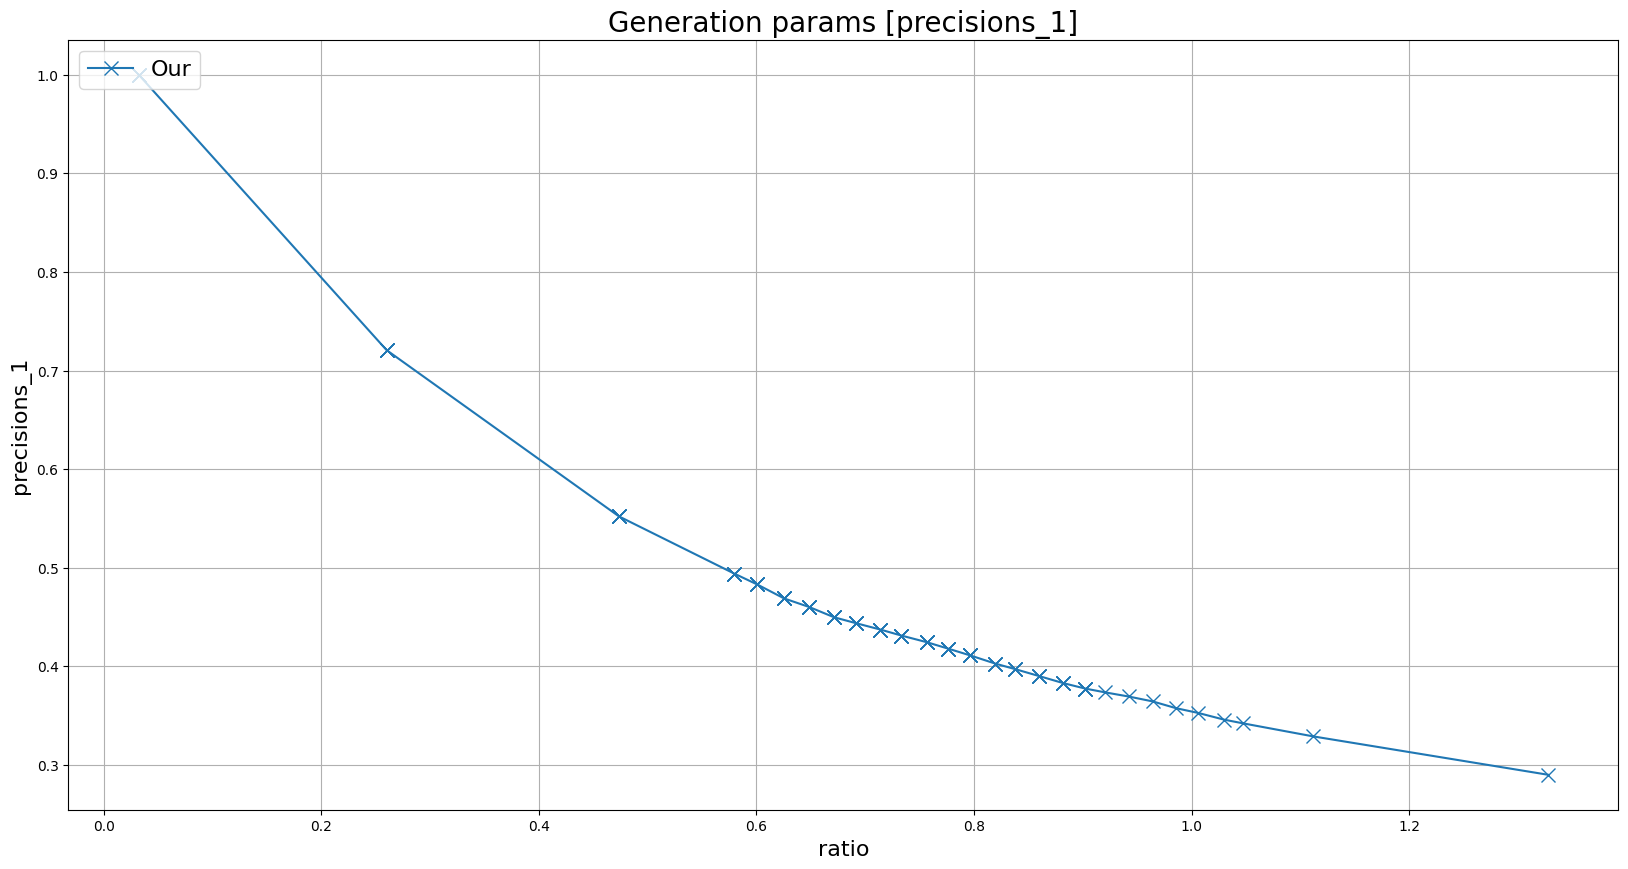

28 28 28


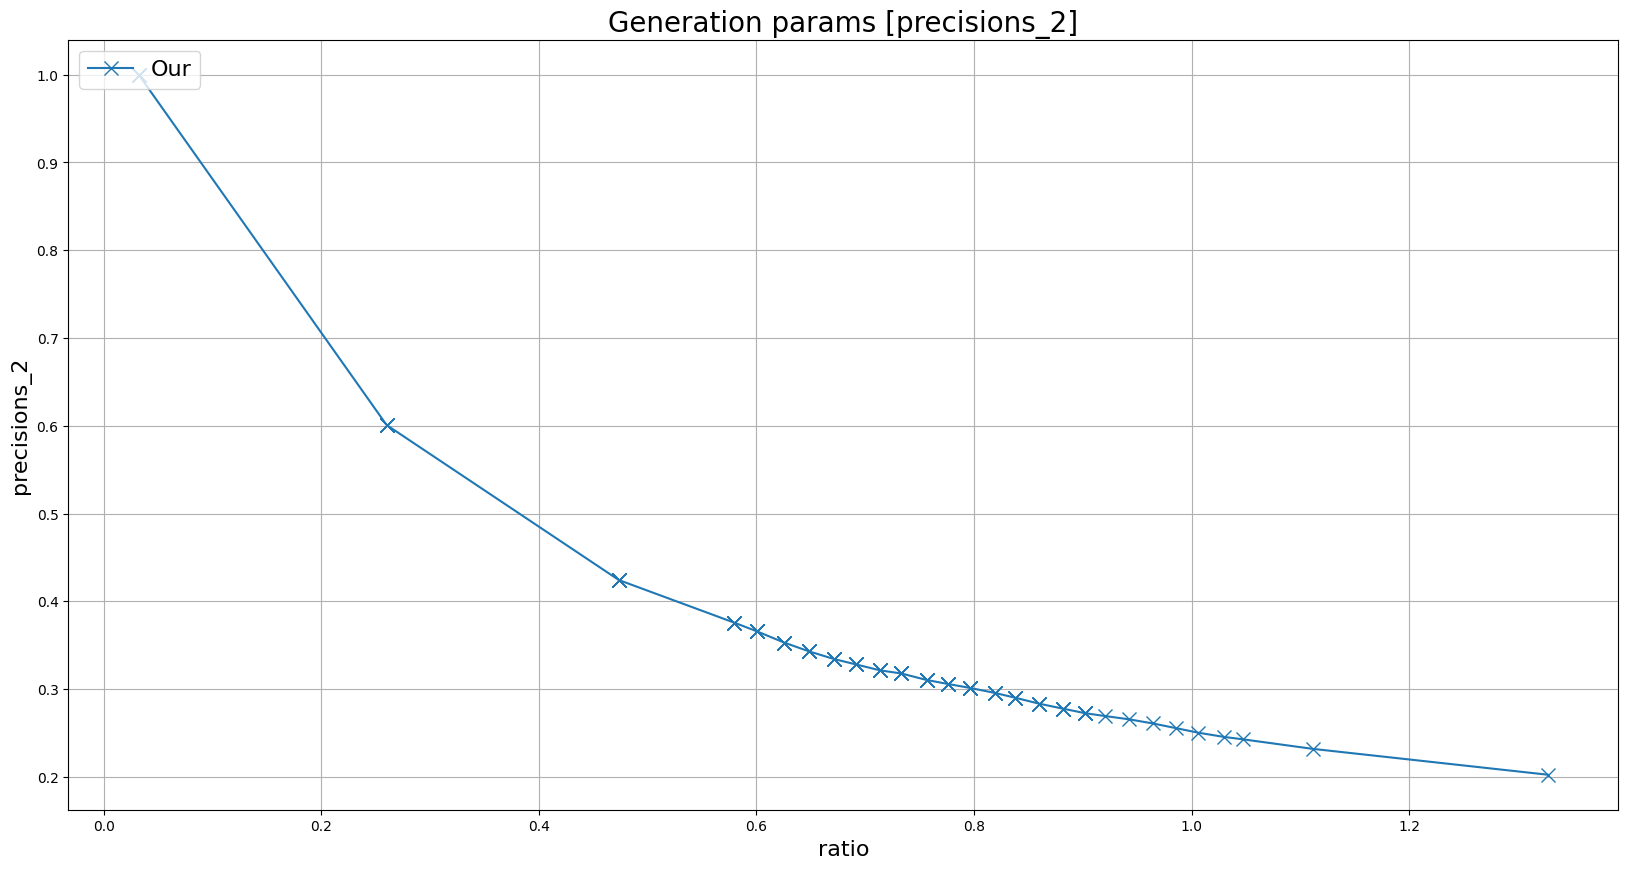

28 28 28


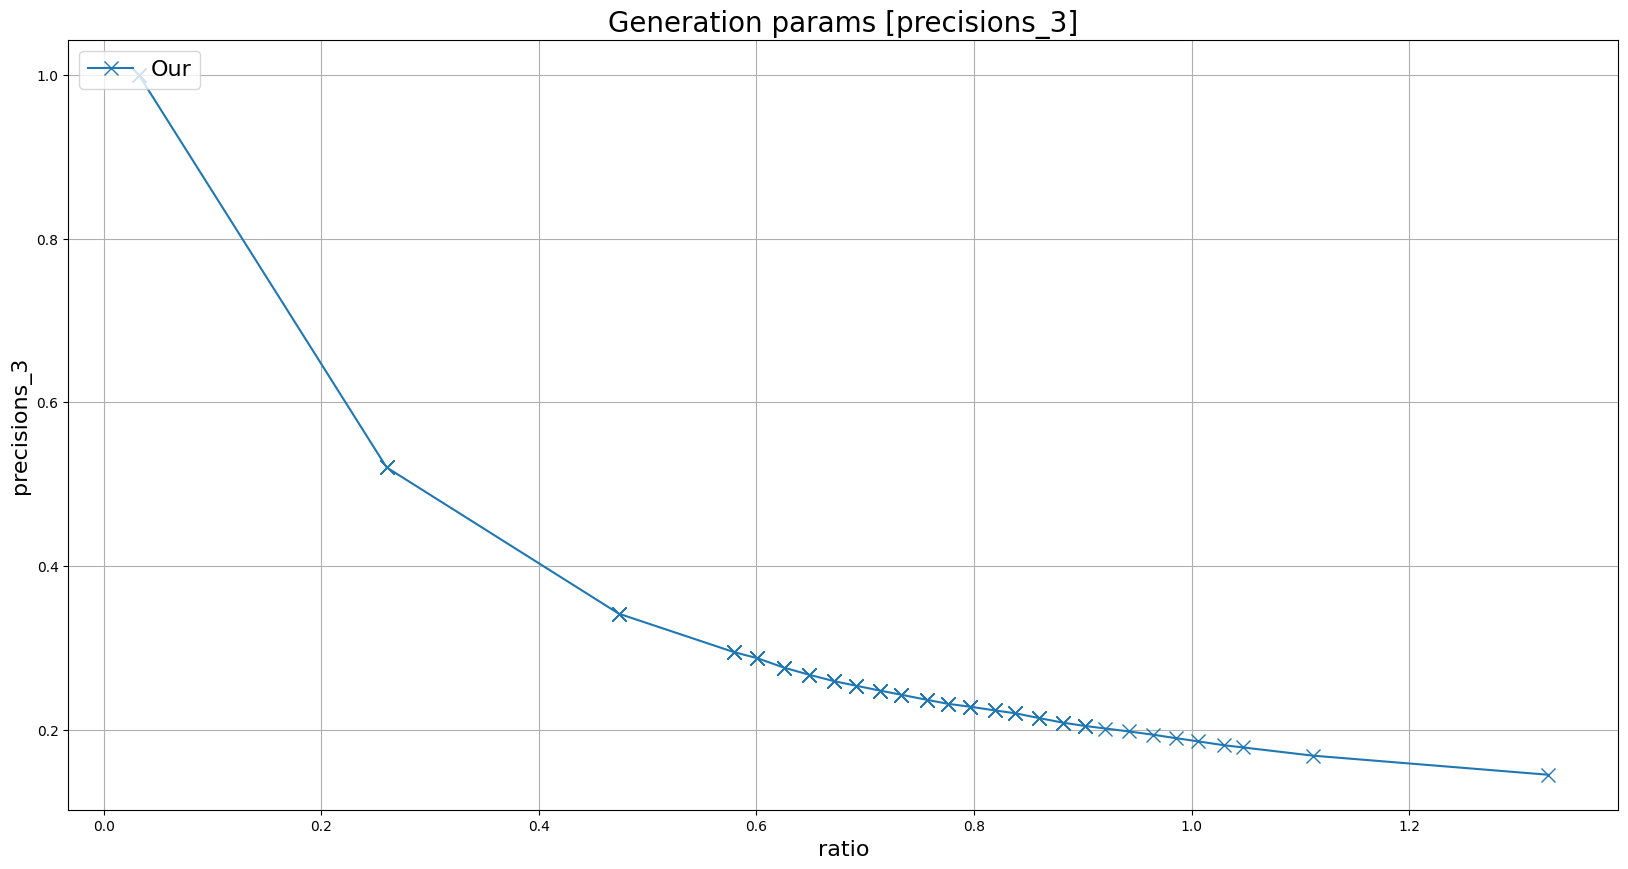

In [106]:
draw_all_metrics(data, 
                 param_name="ratio"
                )

In [100]:
data

EM          BLEU  brevity_penalty     ratio  translation_length   
20  0.0  7.937336e-14     8.638175e-14  0.032175                 100  \
1   0.0  7.937336e-14     8.638175e-14  0.032175                 100   
39  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
77  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
58  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
..  ...           ...              ...       ...                 ...   
94  0.0  2.957250e-01     1.000000e+00  1.029923                3201   
98  0.0  2.986432e-01     9.403761e-01  0.942085                2928   
97  0.0  3.012122e-01     9.636404e-01  0.964286                2997   
93  0.0  3.017467e-01     1.000000e+00  1.006113                3127   
96  0.0  3.022933e-01     9.857423e-01  0.985843                3064   

    reference_length  precisions_0  precisions_1  precisions_2  precisions_3   
20              3108      0.712871      1.000000      1.000000      1.000000  \
1               3108      0.712871      1.000000      1.000000      1.000000   
39              3108      0.712871      1.000000      1.000000      1.000000   
77              3108      0.712871      1.000000      1.000000      1.000000   
58              3108      0.712871      1.000000      1.000000      1.000000   
..               ...           ...           ...           ...           ...   
94              3108      0.496877      0.345906      0.245503      0.181254   
98              3108      0.523045      0.369388      0.265665      0.198174   
97              3108      0.517011      0.364389      0.260901      0.194218   
93              3108      0.504795      0.352708      0.250342      0.185997   
96              3108      0.509951      0.357504      0.255497      0.189873   

    max_new_tokens  temperature                            experiment_name  
20             NaN         0.95  /root/experiments/t2c_concode_220428_v10/  
1              NaN         1.00  /root/experiments/t2c_concode_220428_v10/  
39             NaN         0.90  /root/experiments/t2c_concode_220428_v10/  
77             NaN         0.50  /root/experiments/t2c_concode_220428_v10/  
58             NaN         0.80  /root/experiments/t2c_concode_220428_v10/  
..             ...          ...                                        ...  
94            46.0         1.00  /root/experiments/t2c_concode_220428_v10/  
98            42.0         1.00  /root/experiments/t2c_concode_220428_v10/  
97            43.0         1.00  /root/experiments/t2c_concode_220428_v10/  
93            45.0         1.00  /root/experiments/t2c_concode_220428_v10/  
96            44.0         1.00  /root/experiments/t2c_concode_220428_v10/  

[100 rows x 13 columns]

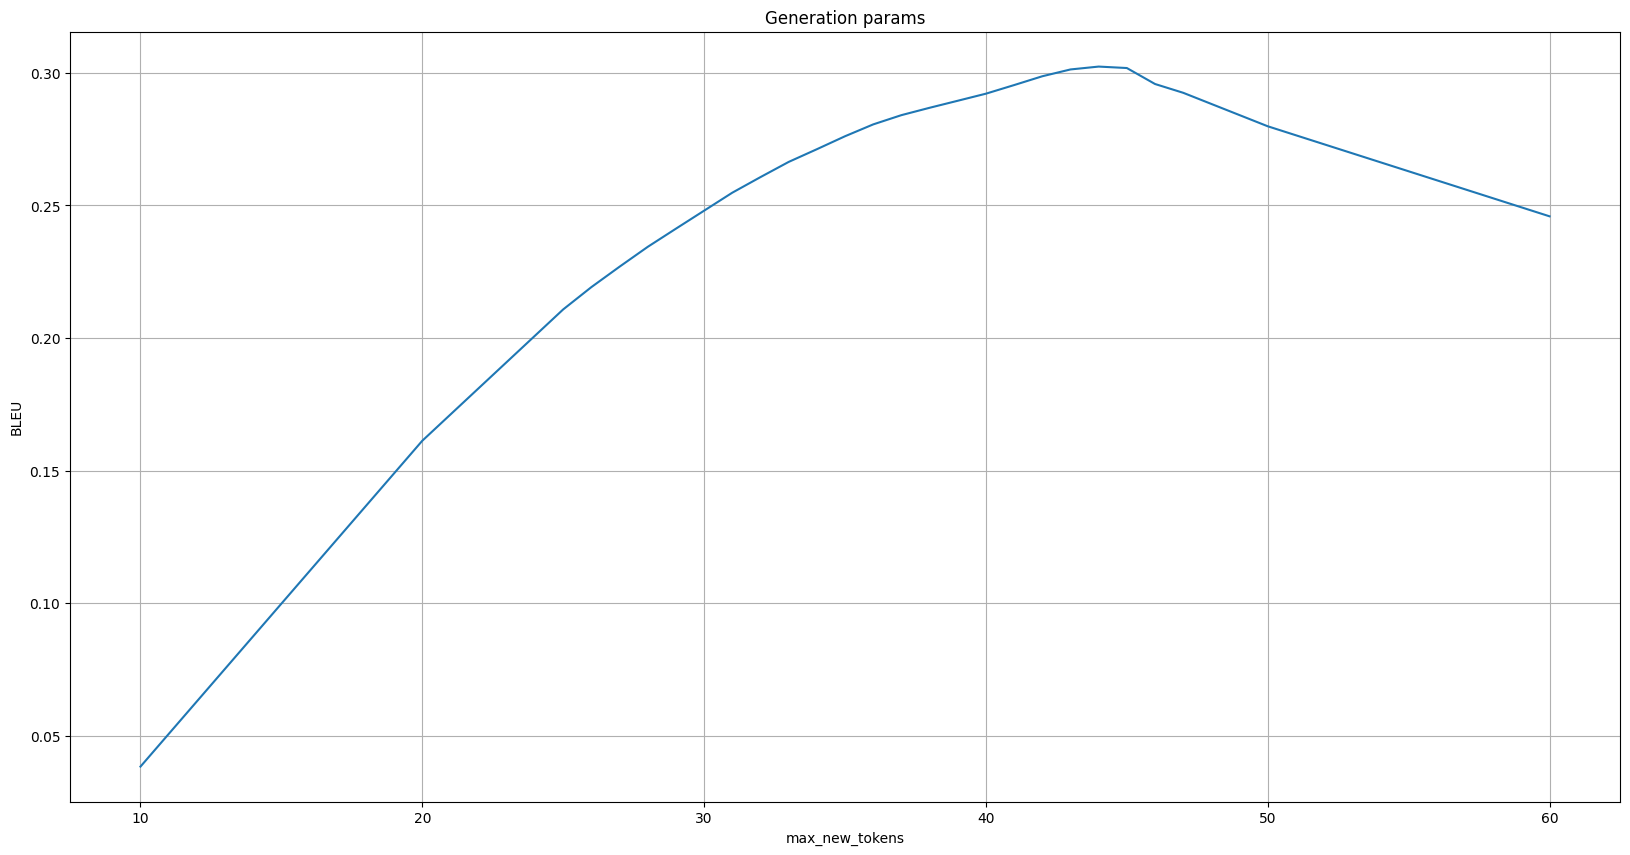

In [43]:
#experiment_name.split('/')[-2]+'.csv'

EM          BLEU  brevity_penalty     ratio  translation_length   
20  0.0  7.937336e-14     8.638175e-14  0.032175                 100  \
1   0.0  7.937336e-14     8.638175e-14  0.032175                 100   
39  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
58  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
77  0.0  7.937336e-14     8.638175e-14  0.032175                 100   
..  ...           ...              ...       ...                 ...   
36  0.0  2.894099e-01     8.750457e-01  0.882239                2742   
18  0.0  2.920768e-01     8.972538e-01  0.902188                2804   
56  0.0  2.920768e-01     8.972538e-01  0.902188                2804   
75  0.0  2.920768e-01     8.972538e-01  0.902188                2804   
37  0.0  2.920768e-01     8.972538e-01  0.902188                2804   

    reference_length  precisions_0  precisions_1  precisions_2  precisions_3   
20              3108      0.712871      1.000000      1.000000       1.00000  \
1               3108      0.712871      1.000000      1.000000       1.00000   
39              3108      0.712871      1.000000      1.000000       1.00000   
58              3108      0.712871      1.000000      1.000000       1.00000   
77              3108      0.712871      1.000000      1.000000       1.00000   
..               ...           ...           ...           ...           ...   
36              3108      0.539191      0.382898      0.277625       0.20876   
18              3108      0.532977      0.377449      0.272553       0.20479   
56              3108      0.532977      0.377449      0.272553       0.20479   
75              3108      0.532977      0.377449      0.272553       0.20479   
37              3108      0.532977      0.377449      0.272553       0.20479   

    max_new_tokens  temperature                            experiment_name  
20             NaN         0.95  /root/experiments/t2c_concode_220428_v10/  
1              NaN         1.00  /root/experiments/t2c_concode_220428_v10/  
39             NaN         0.90  /root/experiments/t2c_concode_220428_v10/  
58             NaN         0.80  /root/experiments/t2c_concode_220428_v10/  
77             NaN         0.50  /root/experiments/t2c_concode_220428_v10/  
..             ...          ...                                        ...  
36            39.0         0.95  /root/experiments/t2c_concode_220428_v10/  
18            40.0         1.00  /root/experiments/t2c_concode_220428_v10/  
56            40.0         0.90  /root/experiments/t2c_concode_220428_v10/  
75            40.0         0.80  /root/experiments/t2c_concode_220428_v10/  
37            40.0         0.95  /root/experiments/t2c_concode_220428_v10/  

[90 rows x 13 columns]

In [29]:
!ls /root/results/2023-05-05-11_46_10.txtj

ls: cannot access '/root/results/2023-05-05-11_46_10.txtj': No such file or directory


In [30]:
fn_output = "/root/results/2023-05-05-11_46_10.txt"

In [32]:
!head /root/results/2023-05-05-11_46_10.txt

int function ( ) { int loc0 = _total ; for ( Iterator loc1 = _support ; loc1 . hasNext ( ) ;
void function ( boolean arg0 ) { fStatementsRecovery = arg0 ; } ### Exception : void function ( ) { f
boolean function ( ) { return true ; } ### Exceptions: void function ( ) { } void function ( ) { } 
String function ( ) { return getIdentitiesZNode ( ) ; } ### Exceptions: String function ( ) { throw new Runtime
int function ( GenVector < C > arg0 ) { return this . signum ( arg0 ) ; } ### Exceptions : 
void function ( Region arg0 ) { fTagPosition = arg0 ; } } void setTagPosition ( Region arg0 ) { fTag
double function ( double arg0 , double arg1 , double arg2 , double arg3 , double arg4 , double arg5 , double arg6
boolean function ( ) { return false ; } ### Exception : void function ( ) { } ### Parameters : boolean [
Integer function ( ) { return intervalQualifier . getFractionalSecondPrecision ( ) ; } ### Exception : Illegal
byte [ ] function ( Drawable arg0 ) { byte [ ] loc0 = new byte [ arg0 

In [37]:
def foo(s):
    return s.split("### Exceptions")[0]
open(fn_output+'_fix.txt', "w+").write(
    '\n'.join([foo(s) for s  in open(fn_output, "r").read().split('\n')])
)

8820

In [38]:
# !head {evaluator.fn_etalon}

In [39]:
import subprocess
# command = f"python /root/CodeXGLUE/Text-Code/text-to-code/evaluator/evaluator.py -a /root/CodeXGLUE/Text-Code/text-to-code/evaluator/answers.json -p {current_pred_name}"
command = f"python /root/code/CodeXGLUE_t2c_evaluator/evaluator.py -a {evaluator.fn_etalon} -p {fn_output+'_fix.txt'}"

result = subprocess.run(command.split(' '), 
                        stderr=subprocess.PIPE)
result.stderr
results = result.stderr.decode()
print(results)

INFO:__main__:BLEU: 23.23, EM: 14.0



In [31]:
import subprocess
# command = f"python /root/CodeXGLUE/Text-Code/text-to-code/evaluator/evaluator.py -a /root/CodeXGLUE/Text-Code/text-to-code/evaluator/answers.json -p {current_pred_name}"
command = f"python /root/code/CodeXGLUE_t2c_evaluator/evaluator.py -a {evaluator.fn_etalon} -p {fn_output}"

result = subprocess.run(command.split(' '), 
                        stderr=subprocess.PIPE)
result.stderr
results = result.stderr.decode()
print(results)

INFO:__main__:BLEU: 24.8, EM: 0.0



In [29]:
pd.DataFrame(res)#experiment_name.split('/')[-2]+'.csv'

EM          BLEU  brevity_penalty     ratio  translation_length   
0   0.0  3.670477e-12     4.045834e-12  0.036720                  30  \
1   0.0  3.670477e-12     4.045834e-12  0.036720                  30   
2   0.0  3.670477e-12     4.045834e-12  0.036720                  30   
3   0.0  5.527188e-02     9.684012e-02  0.299878                 245   
4   0.0  5.527188e-02     9.684012e-02  0.299878                 245   
5   0.0  5.527188e-02     9.684012e-02  0.299878                 245   
6   0.0  1.817280e-01     4.584260e-01  0.561812                 459   
7   0.0  1.817280e-01     4.584260e-01  0.561812                 459   
8   0.0  1.817280e-01     4.584260e-01  0.561812                 459   
9   0.0  2.323938e-01     8.361626e-01  0.848225                 693   
10  0.0  2.323938e-01     8.361626e-01  0.848225                 693   
11  0.0  2.323938e-01     8.361626e-01  0.848225                 693   
12  0.0  1.749703e-01     1.000000e+00  1.422277                1162   

    reference_length  precisions_0  precisions_1  precisions_2  precisions_3   
0                817      0.677419      1.000000      1.000000      1.000000  \
1                817      0.677419      1.000000      1.000000      1.000000   
2                817      0.677419      1.000000      1.000000      1.000000   
3                817      0.796748      0.629630      0.500000      0.423077   
4                817      0.796748      0.629630      0.500000      0.423077   
5                817      0.796748      0.629630      0.500000      0.423077   
6                817      0.656522      0.460465      0.325000      0.251351   
7                817      0.656522      0.460465      0.325000      0.251351   
8                817      0.656522      0.460465      0.325000      0.251351   
9                817      0.521614      0.338855      0.219243      0.153974   
10               817      0.521614      0.338855      0.219243      0.153974   
11               817      0.521614      0.338855      0.219243      0.153974   
12               817      0.344798      0.214475      0.135993      0.093197   

    max_new_tokens  min_new_tokens  
0              NaN              10  
1              NaN              10  
2              NaN              10  
3             10.0              10  
4             10.0              10  
5             10.0              10  
6             20.0              10  
7             20.0              10  
8             20.0              10  
9             30.0              10  
10            30.0              10  
11            30.0              10  
12            50.0              10

In [25]:
[i for i in res if i['max_new_tokens']==30]

[{'EM': 0.0,
  'BLEU': 0.23239378792921556,
  'brevity_penalty': 0.8361626069149046,
  'ratio': 0.8482252141982864,
  'translation_length': 693,
  'reference_length': 817,
  'precisions_0': 0.521613832853026,
  'precisions_1': 0.338855421686747,
  'precisions_2': 0.2192429022082019,
  'precisions_3': 0.15397350993377484,
  'max_new_tokens': 30,
  'min_new_tokens': 10},
 {'EM': 0.0,
  'BLEU': 0.23239378792921556,
  'brevity_penalty': 0.8361626069149046,
  'ratio': 0.8482252141982864,
  'translation_length': 693,
  'reference_length': 817,
  'precisions_0': 0.521613832853026,
  'precisions_1': 0.338855421686747,
  'precisions_2': 0.2192429022082019,
  'precisions_3': 0.15397350993377484,
  'max_new_tokens': 30,
  'min_new_tokens': 10},
 {'EM': 0.0,
  'BLEU': 0.23239378792921556,
  'brevity_penalty': 0.8361626069149046,
  'ratio': 0.8482252141982864,
  'translation_length': 693,
  'reference_length': 817,
  'precisions_0': 0.521613832853026,
  'precisions_1': 0.338855421686747,
  'precisi

In [23]:
import pandas as pd
df = pd.DataFrame(res)
df.pivot(values="BLEU", index="max_new_tokens", columns="min_new_tokens")

ValueError: Index contains duplicate entries, cannot reshape

In [21]:
import pandas as pd
df = pd.DataFrame(res)
df.pivot(values="BLEU", index="max_new_tokens", columns="min_new_tokens")

min_new_tokens          NaN           10.0          20.0          30.0   
max_new_tokens                                                           
NaN             3.670477e-12  3.670477e-12  3.670477e-12  3.670477e-12  \
10.0            5.527188e-02  5.527188e-02           NaN           NaN   
20.0            1.817280e-01  1.817280e-01  1.817280e-01           NaN   
30.0            2.323938e-01  2.323938e-01  2.323938e-01  2.323938e-01   
50.0            1.749703e-01           NaN           NaN           NaN   

min_new_tokens          40.0          60.0  
max_new_tokens                              
NaN             3.670477e-12  3.670477e-12  
10.0                     NaN           NaN  
20.0                     NaN           NaN  
30.0                     NaN           NaN  
50.0                     NaN           NaN

In [5]:
BASE_MODEL = "decapoda-research/llama-7b-hf"
LORA_WEIGHTS = experiment_name #"tloen/alpaca-lora-7b"

model = LLaMAForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    device_map="auto"
)

model = PeftModel.from_pretrained(
    model,
    LORA_WEIGHTS,
    torch_dtype=torch.float16,
)

tokenizer = LLaMATokenizer.from_pretrained(BASE_MODEL)
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
tokenizer.padding_side = "left"
# not sure how necessary this part is, not sure if tloen/alpaca-lora-7b was even trained with EOS and BOS tokens
model.config.bos_token_id = 1
model.config.eos_token_id = 2

model.eval()

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): Dropout(p=0.05, inplace=False)
                (lora_A): Linear(in_features=4096, out_features=4, bias=False)
                (lora_B): Linear(in_features=4, out_features=4096, bias=False)
              )
              (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): Dropout(p=0.05, inplace=False)
                (lora_A): Linear(in_features=4096, out_features=4, bias=False)
                (lora_B): Linear(in_features=

In [6]:
from EvaluateTestSet2 import EvaluateTestSet

evaluator = EvaluateTestSet()
metric_res = evaluator.evaluate(model=model, 
                                tokenizer=tokenizer
                               )
metric_res

  0%|                                                    | 0/10 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0 10 10


 10%|████▍                                       | 1/10 [00:20<03:04, 20.45s/it]

10 20 10


 20%|████████▊                                   | 2/10 [00:40<02:41, 20.22s/it]

20 30 10


 30%|█████████████▏                              | 3/10 [01:01<02:23, 20.53s/it]

30 40 10


 40%|█████████████████▌                          | 4/10 [01:21<02:01, 20.29s/it]

40 50 10


 50%|██████████████████████                      | 5/10 [01:40<01:39, 19.82s/it]

50 60 10


 60%|██████████████████████████▍                 | 6/10 [02:00<01:19, 19.99s/it]

60 70 10


 70%|██████████████████████████████▊             | 7/10 [02:23<01:02, 20.83s/it]

70 80 10


 80%|███████████████████████████████████▏        | 8/10 [02:41<00:40, 20.02s/it]

80 90 10


 90%|███████████████████████████████████████▌    | 9/10 [03:01<00:19, 19.92s/it]

90 100 10


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 39246.79it/s]


{'EM': 0.0,
 'BLEU': 0.09161595632467821,
 'brevity_penalty': 1.0,
 'ratio': 3.0341055341055343,
 'translation_length': 9430,
 'reference_length': 3108,
 'precisions_0': 0.1820591665783056,
 'precisions_1': 0.11370699817811596,
 'precisions_2': 0.07193153504495721,
 'precisions_3': 0.04731135691600044}

In [26]:
!mkdir temp

In [54]:
import json

# def save_small_data()
b = json.load(open("../data/t2c_answers.json", "r"))
json.dump(b[:30], open('temp/t2c_answers.json', "w+"))

a = open("/root/data/answers.json", "r").readlines()
small_answers = '\n'.join([json.dumps({"code": json.loads(i)['code']}) 
                           for i in a[:30]
                          ]
                         )

open('temp/answers.json', 'w+').write(small_answers)

4113

1285

In [55]:
evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = 25,
                                                                 min_new_tokens = 2,
                                                                ),
                            fn_test_data = "temp/t2c_answers.json",
                            fn_etalon = "temp/answers.json"
                           )
metric_res = evaluator.evaluate(model=model, 
                                tokenizer=tokenizer,
                               )
metric_res

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0 10 10


 33%|███████████████                              | 1/3 [00:04<00:09,  4.63s/it]

10 20 10


 67%|██████████████████████████████               | 2/3 [00:09<00:04,  4.58s/it]

20 30 10


100%|███████████████████████████████████████| 30/30 [00:00<00:00, 201004.98it/s]


{'EM': 0.0,
 'BLEU': 0.21551319390071327,
 'brevity_penalty': 0.7059683881507222,
 'ratio': 0.7417380660954712,
 'translation_length': 606,
 'reference_length': 817,
 'precisions_0': 0.556836902800659,
 'precisions_1': 0.37261698440207974,
 'precisions_2': 0.24314442413162707,
 'precisions_3': 0.172147001934236}

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0 10 10


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 82402.83it/s]


{'EM': 0.0,
 'BLEU': 0.06877774926475176,
 'brevity_penalty': 1.0,
 'ratio': 3.802281368821293,
 'translation_length': 1000,
 'reference_length': 263,
 'precisions_0': 0.13686313686313686,
 'precisions_1': 0.09182643794147326,
 'precisions_2': 0.05402650356778797,
 'precisions_3': 0.032955715756951595}

In [45]:
# 263*3.8

In [40]:
# [json.loads(a[i])['code']==b[i]['output'] for i in range(100)]

In [41]:
# b[0]['instruction']

In [42]:
# b[0]['output']

In [10]:
evaluator.fn_etalon

'/root/data/answers.json'

In [11]:
evaluator.fn_test_data

'../data/t2c_answers.json'

In [ ]:
import json
config = LoraConfig(**json.load(open("/root/experiments/t2c_concode_220428_v12/adapter_config.json", "r")))
model = get_peft_model(model, config)
tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token